In [1]:
%run dataFormating.ipynb

rmdf152 read_csv success


../Utilities/Preparation.ipynb:2: ParserWarning: Both a converter and dtype were specified for column customData.localplayerguid - only the converter will be used
  "cells": [


gformEN read_csv success
gformFR read_csv success
temporalities set


FloatProgress(value=0.0, max=401.0)

dataFormating.ipynb:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  "outputs": [


In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from pandas.plotting import scatter_matrix, parallel_coordinates

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from ipywidgets import FloatProgress
from IPython.display import display

from math import *

from scipy import stats

# Re-usable functions

In [3]:
# This function counts the number of occurences for each unique element in a list
def get_cnt(lVals):
    d = dict(zip(lVals, [0] * len(lVals)))
    for x in lVals:
        d[x] += 1
    return d

In [4]:
# This function fit a KMeans clustering model on the data, for each number of clusters in a specified range.
# It displays the silhouette analysis plot for each number of clusters and outputs the silhouette scores
# The higher the silhouette score, the more distinct the clusters are. In a good clustering, all clusters raise above the average
# Source: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
def tryKmeans(dataset, rangeNbClusters=[2, 3, 4, 5]):
    results = []
    
    # For each number of clusters
    for n_clusters in rangeNbClusters:
        # Create a subplot with 1 row and 1 column, make it possible to easily add plots in the function later if needed
        fig, ax = plt.subplots()
        fig.set_size_inches(12, 6)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax.set_ylim([0, len(dataset) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(dataset)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(dataset, cluster_labels)
        
        # Save the silhouette score, the size of each cluster and the cluster assignement labels
        results.append([n_clusters, silhouette_avg, get_cnt(clusterer.labels_), clusterer.labels_])

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(dataset, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax.set_title("The silhouette plot for the various clusters.")
        ax.set_xlabel("The silhouette coefficient values")
        ax.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax.set_yticks([])  # Clear the yaxis labels / ticks
        ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()
        
    return results

In [5]:
# This function takes the initial data, result of tryKmeans and a chosen number of clusters
# It returns the label assignements of the sample
# If specified, it plots the parallel coordinates plot
# If specified, display only specified clusters
def detailsKmeans(initData, kmeansResult, nbClusters, displayParallelCoord = False, clusterLabels = [], clustersToDisplay = [], scale = False):
    # Add cluster assignement to the data
    assignements = list(kmeansResult.loc[kmeansResult["Number of clusters"] == nbClusters,'Label assignements'])[0]
    assignements = pd.DataFrame(data = assignements, columns = ["Index of cluster"], index = initData.index)
    
    # Displays
    if displayParallelCoord:
        nbGroups = ceil(len(initData.columns) / 8)
        print("Will split columns into {} groups".format(nbGroups))
        progressBar = FloatProgress(value = 0.0, min = 0.0, max = nbGroups)
        display(progressBar)
        # The data is split into several groups of columns for display
        for i in range(nbGroups):
            # Plot the data for the selected columns
            rangeMin = i * 8
            rangeMax = min(len(initData.columns), i * 8 + 9)
            scaledData = initData.iloc[:,rangeMin:rangeMax].copy()
            # Deal with scaling if specified
            if scale:
                col = scaledData.columns
                ind = scaledData.index
                scaledData = preprocessing.scale(scaledData)
                scaledData = pd.DataFrame(data = scaledData, columns=col, index=ind)
            labelledData = pd.concat([scaledData, assignements], axis = 1, join = "inner")
            # Select only some clusters if specified
            if len(clustersToDisplay) > 0:
                labelledData = labelledData.loc[labelledData["Index of cluster"].isin(clustersToDisplay), :]
            fig, ax = plt.subplots()
            fig.set_size_inches(17, 3)
            ax = parallel_coordinates(labelledData, 'Index of cluster')
            
            # Beautification
            plt.xticks(rotation=60)
            if len(clusterLabels) > 0:
                handles, labels = ax.get_legend_handles_labels()
                ax.legend(handles, clusterLabels)
            plt.show()
            
            progressBar.value += 1.0
    
    return assignements

In [6]:
# This function computes the frequency of True answers (scientific questions) or of each possible answer (non-scientific questions) for each cluster of a given clustering
# The specified question can be "allScience" (return table for all scientific questions) or the tag of any question
# If specific question and nbClusters = 2, print t-test between clusters
def freqByCluster(initData, kmeansResult, nbClusters, question) :
    # Add cluster assignement to the data
    assignements = list(kmeansResult.loc[kmeansResult["Number of clusters"] == nbClusters,'Label assignements'])[0]
    assignements = pd.DataFrame(data = assignements, columns = ["Index of cluster"], index = initData.index)
    
    # Get the size of the clusters
    sizeOfClusters = kmeansResult.loc[kmeansResult["Number of clusters"] == nbClusters,'Size of cluster'][0]
    
    # All scientific questions
    if question == "allScience":
        labelledData = initData.loc[:, "Q1":"Q27"]
        labelledData = pd.concat([labelledData, assignements], axis = 1, join = "inner")
        answersByCluster = pd.DataFrame()
        for cluster in range(nbClusters):
            nameOfCluster = "Cluster " + str(cluster)
            answersByCluster[nameOfCluster] = labelledData[labelledData["Index of cluster"] == cluster].sum()
            answersByCluster[nameOfCluster] = answersByCluster[nameOfCluster].divide(sizeOfClusters[cluster])
        answersByCluster.drop("Index of cluster", inplace=True)
    # For a specific question
    else:
        labelledData = pd.concat([initData, assignements], axis = 1, join = "inner")
        labelledData = labelledData.loc[:,[question, "Index of cluster"]]
        if (nbClusters == 2):
            group1 = labelledData[labelledData["Index of cluster"] == 0][question]
            group2 = labelledData[labelledData["Index of cluster"] == 1][question]
            print(stats.ttest_ind(group1, group2))
        answersByCluster = pd.DataFrame()
        for cluster in range(nbClusters):
            nameOfCluster = "Cluster " + str(cluster)
            frequencies = labelledData[labelledData["Index of cluster"] == cluster].groupby(question).count()
            frequencies = frequencies.divide(sizeOfClusters[cluster])
            frequencies = pd.DataFrame(data = frequencies["Index of cluster"].values, index = list(frequencies.index), columns = [nameOfCluster])
            answersByCluster = pd.concat([answersByCluster, frequencies], axis=1)
        answersByCluster.fillna(value = 0, inplace = True)
        
    return answersByCluster


# Can the data be clustered according to the answers given to the before questionnaire?

## If scientific questions are coded by answers

C:\Users\Mikael\Anaconda3\envs\conda-env-python3-py\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


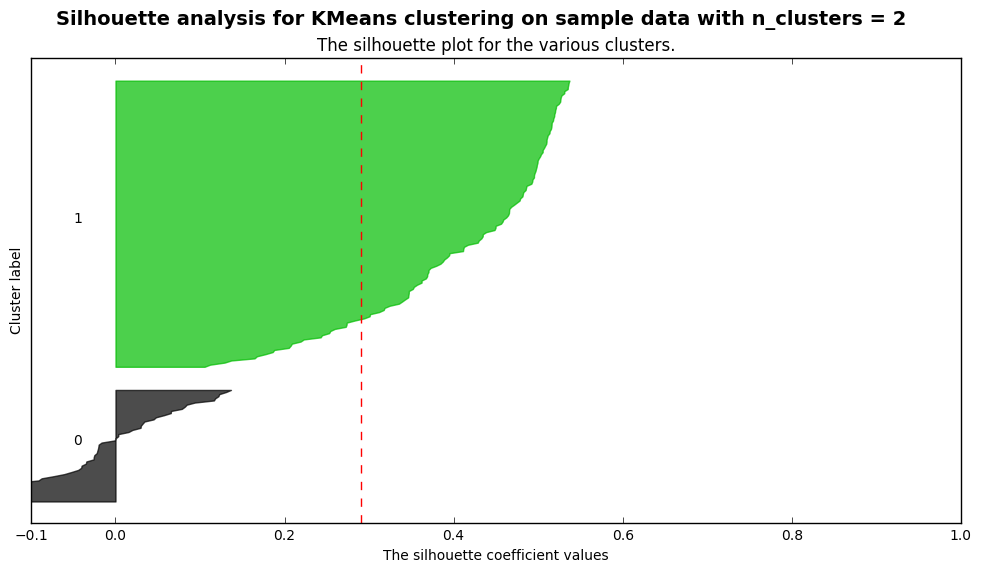

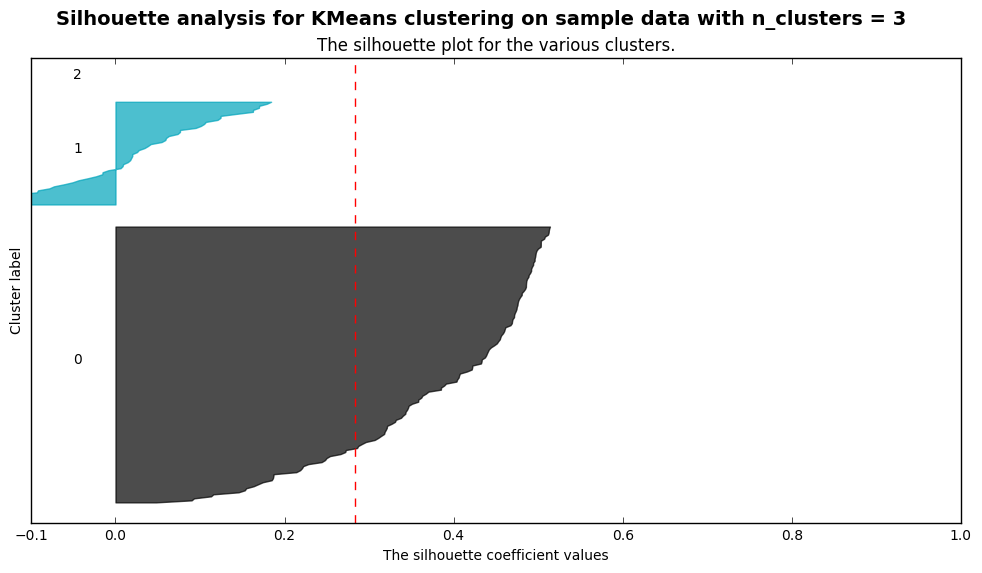

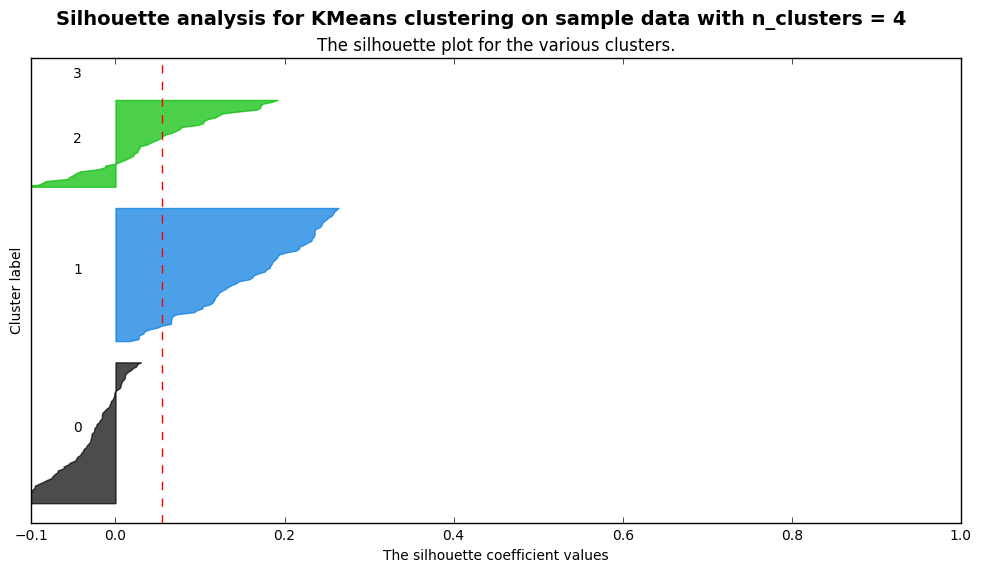

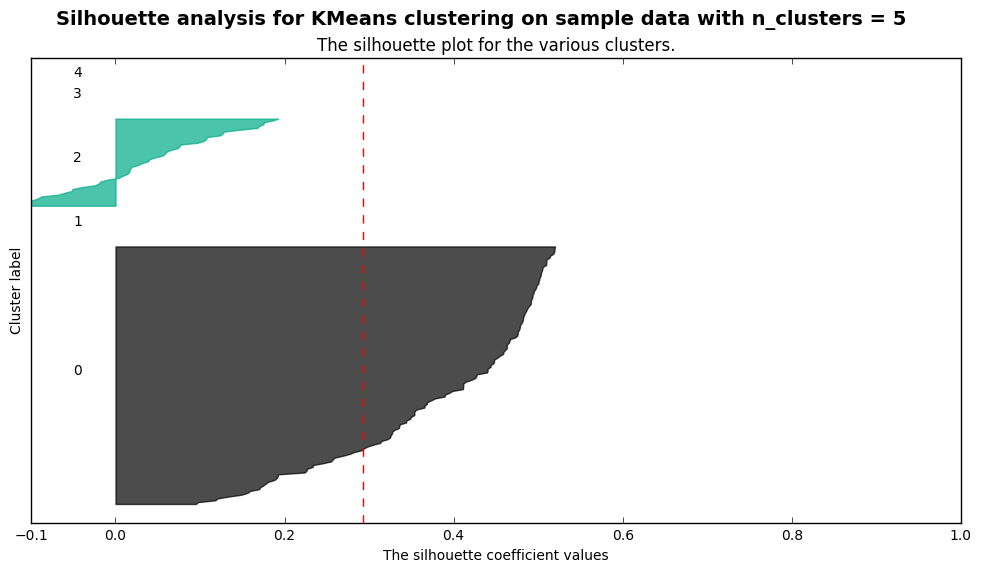

Number of clusters  Average silhouette score  \
0                   2                  0.290612   
1                   3                  0.283423   
2                   4                  0.055099   
3                   5                  0.292735   

                     Size of cluster  \
0                    {0: 54, 1: 137}   
1              {0: 138, 1: 52, 2: 1}   
2        {0: 74, 1: 70, 2: 46, 3: 1}   
3  {0: 140, 1: 1, 2: 48, 3: 1, 4: 1}   

                                  Label assignements  
0  [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...  
1  [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...  
2  [2, 2, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 2, ...  
3  [2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, ...

In [7]:
# Convert DataFrame to matrix
beforeMat = beforeForms.as_matrix()
# Standardise data
beforeMat = preprocessing.scale(beforeMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
beforeResults = tryKmeans(beforeMat)
# Format results as a DataFrame
beforeResults = pd.DataFrame(data=beforeResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
beforeResults

Conclusion: No interesting clustering (30/11/2017)

## If scientific questions are coded by correctedness

C:\Users\Mikael\Anaconda3\envs\conda-env-python3-py\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


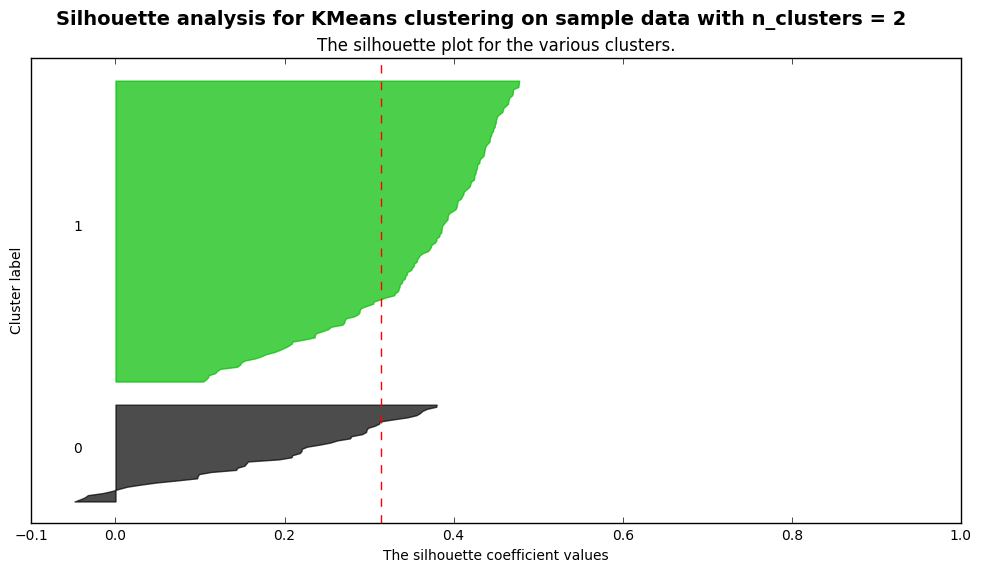

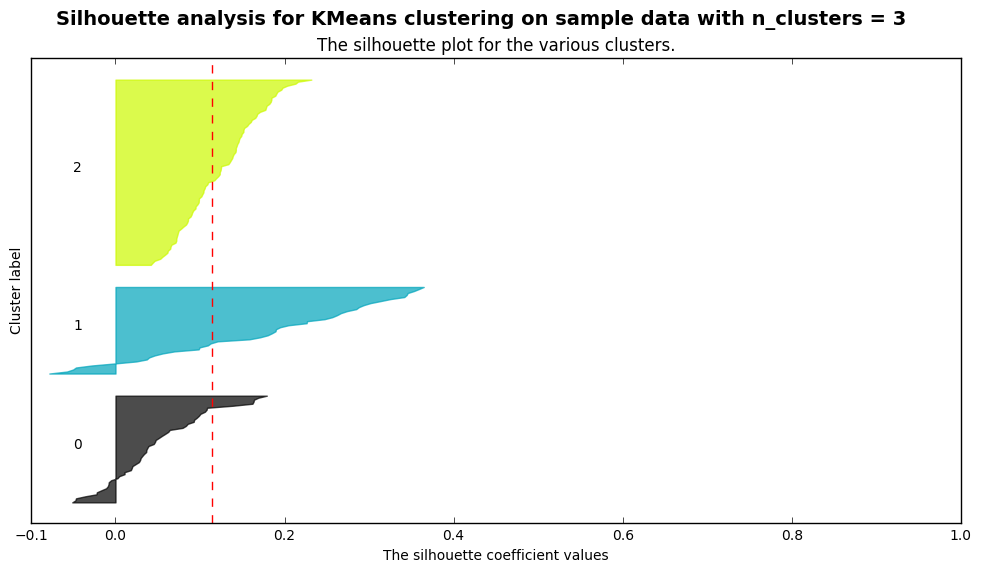

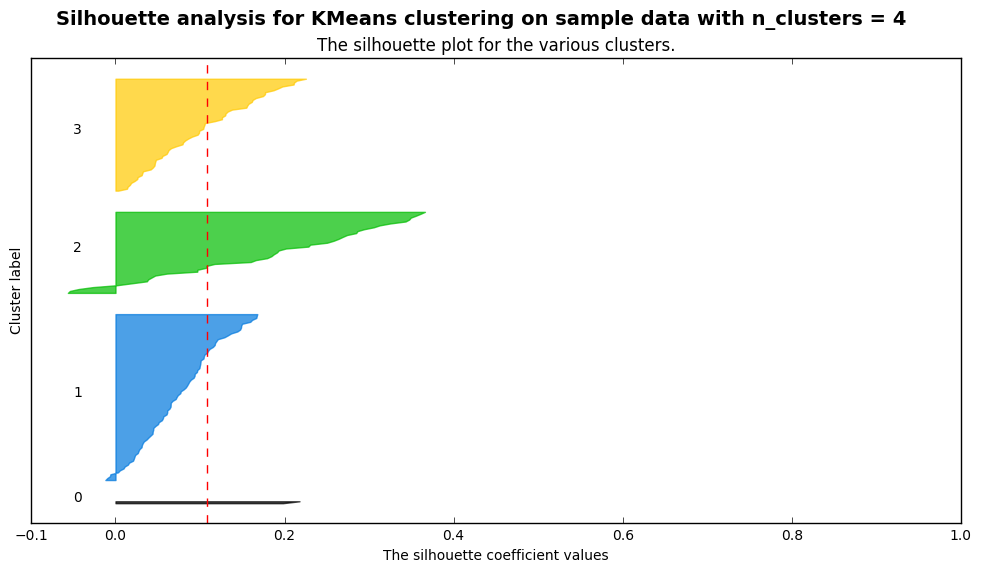

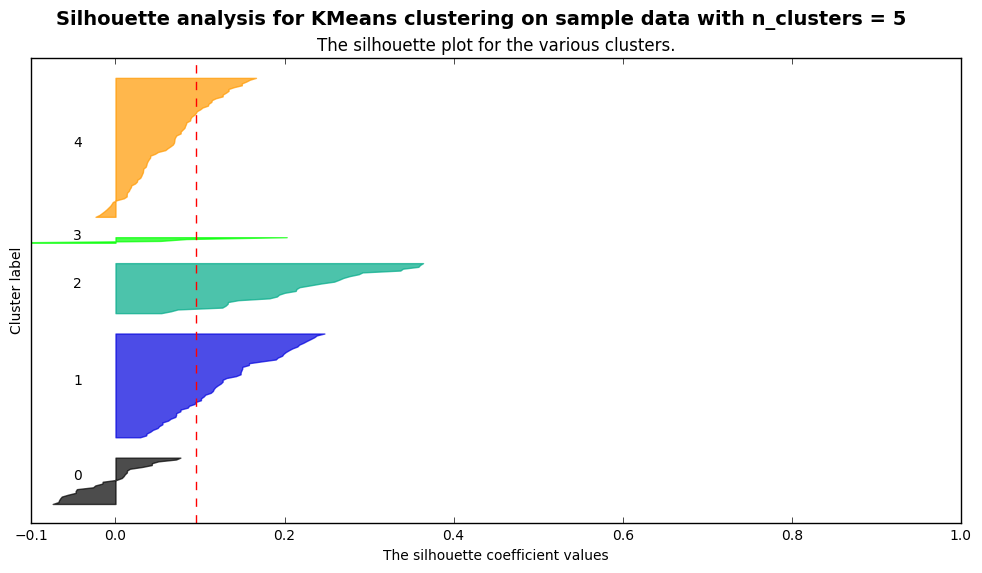

Number of clusters  Average silhouette score  \
0                   2                  0.314142   
1                   3                  0.114132   
2                   4                  0.107653   
3                   5                  0.095109   

                      Size of cluster  \
0                     {0: 47, 1: 144}   
1               {0: 54, 1: 44, 2: 93}   
2         {0: 2, 1: 87, 2: 43, 3: 59}   
3  {0: 26, 1: 57, 2: 28, 3: 4, 4: 76}   

                                  Label assignements  
0  [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...  
1  [1, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 1, ...  
2  [2, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 3, 1, 2, ...  
3  [0, 2, 1, 4, 4, 1, 4, 0, 0, 0, 4, 1, 1, 4, 2, ...

In [8]:
# Convert DataFrame to matrix
beforeCorrectedMat = beforeCorrectedForms.as_matrix()
# Standardise data
beforeCorrectedMat = preprocessing.scale(beforeCorrectedMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
beforeCorrectedResults = tryKmeans(beforeCorrectedMat)
# Format results as a DataFrame
beforeCorrectedResults = pd.DataFrame(data=beforeCorrectedResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
beforeCorrectedResults

Conclusion: Possible 2-clustering (17/01/2018)

Will split columns into 6 groups


FloatProgress(value=0.0, max=6.0)

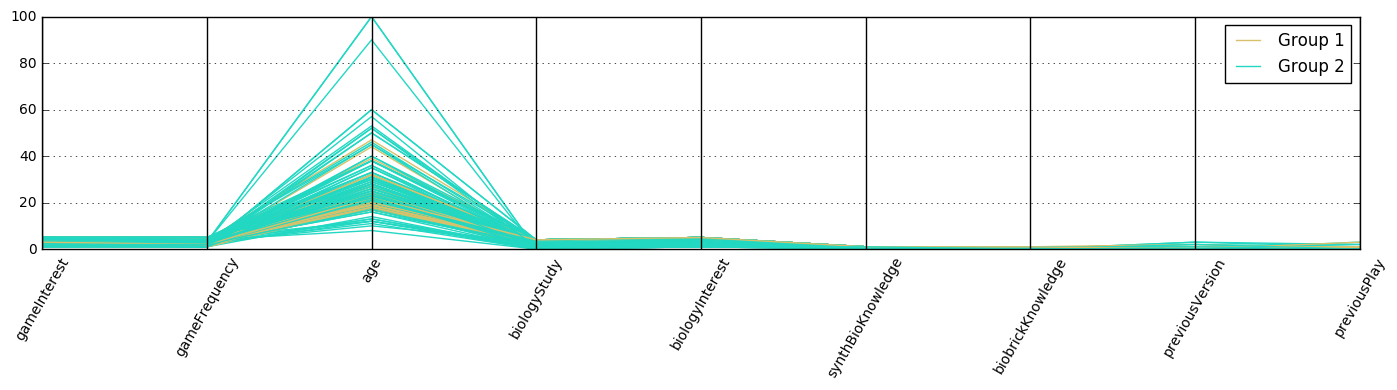

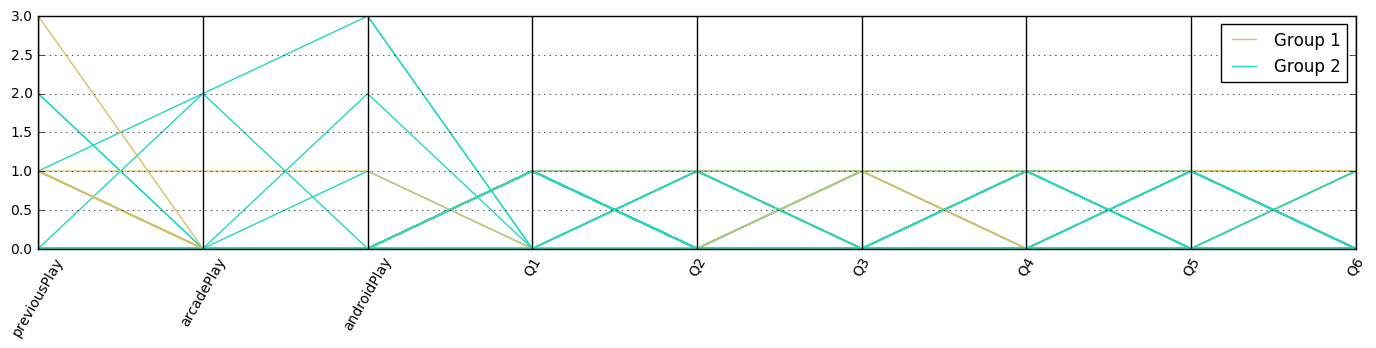

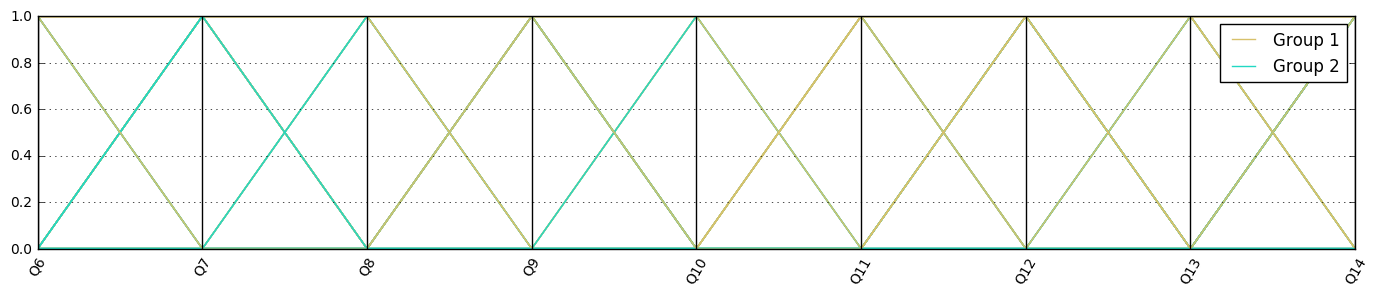

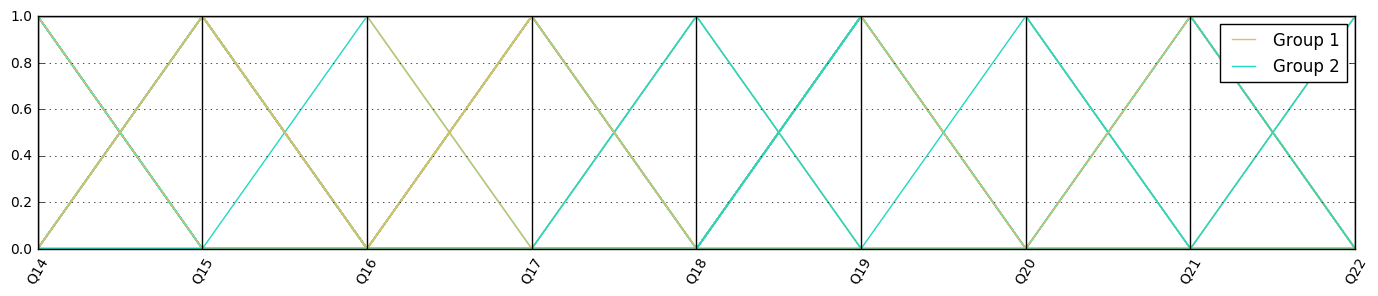

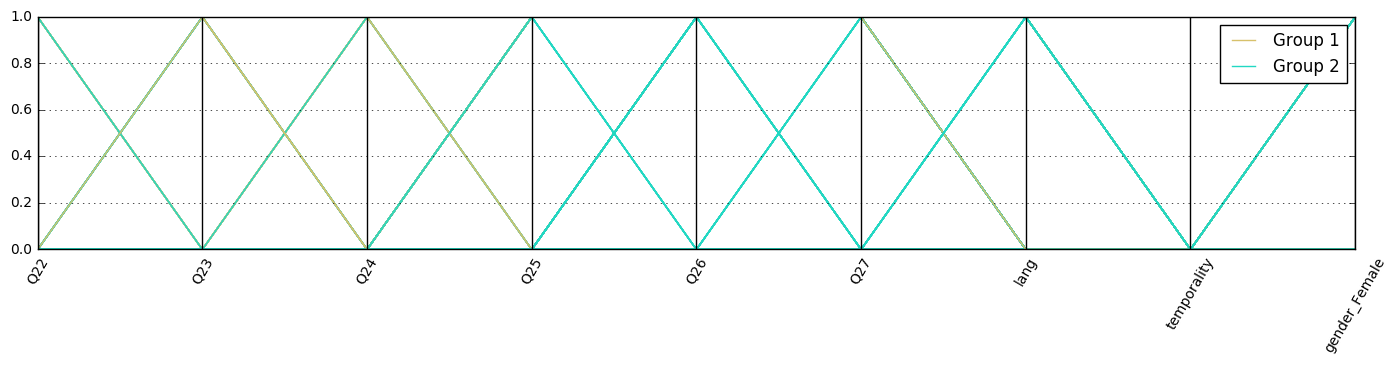

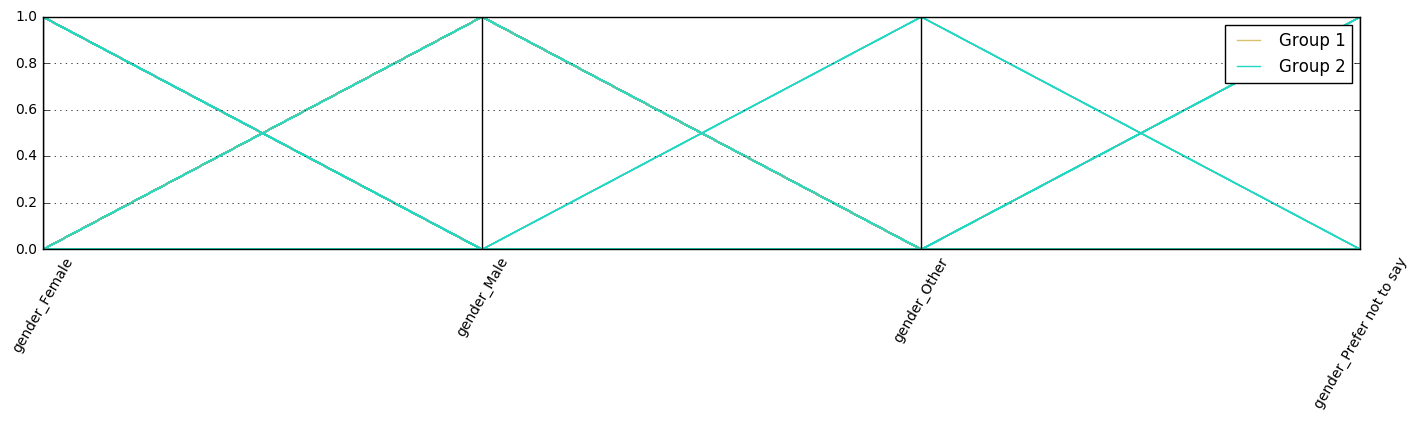

In [9]:
# Display parallel coordinates plot
assignements = detailsKmeans(beforeCorrectedForms, beforeCorrectedResults, 2, displayParallelCoord=True, clusterLabels=["Group 1", "Group 2"])

In [10]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(beforeCorrectedForms, beforeCorrectedResults, 2, "allScience")
correctAnswersByCluster

Cluster 0  Cluster 1
Q1    0.808511   0.458333
Q2    0.744681   0.111111
Q3    0.680851   0.062500
Q4    0.787234   0.145833
Q5    0.787234   0.131944
Q6    0.489362   0.020833
Q7    0.617021   0.055556
Q8    0.489362   0.034722
Q9    0.680851   0.048611
Q10   0.468085   0.034722
Q11   0.638298   0.027778
Q12   0.638298   0.076389
Q13   0.531915   0.034722
Q14   0.702128   0.097222
Q15   0.893617   0.069444
Q16   0.553191   0.006944
Q17   0.851064   0.034722
Q18   0.723404   0.020833
Q19   0.914894   0.118056
Q20   0.829787   0.090278
Q21   0.872340   0.090278
Q22   0.723404   0.069444
Q23   0.680851   0.111111
Q24   0.702128   0.104167
Q25   0.851064   0.305556
Q26   0.978723   0.527778
Q27   0.957447   0.486111

In [11]:
stats.ttest_ind(correctAnswersByCluster["Cluster 0"], correctAnswersByCluster["Cluster 1"])

Ttest_indResult(statistic=15.305461450301275, pvalue=6.6686249878246263e-21)

In [12]:
# Compute frequency of different levels of biology study for each group and each question
biologyStudyPerCluster = freqByCluster(beforeCorrectedForms, beforeCorrectedResults, 2, "biologyStudy")
biologyStudyPerCluster


Ttest_indResult(statistic=3.4379423530982463, pvalue=0.00072094568883294757)


Cluster 0  Cluster 1
0   0.000000   0.118056
1   0.042553   0.111111
2   0.212766   0.305556
3   0.382979   0.215278
4   0.361702   0.250000

In [13]:
# Compute frequency of different levels of biology interest for each group and each question
biologyInterestPerCluster = freqByCluster(beforeCorrectedForms, beforeCorrectedResults, 2, "biologyInterest")
biologyInterestPerCluster

Ttest_indResult(statistic=4.6267604586301072, pvalue=6.8814670284948311e-06)


Cluster 0  Cluster 1
1   0.000000   0.041667
2   0.000000   0.111111
3   0.106383   0.298611
4   0.297872   0.236111
5   0.595745   0.312500

In [14]:
# Compute score and compare clusters
beforeCorrectedForms["sum"] = beforeCorrectedForms.loc[:,"Q1":"Q27"].sum(axis=1)
scorePerCluster = freqByCluster(beforeCorrectedForms, beforeCorrectedResults, 2, "sum")
scorePerCluster

Ttest_indResult(statistic=29.042819394313184, pvalue=1.3186867439775581e-71)


Cluster 0  Cluster 1
0.0    0.000000   0.201389
1.0    0.000000   0.090278
2.0    0.000000   0.187500
3.0    0.000000   0.111111
4.0    0.000000   0.090278
5.0    0.000000   0.090278
6.0    0.000000   0.076389
7.0    0.000000   0.048611
8.0    0.000000   0.020833
9.0    0.000000   0.048611
10.0   0.000000   0.020833
11.0   0.000000   0.013889
12.0   0.021277   0.000000
13.0   0.085106   0.000000
14.0   0.042553   0.000000
15.0   0.085106   0.000000
16.0   0.042553   0.000000
17.0   0.085106   0.000000
18.0   0.085106   0.000000
19.0   0.042553   0.000000
20.0   0.085106   0.000000
21.0   0.063830   0.000000
22.0   0.021277   0.000000
23.0   0.127660   0.000000
24.0   0.021277   0.000000
25.0   0.063830   0.000000
26.0   0.106383   0.000000
27.0   0.021277   0.000000

Conclusion: Two clusters, with one small cluster of highly interested subjects with very high level of correct answers (and high score) and big cluster of average interest and low level of correct answers (and low score). (30/01/2018)

# Can the data be clustered according to the answers given to the after questionnaire?

## If scientific questions are coded by answers

C:\Users\Mikael\Anaconda3\envs\conda-env-python3-py\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


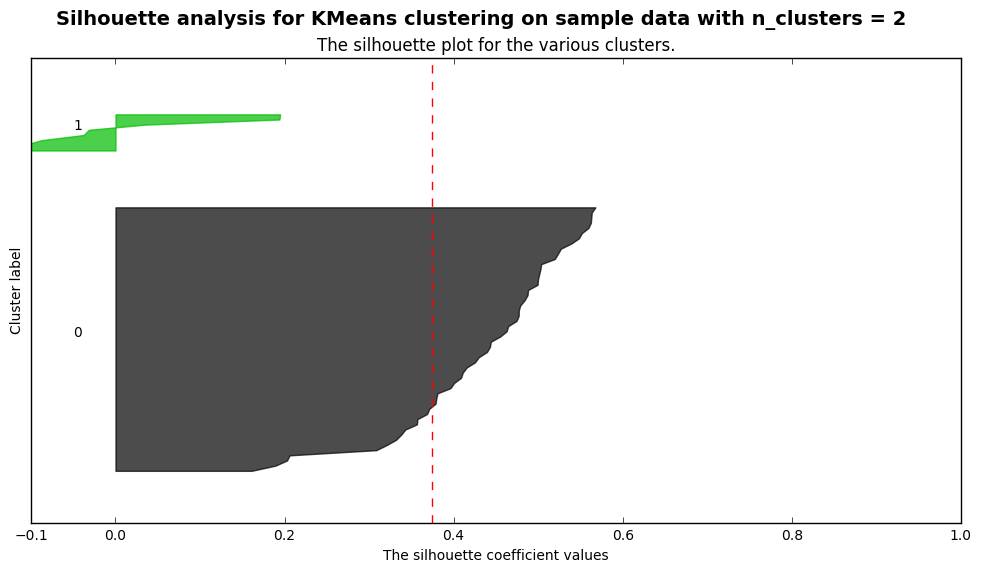

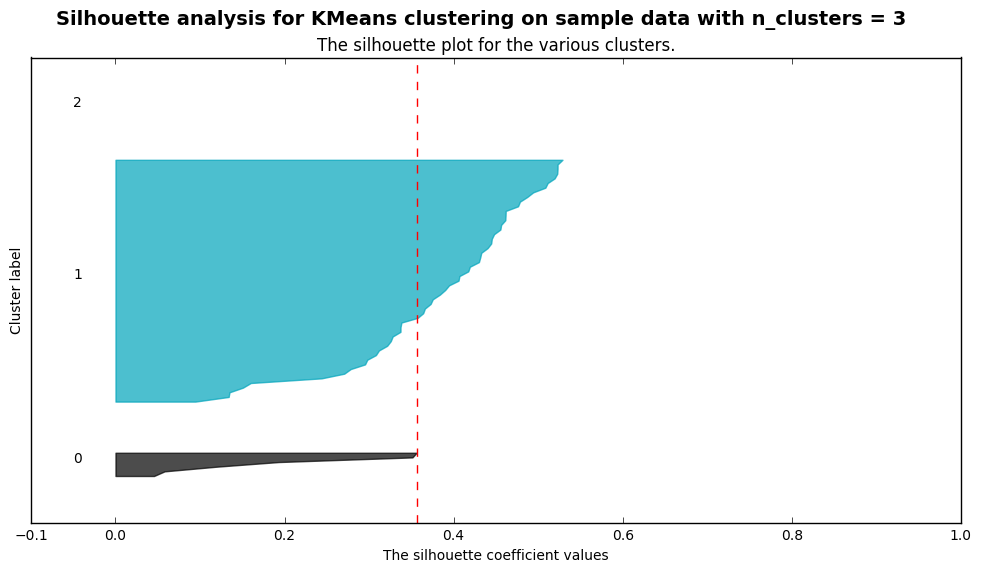

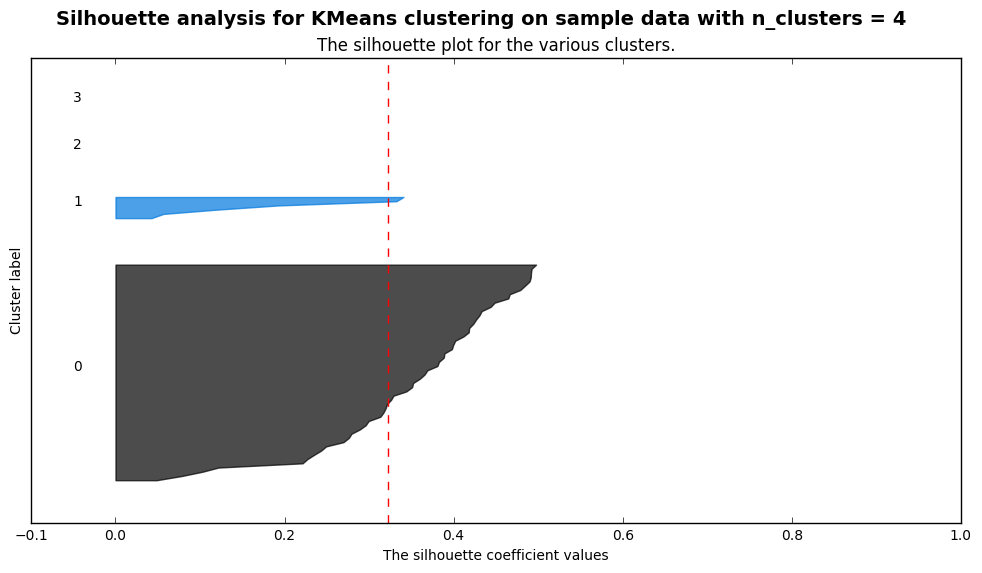

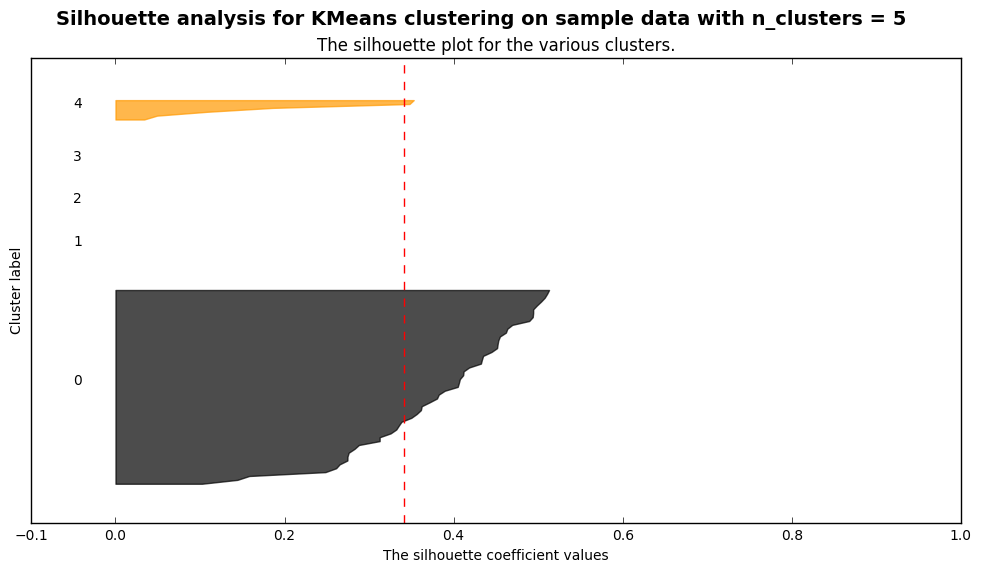

In [15]:
# Convert DataFrame to matrix
afterMat = afterForms.as_matrix()
# Standardise the data
afterMat = preprocessing.scale(afterMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
afterResults = tryKmeans(afterMat)
# Format results as a DataFrame
afterResults = pd.DataFrame(data=afterResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])

Conclusion: No interesting clustering (30/11/2017)

## If scientific questions are coded by correctedness

C:\Users\Mikael\Anaconda3\envs\conda-env-python3-py\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


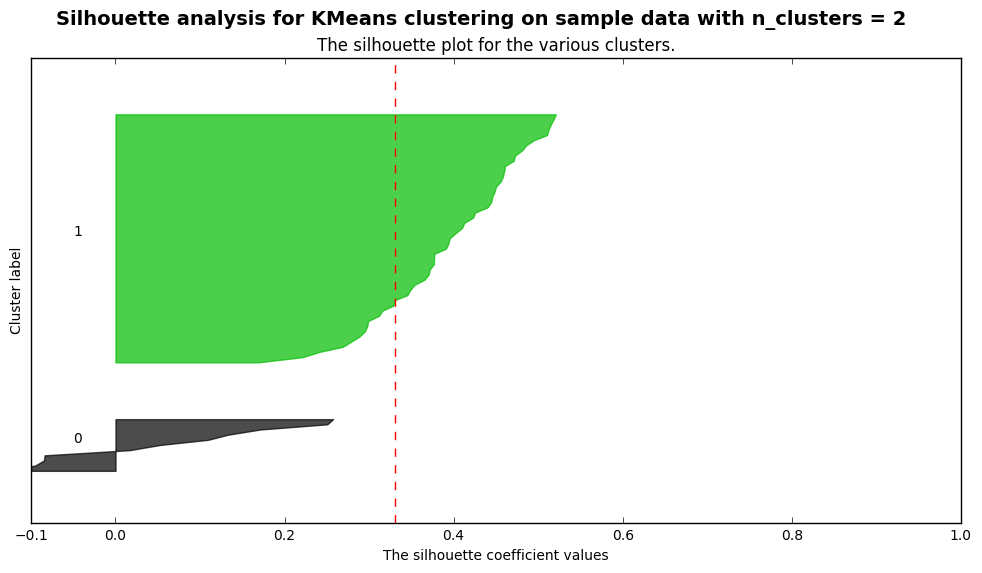

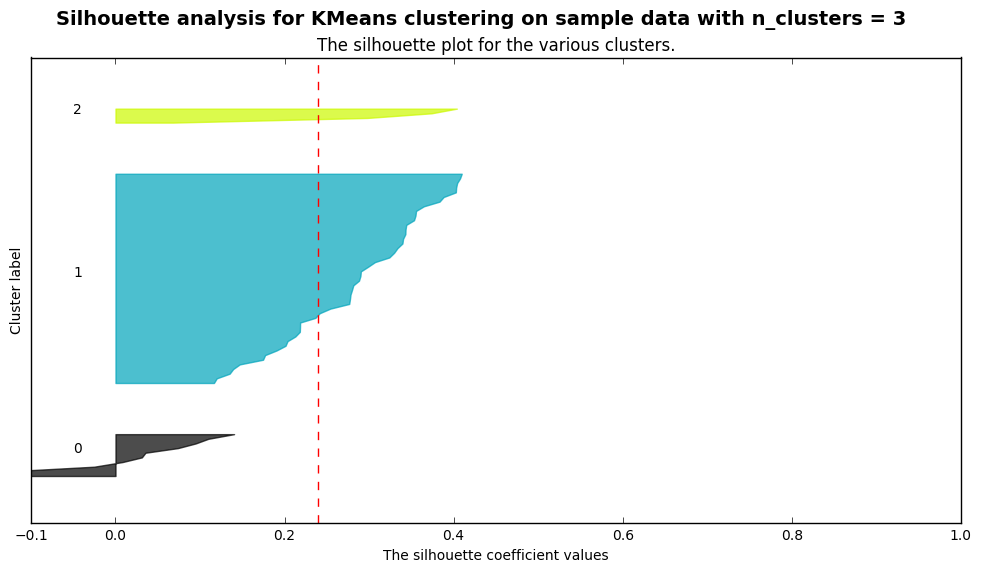

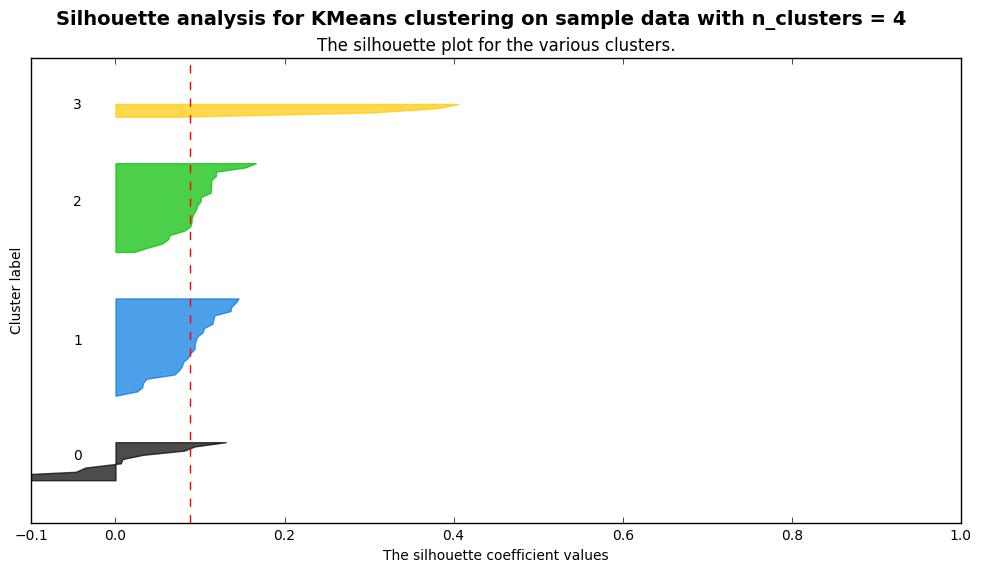

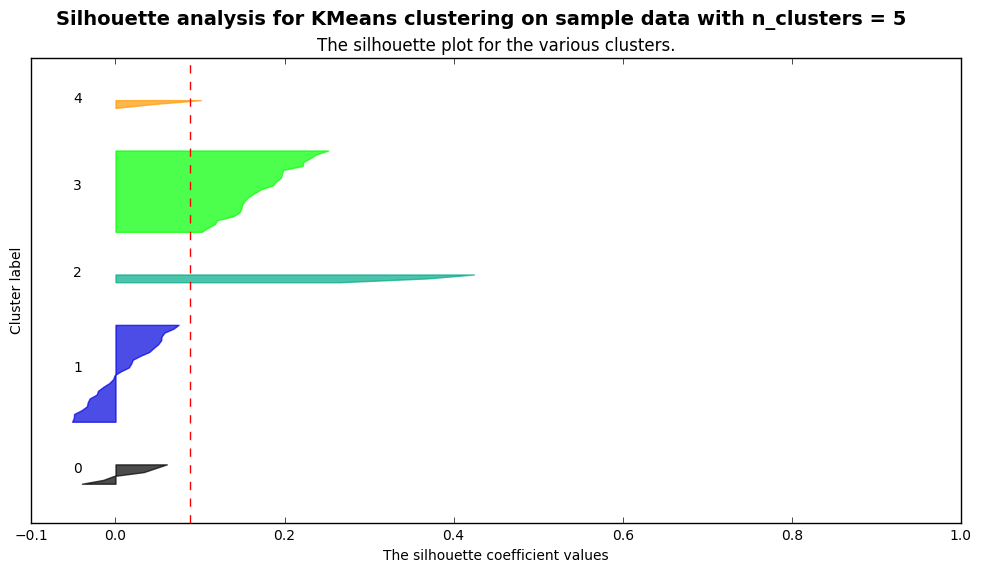

Number of clusters  Average silhouette score  \
0                   2                  0.330109   
1                   3                  0.239072   
2                   4                  0.088648   
3                   5                  0.088006   

                    Size of cluster  \
0                    {0: 11, 1: 49}   
1              {0: 10, 1: 46, 2: 4}   
2       {0: 10, 1: 24, 2: 22, 3: 4}   
3  {0: 6, 1: 26, 2: 3, 3: 22, 4: 3}   

                                  Label assignements  
0  [1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, ...  
1  [1, 0, 1, 1, 0, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, ...  
2  [1, 0, 2, 2, 0, 2, 2, 2, 2, 3, 1, 0, 1, 0, 1, ...  
3  [3, 0, 1, 1, 0, 1, 1, 1, 1, 4, 3, 0, 3, 1, 1, ...

In [16]:
# Convert DataFrame to matrix
afterCorrectedMat = afterCorrectedForms.as_matrix()
# Standardise the data
afterCorrectedMat = preprocessing.scale(afterCorrectedMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
afterCorrectedResults = tryKmeans(afterCorrectedMat)
# Format results as a DataFrame
afterCorrectedResults = pd.DataFrame(data=afterCorrectedResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
afterCorrectedResults

Conclusion: No interesting clustering (16/01/2018)

# Can the data be clustered according to the answers given to the questionnaire?

## If scientific questions are coded by answers

### If only before and after questionnaires are used

C:\Users\Mikael\Anaconda3\envs\conda-env-python3-py\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


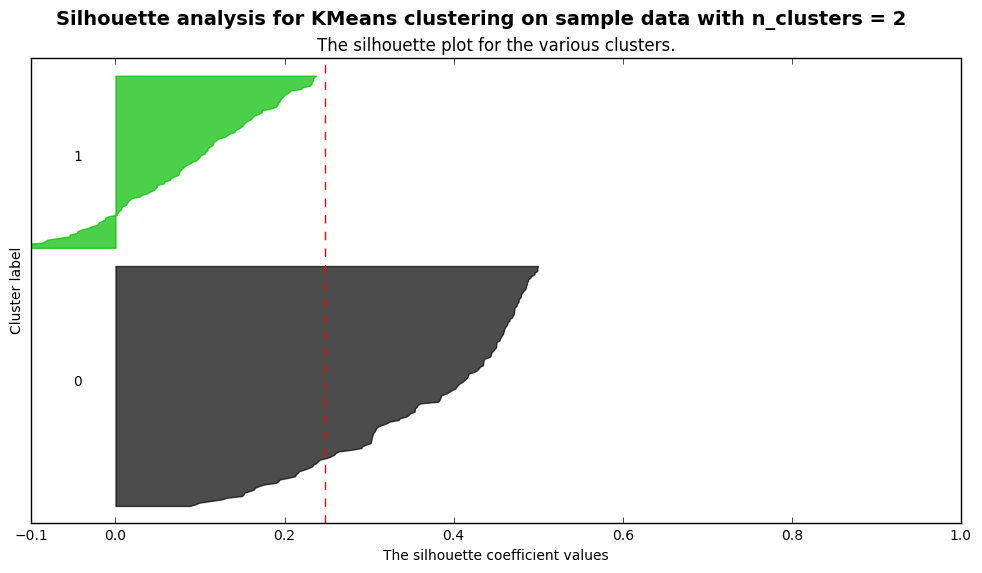

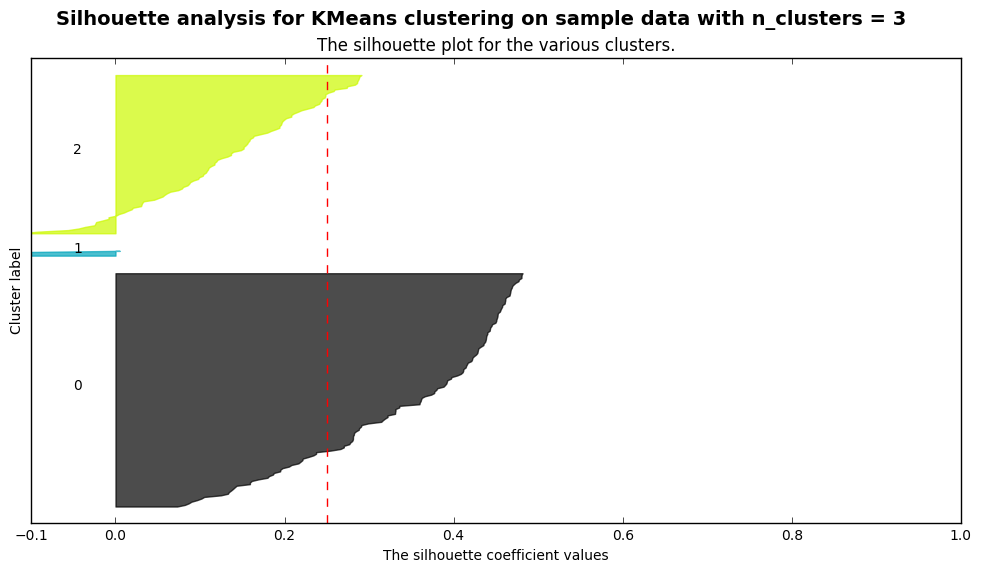

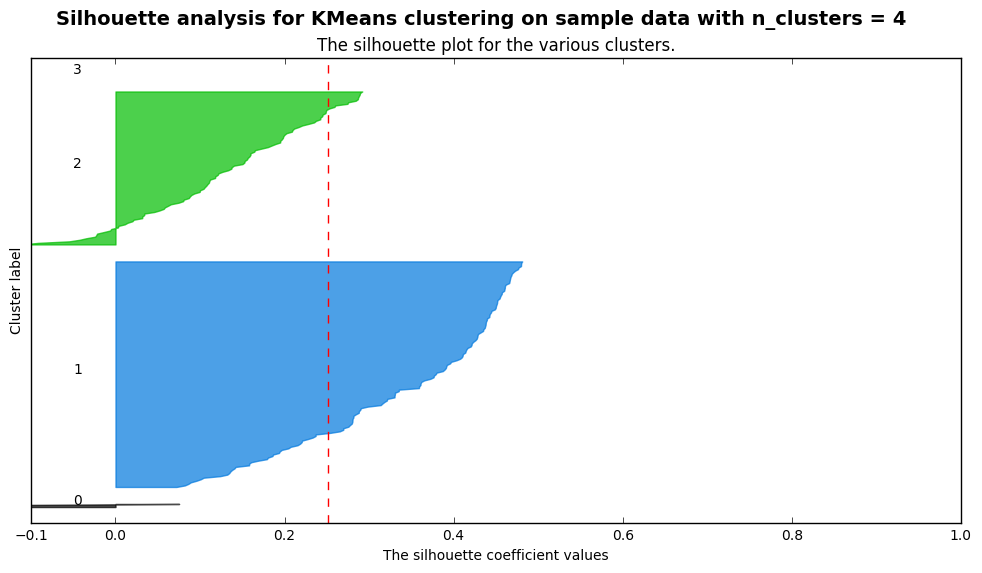

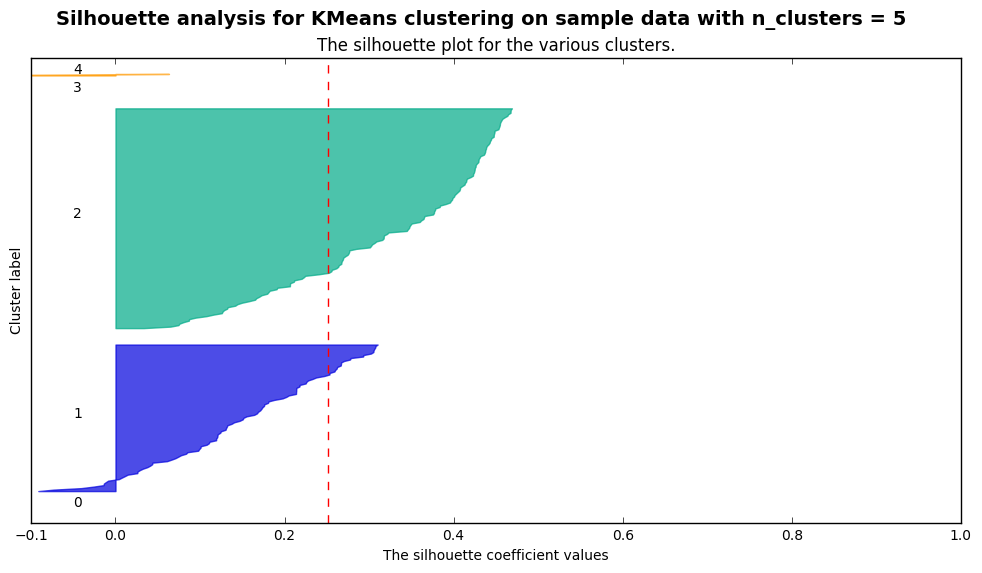

Number of clusters  Average silhouette score  \
0                   2                  0.247737   
1                   3                  0.250214   
2                   4                  0.251218   
3                   5                  0.250797   

                     Size of cluster  \
0                   {0: 146, 1: 105}   
1             {0: 147, 1: 4, 2: 100}   
2       {0: 3, 1: 147, 2: 100, 3: 1}   
3  {0: 1, 1: 99, 2: 148, 3: 1, 4: 2}   

                                  Label assignements  
0  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
3  [1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...

In [17]:
# Convert DataFrame to matrix
defMat = defForms.drop("temporality", axis=1).as_matrix()
# Standardise data
defMat = preprocessing.scale(defMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
defResults = tryKmeans(defMat)
# Format results as a DataFrame
defResults = pd.DataFrame(data=defResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
defResults

Conclusion: The data could be clustered in two groups
Note: The silhouette coefficient probably never goes very high because of the binary aspect of most of the data (30/11/2017)

Hypothesis: The two groups identified by the clustering algorithm correspond to the "before" and "after" questionnaires.
Note: The temporality feature was not included in the clustering algorithm

Will split columns into 20 groups


FloatProgress(value=0.0, max=20.0)

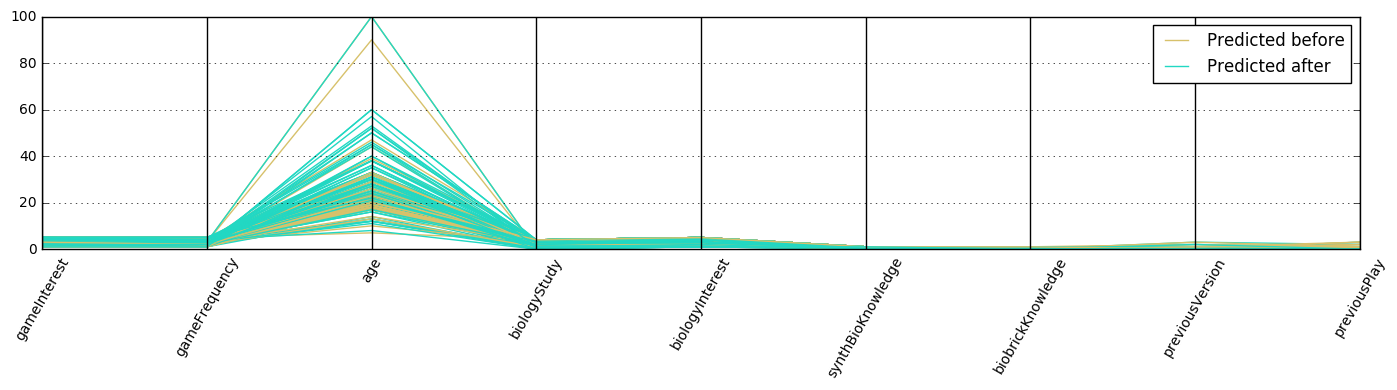

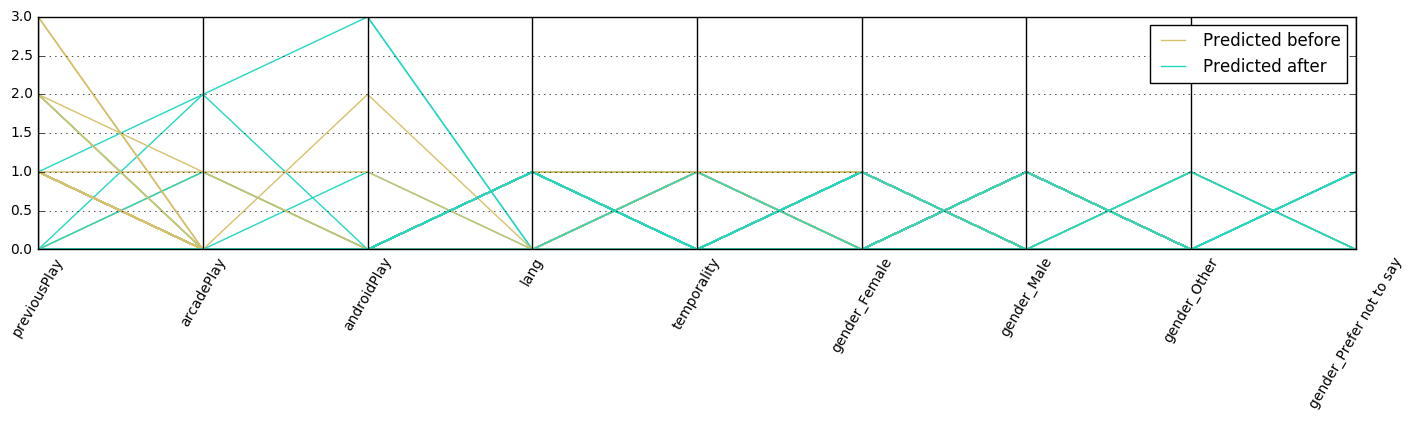

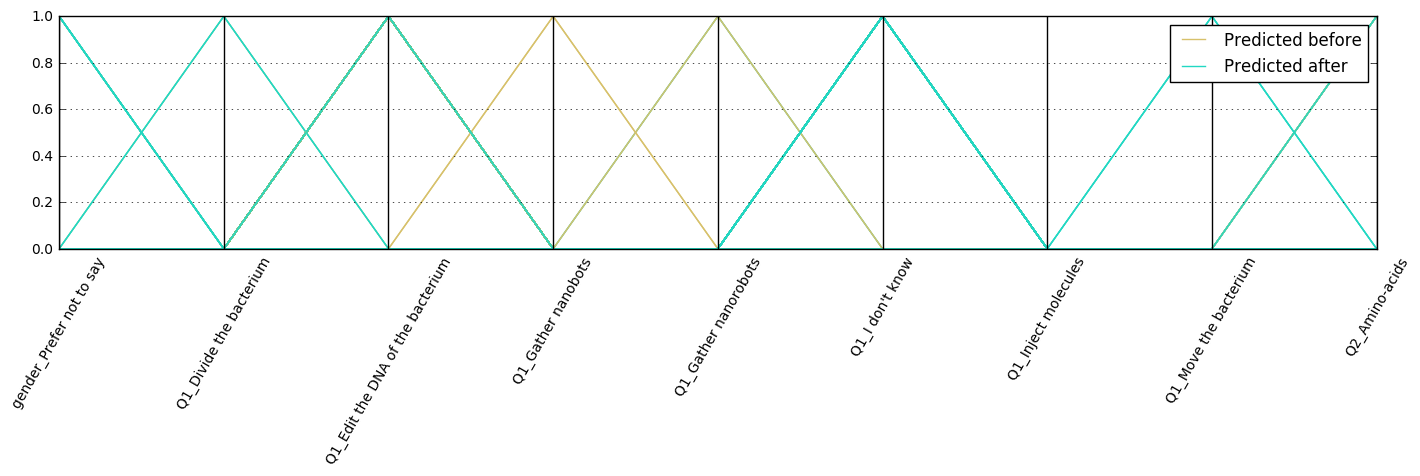

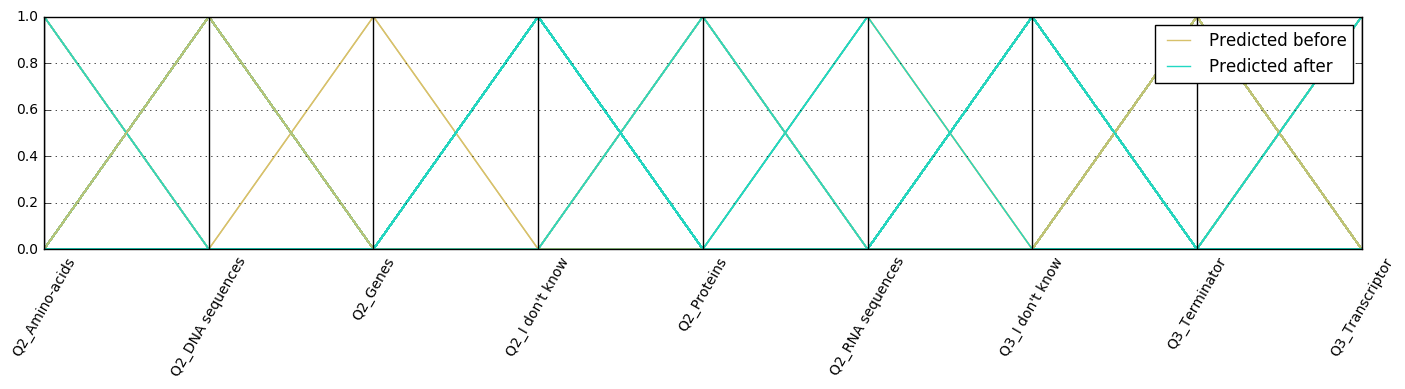

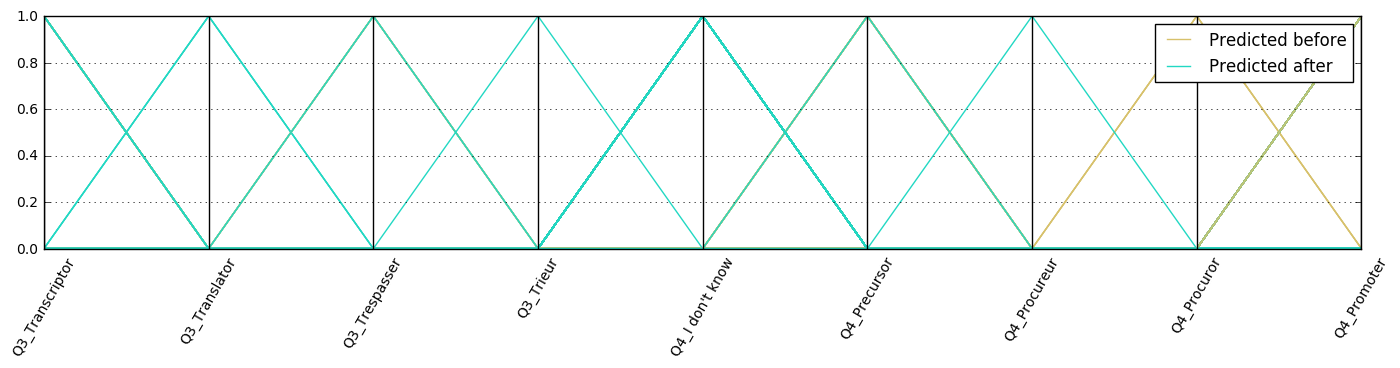

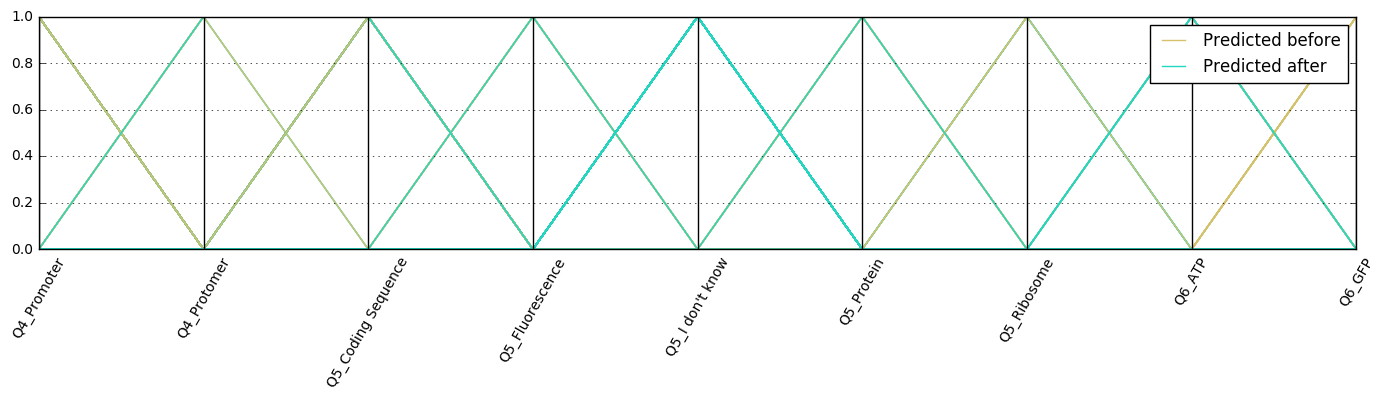

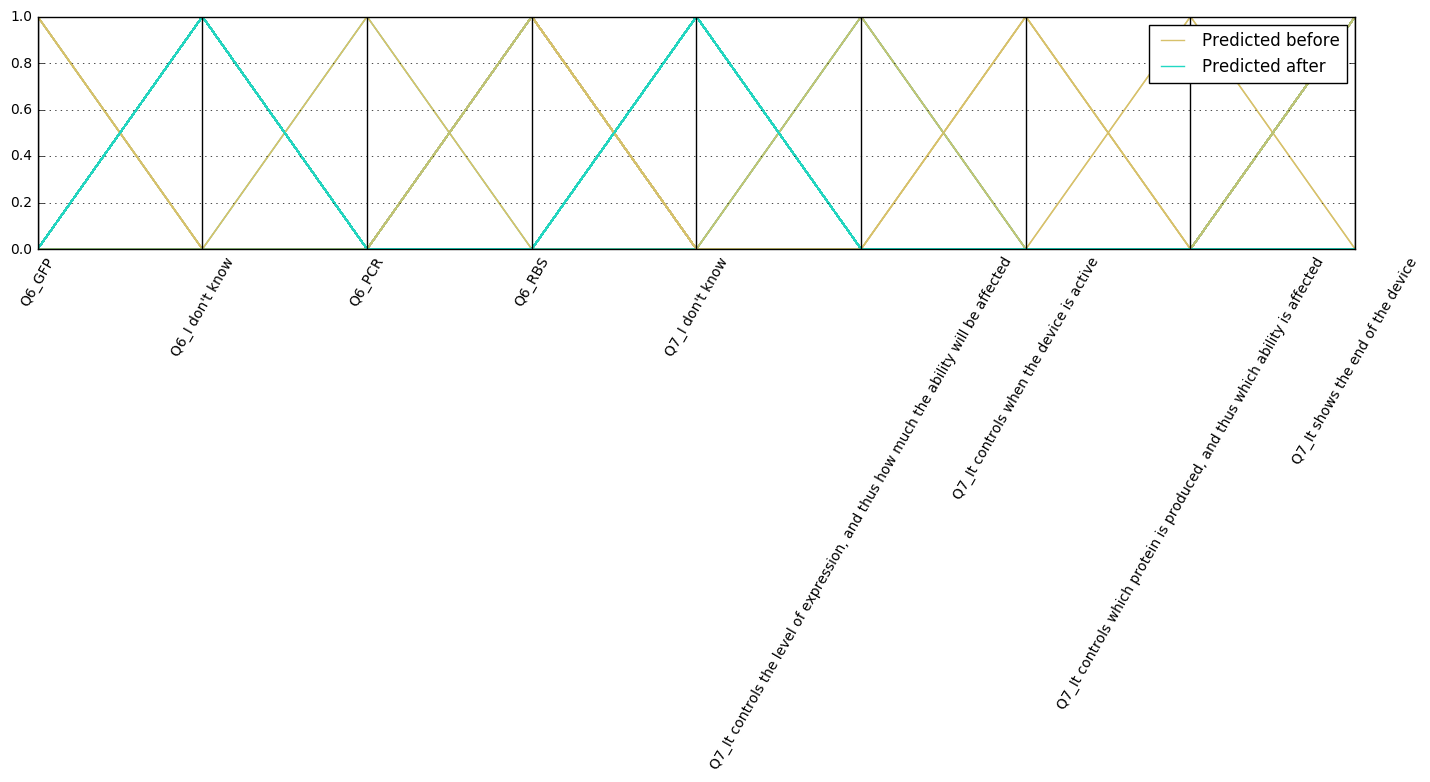

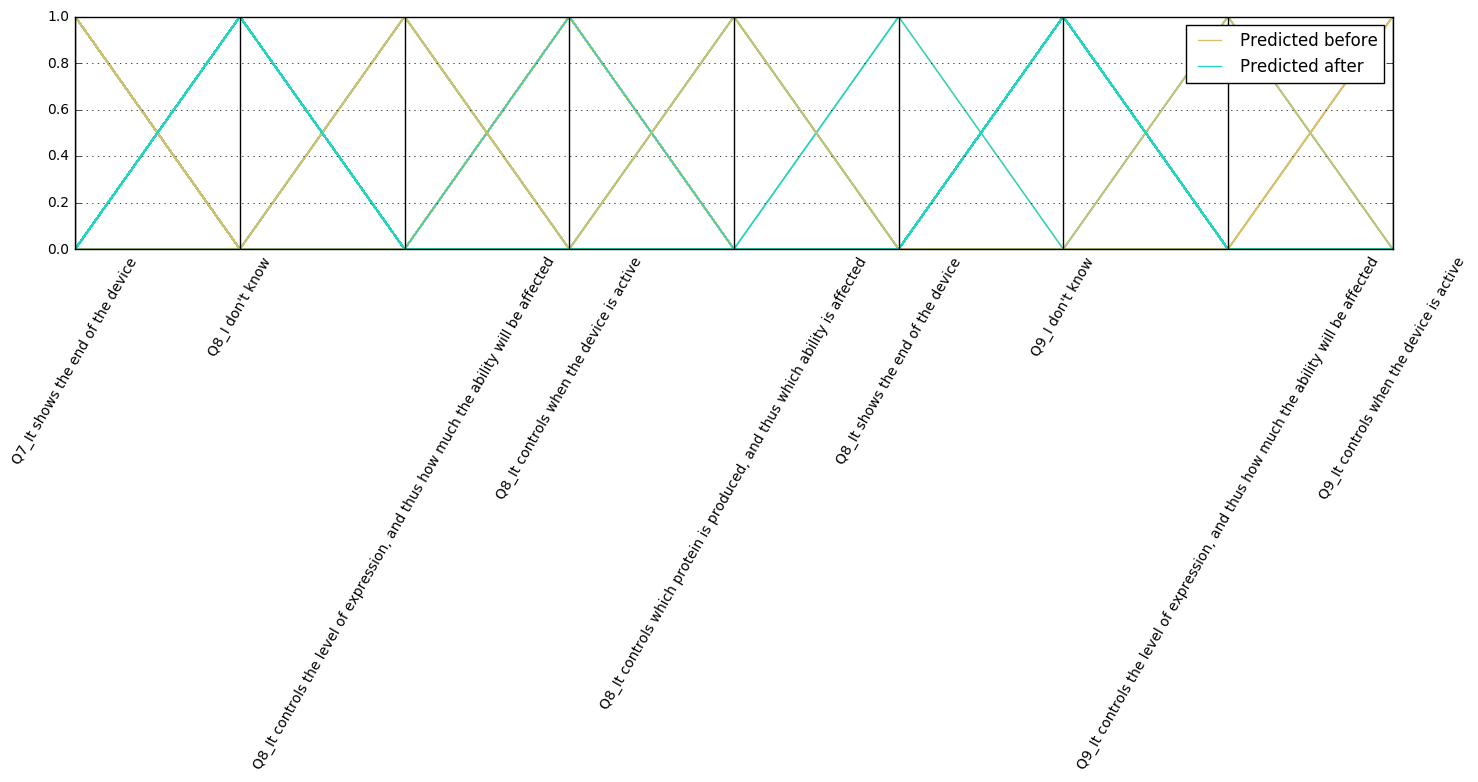

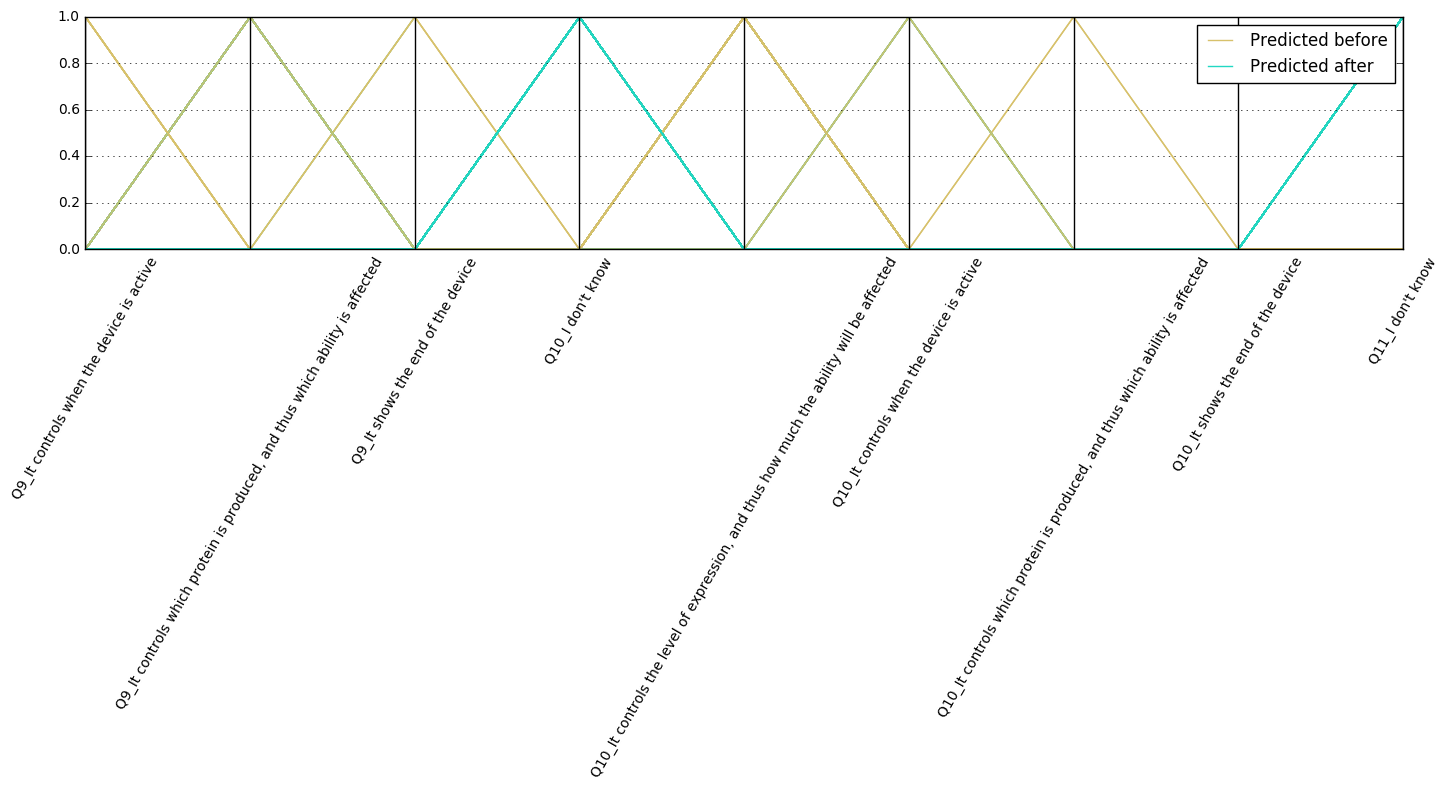

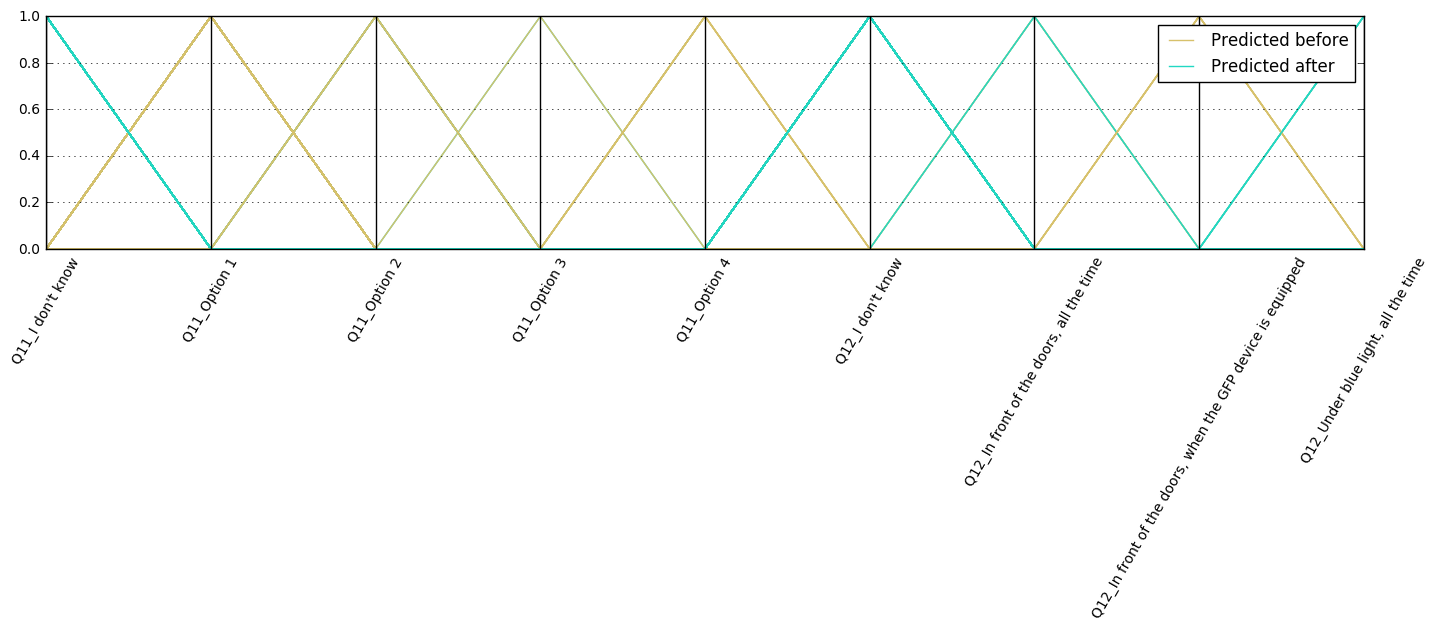

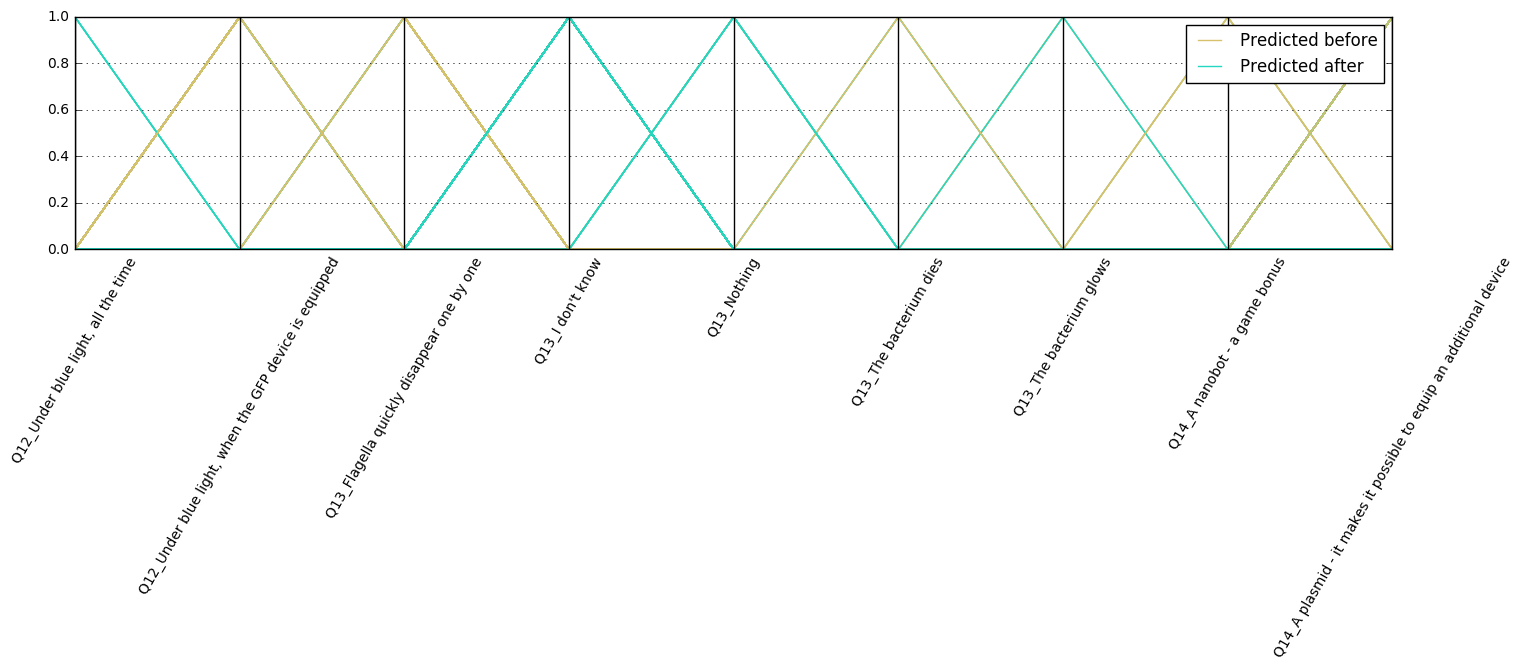

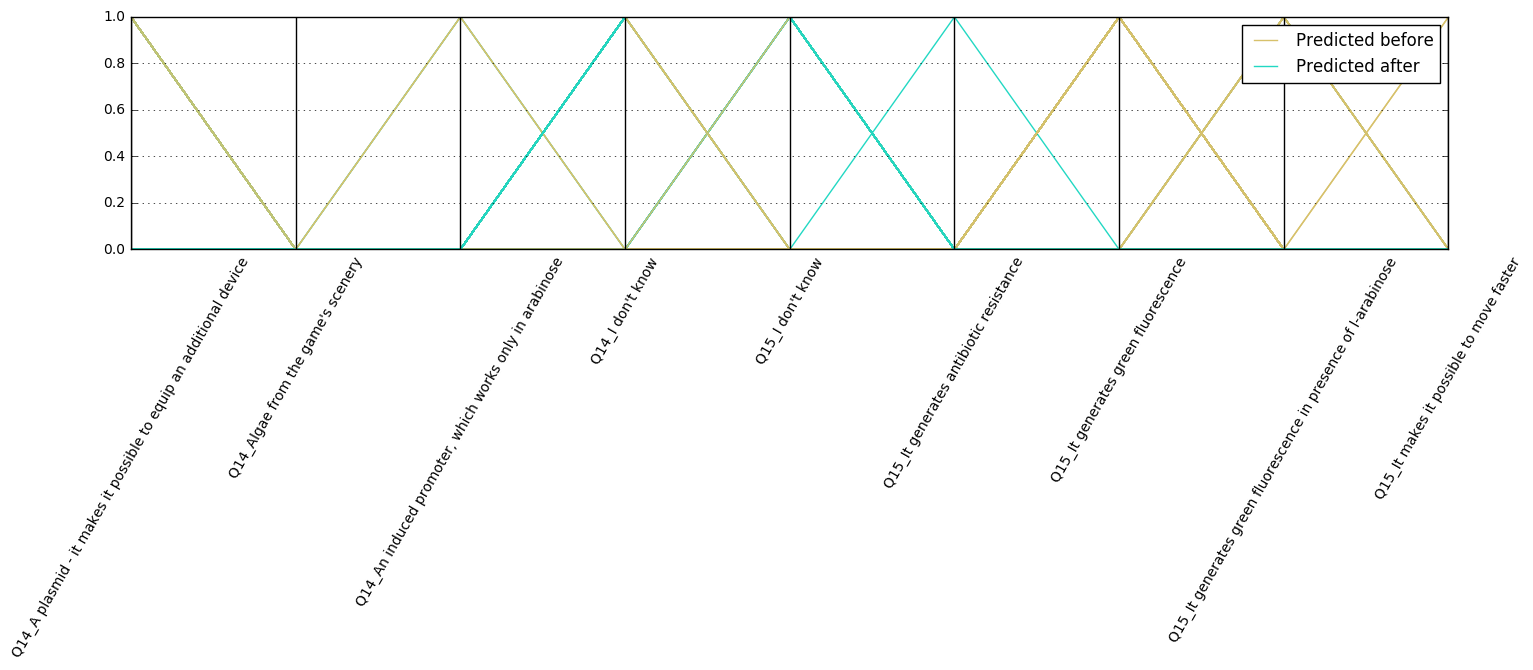

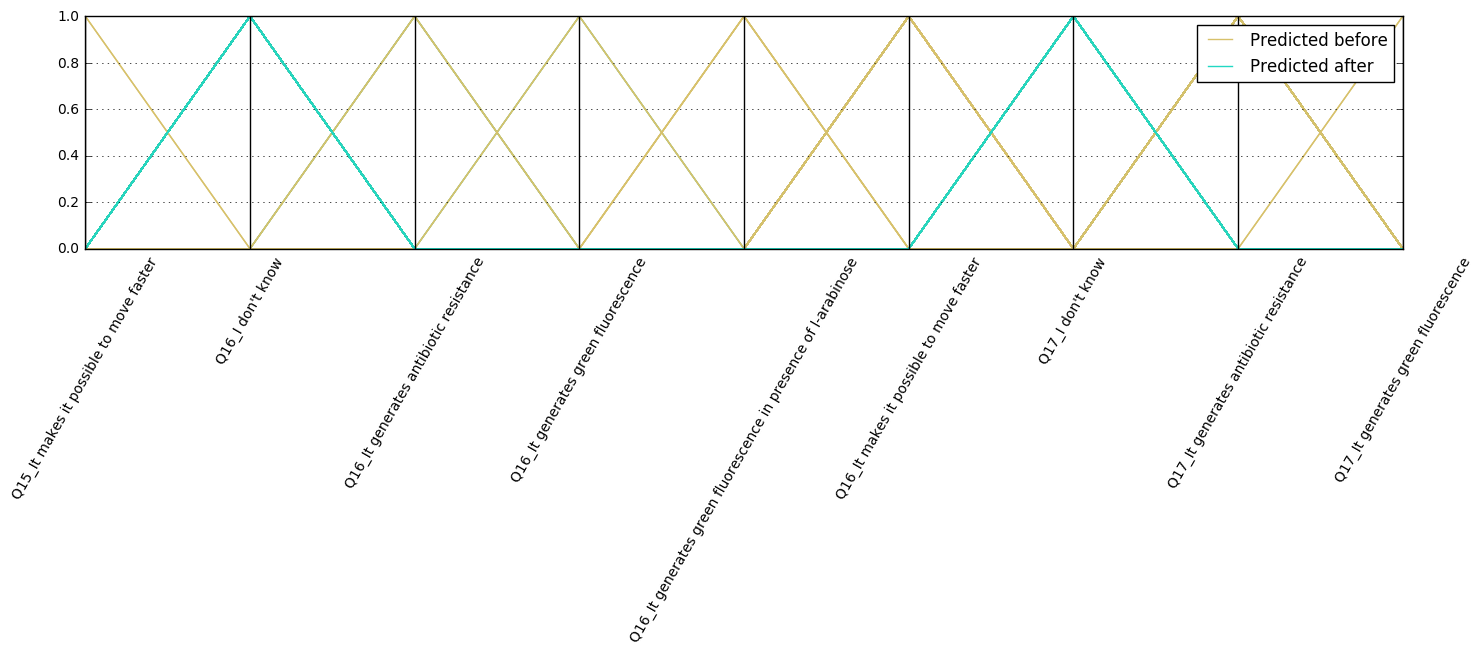

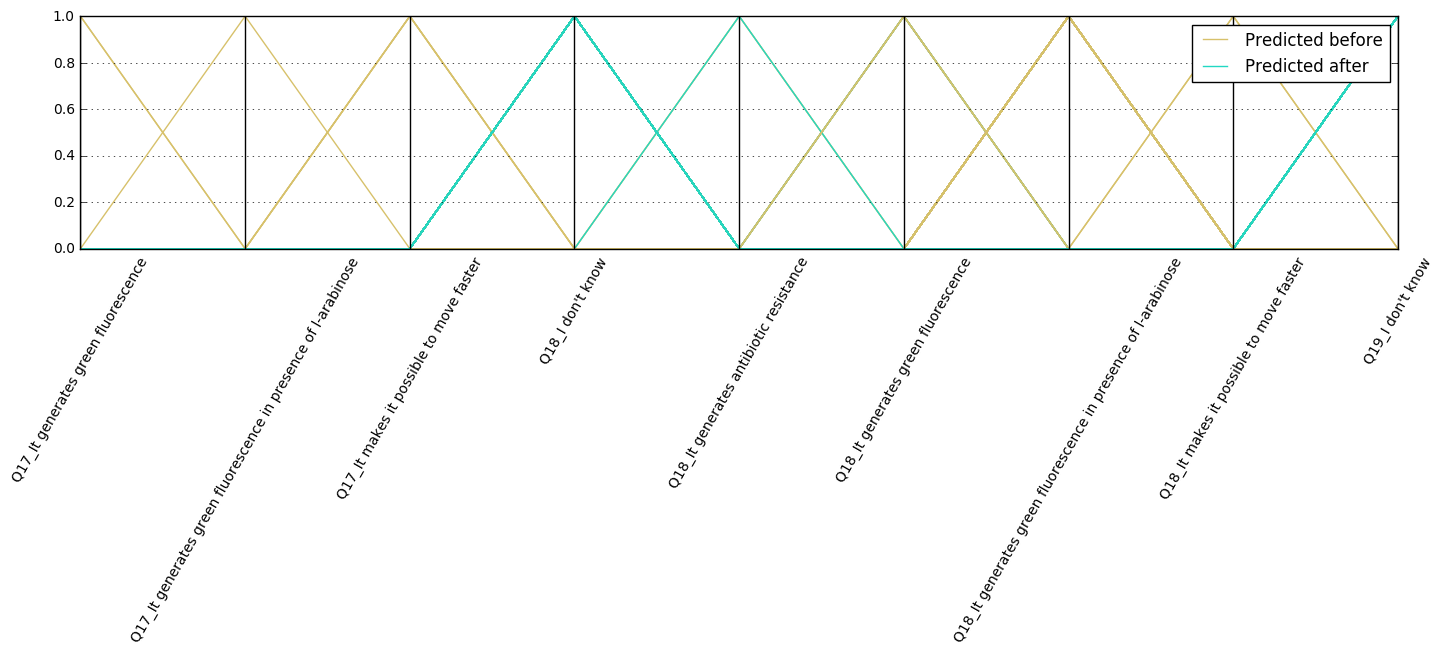

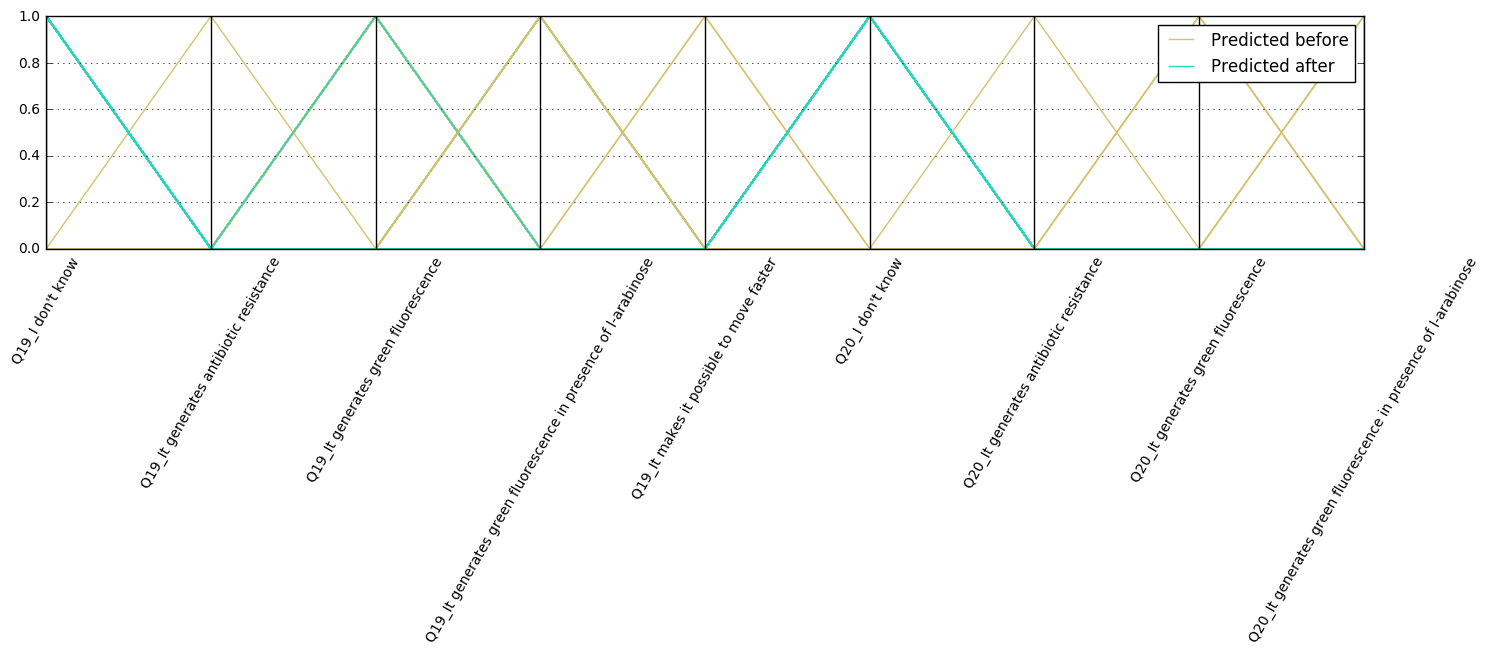

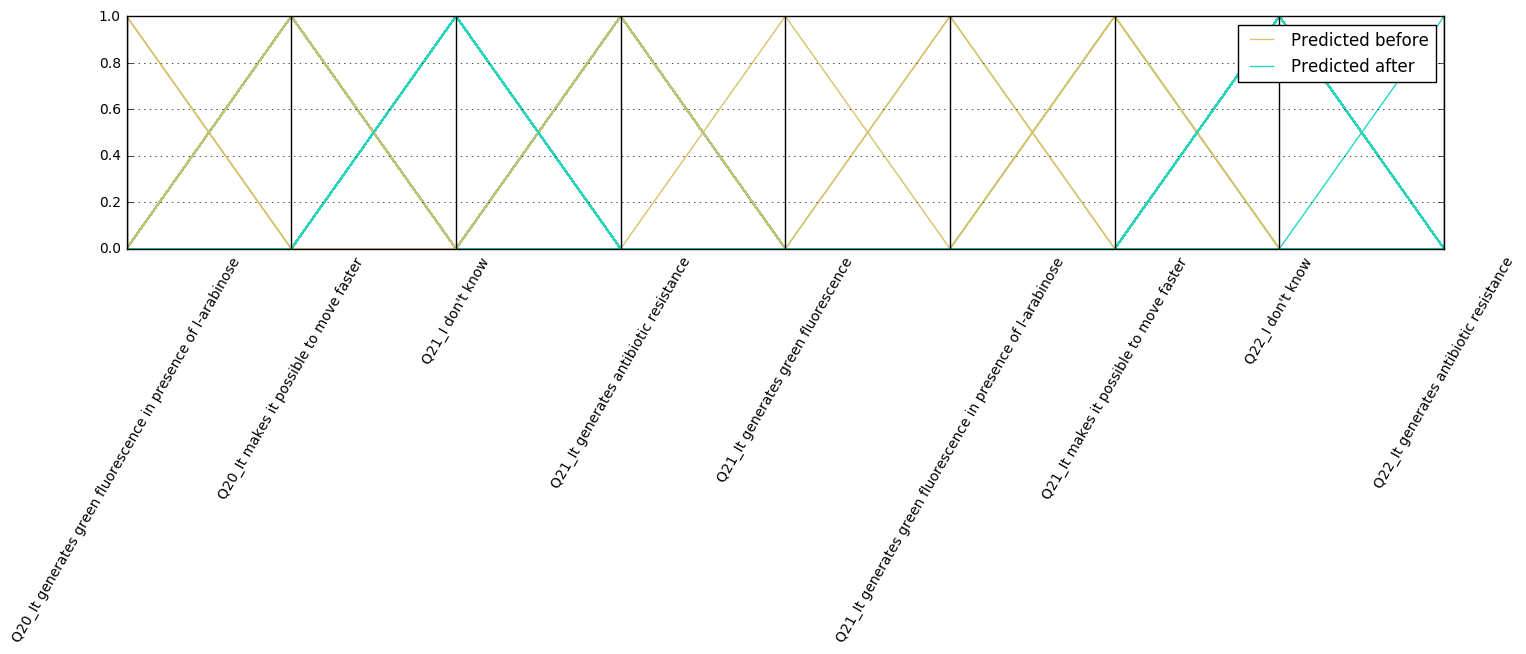

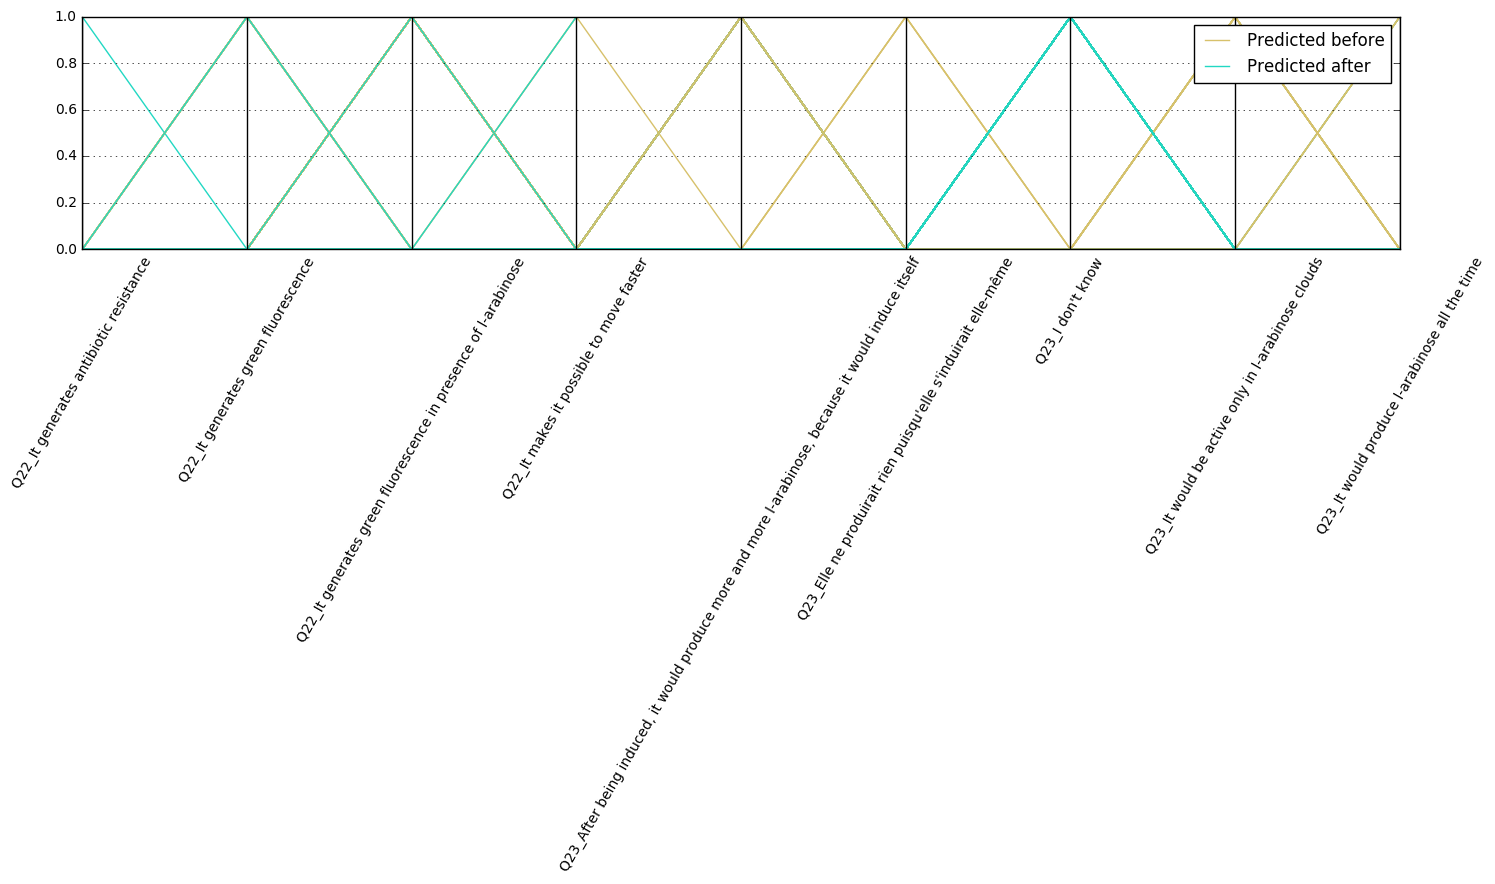

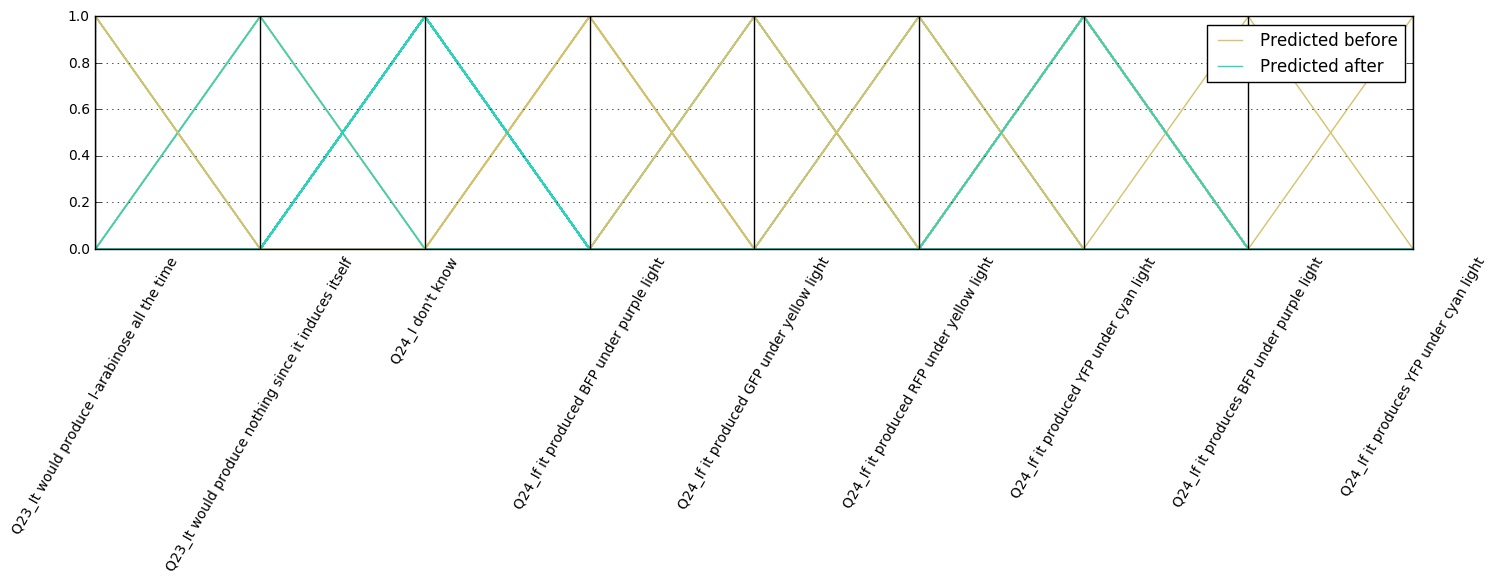

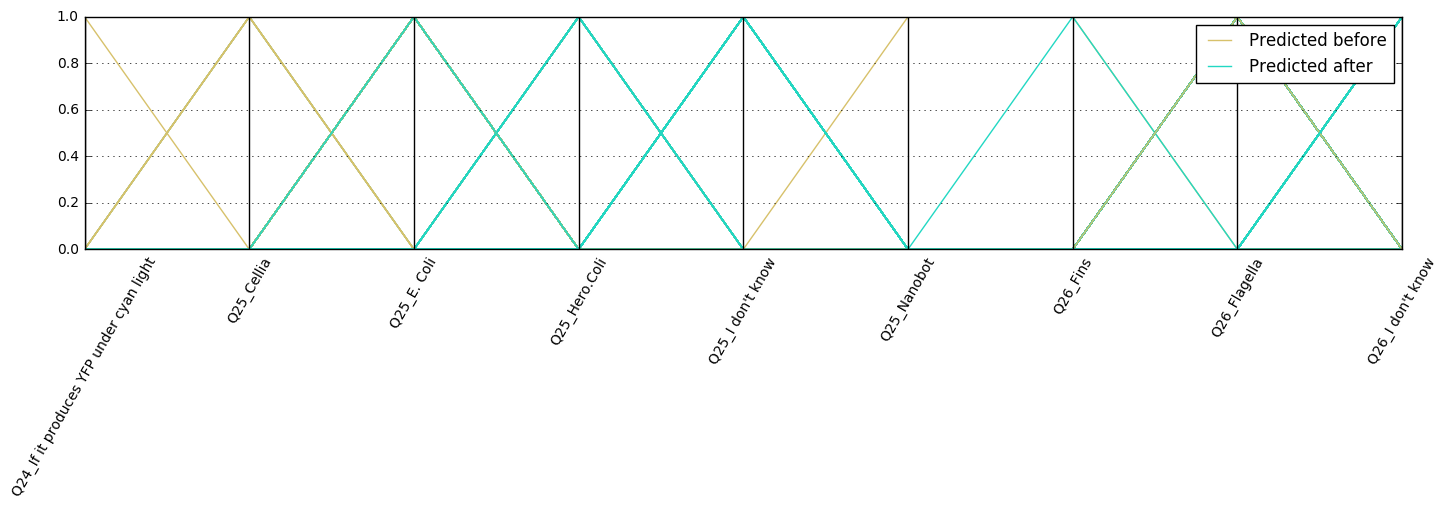

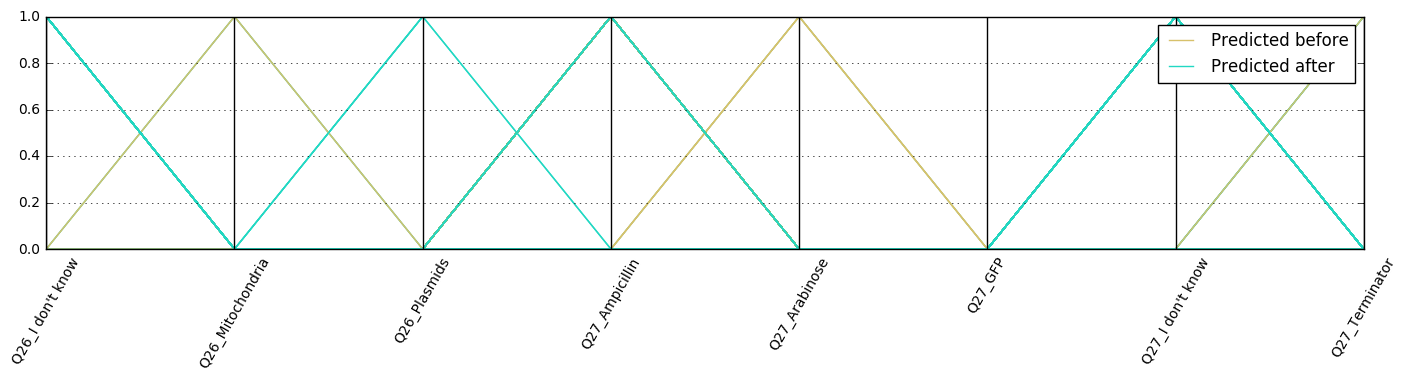

Predicted before  Predicted after
Actual after                140               51
Actual before                 6               54

In [18]:
# Display parallel coordinates plot and confusion matrix
assignements = detailsKmeans(defForms, defResults, 2, displayParallelCoord=True, clusterLabels=["Predicted before", "Predicted after"])
assignements = pd.concat([assignements, defForms["temporality"]], axis=1, join='inner')
defConfusionMat = confusion_matrix(list(assignements["temporality"]), list(assignements["Index of cluster"]))
defConfusionMat = pd.DataFrame(data = defConfusionMat, columns=["Predicted before", "Predicted after"], index = ["Actual after", "Actual before"])
defConfusionMat

Conclusion: Hypothesis verified. Parallel coordinates plot is not very informative because of the high number of features and the high proportion of binary features, use only for data exploration (30/12/2017)
Would be interesting to see if those that are predicted before while they are after share specific characteristics. (16/01/2018)

### If all questionnaires are used

C:\Users\Mikael\Anaconda3\envs\conda-env-python3-py\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


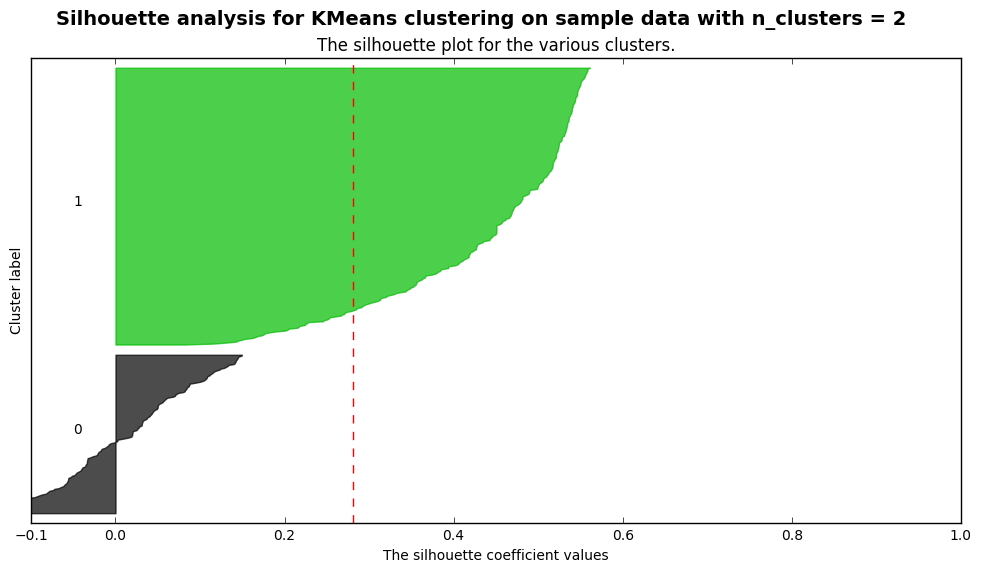

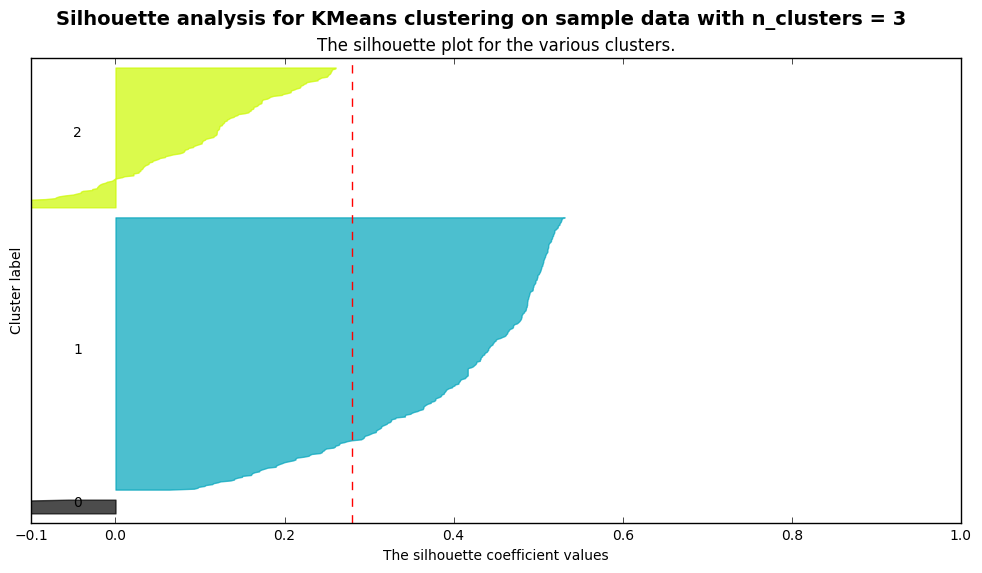

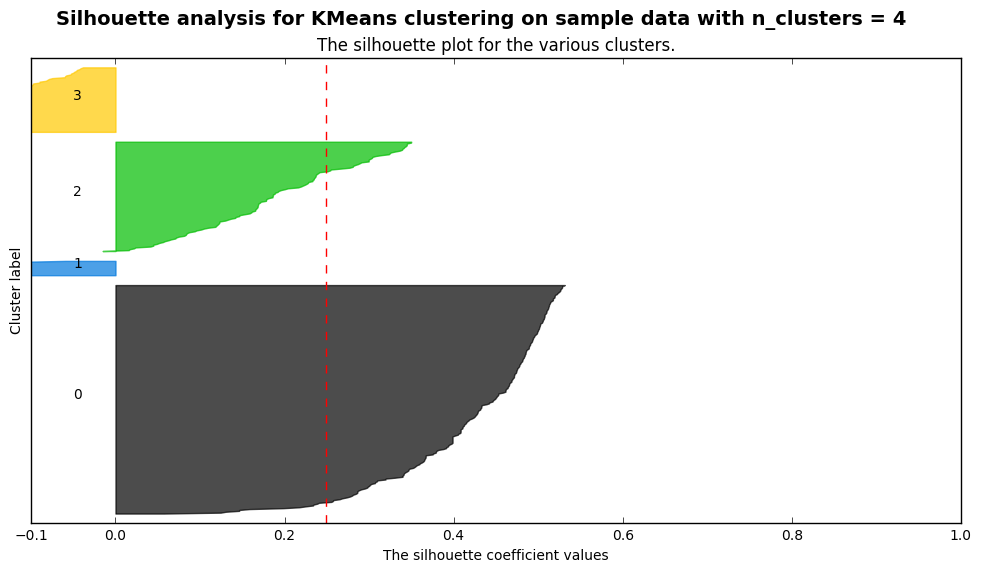

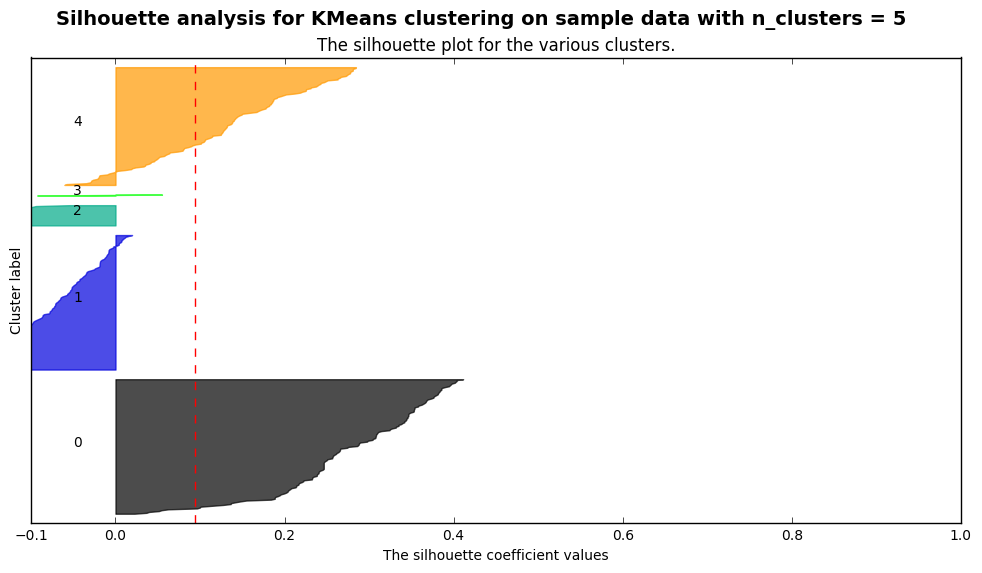

Number of clusters  Average silhouette score  \
0                   2                  0.280861   
1                   3                  0.279439   
2                   4                  0.248589   
3                   5                  0.093649   

                         Size of cluster  \
0                       {0: 171, 1: 298}   
1                {0: 16, 1: 299, 2: 154}   
2         {0: 256, 1: 17, 2: 123, 3: 73}   
3  {0: 154, 1: 154, 2: 24, 3: 2, 4: 135}   

                                  Label assignements  
0  [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
1  [2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
2  [2, 2, 2, 2, 0, 0, 0, 0, 3, 0, 0, 3, 3, 3, 0, ...  
3  [4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...

In [19]:
# Convert DataFrame to matrix
allMat = allForms.drop("temporality", axis=1).as_matrix()
# Standardise data
allMat = preprocessing.scale(allMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
allResults = tryKmeans(allMat)
# Format results as a DataFrame
allResults = pd.DataFrame(data=allResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
allResults

Conclusion: No interesting clustering (16/01/2018)

In [20]:
assignements = detailsKmeans(allForms, allResults, 2)
assignements = pd.concat([assignements, allForms["temporality"]], axis=1, join='inner')
defConfusionMat = confusion_matrix(list(assignements["temporality"]), list(assignements["Index of cluster"]))
defConfusionMat = pd.DataFrame(data = defConfusionMat, columns=["Predicted undefined", "Predicted before", "Predicted after"], index = ["Actual undefined", "Actual after", "Actual before"])
defConfusionMat.drop("Predicted undefined", axis=1, inplace=True)
defConfusionMat

Predicted before  Predicted after
Actual undefined                64              154
Actual after                    53              138
Actual before                   54                6

Conclusion: Compared to previous test, the undefined class is too big. (16/01/2018)

TODO RAPHAEL : Manually check the undefined temporalities

## If scientific questions are coded by correctedness

### If only before and after questionnaires are used

C:\Users\Mikael\Anaconda3\envs\conda-env-python3-py\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


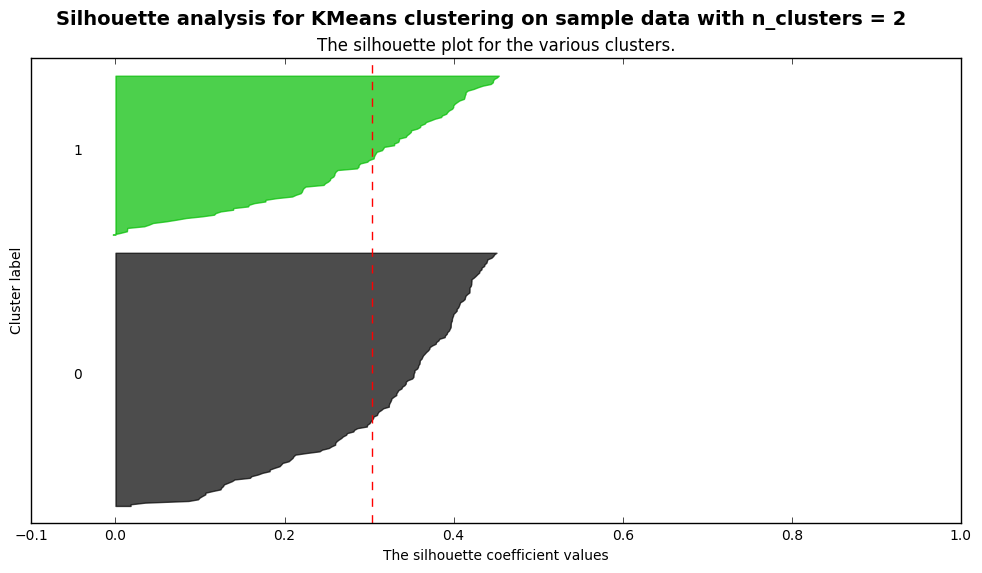

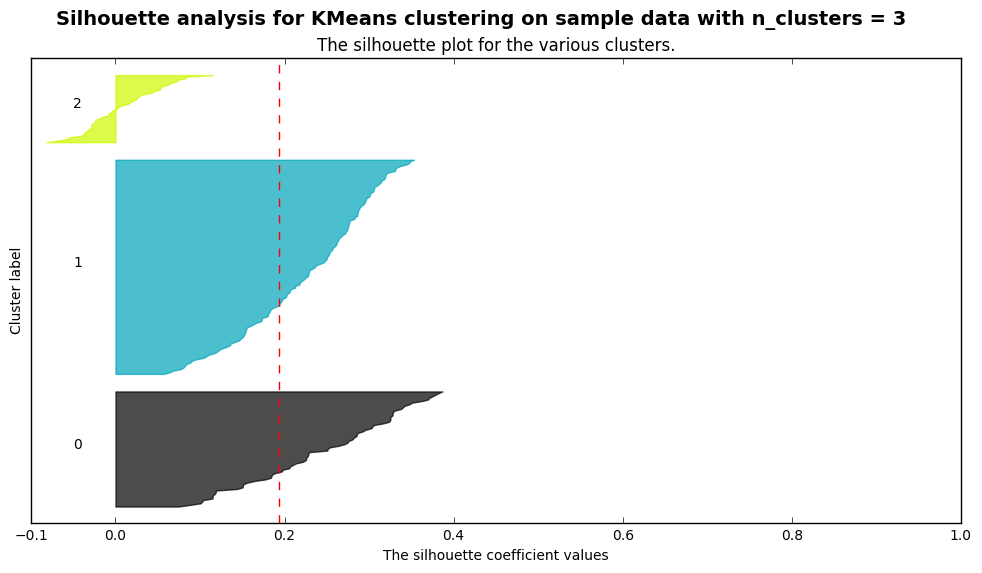

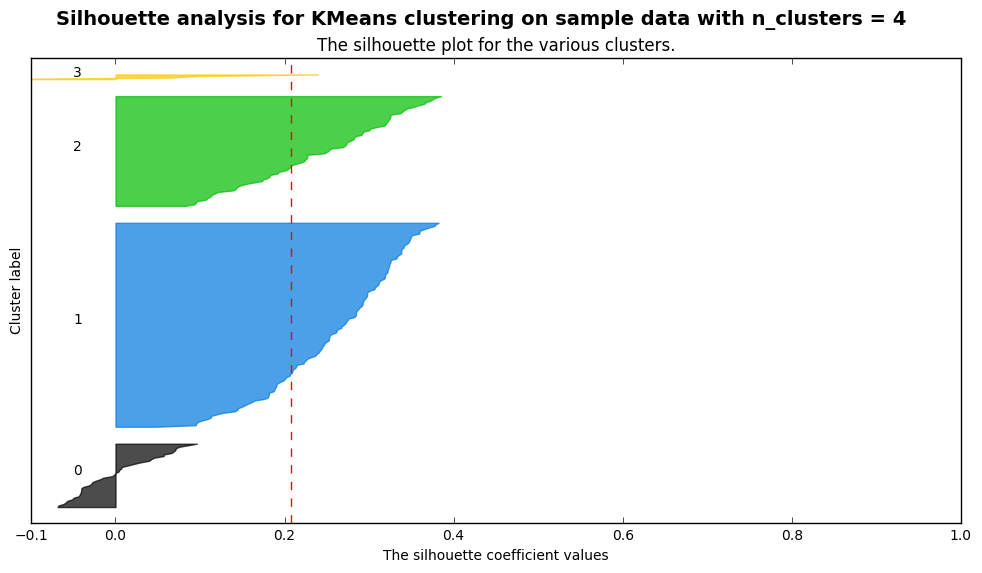

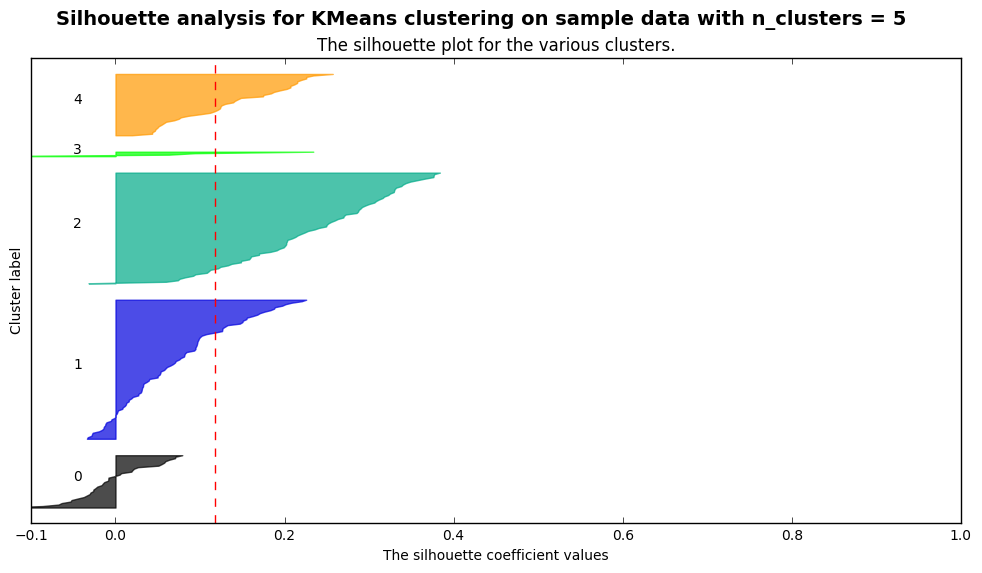

Number of clusters  Average silhouette score  \
0                   2                  0.302809   
1                   3                  0.193747   
2                   4                  0.207292   
3                   5                  0.117849   

                      Size of cluster  \
0                     {0: 154, 1: 97}   
1              {0: 73, 1: 135, 2: 43}   
2        {0: 42, 1: 133, 2: 72, 3: 4}   
3  {0: 36, 1: 94, 2: 75, 3: 4, 4: 42}   

                                  Label assignements  
0  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [2, 0, 2, 0, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, ...  
2  [0, 2, 0, 2, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, ...  
3  [0, 2, 0, 2, 4, 4, 4, 1, 4, 0, 0, 0, 1, 1, 4, ...

In [21]:
# Convert DataFrame to matrix
defCorrectedMat = defCorrectedForms.drop("temporality", axis=1).as_matrix()
# Standardise data
defCorrectedMat = preprocessing.scale(defCorrectedMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
defCorrectedResults = tryKmeans(defCorrectedMat)
# Format results as a DataFrame
defCorrectedResults = pd.DataFrame(data=defCorrectedResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
defCorrectedResults

Conclusion: The data could be clustered in two groups and the clustering is slightly better than with scientific questions coded by answers
Note: The silhouette coefficient probably never goes very high because of the binary aspect of most of the data (01/12/2017)

Hypothesis: The two groups identified by the clustering algorithm correspond to the "before" and "after" questionnaires.
Note: The temporality feature was not included in the clustering algorithm

Will split columns into 6 groups


FloatProgress(value=0.0, max=6.0)

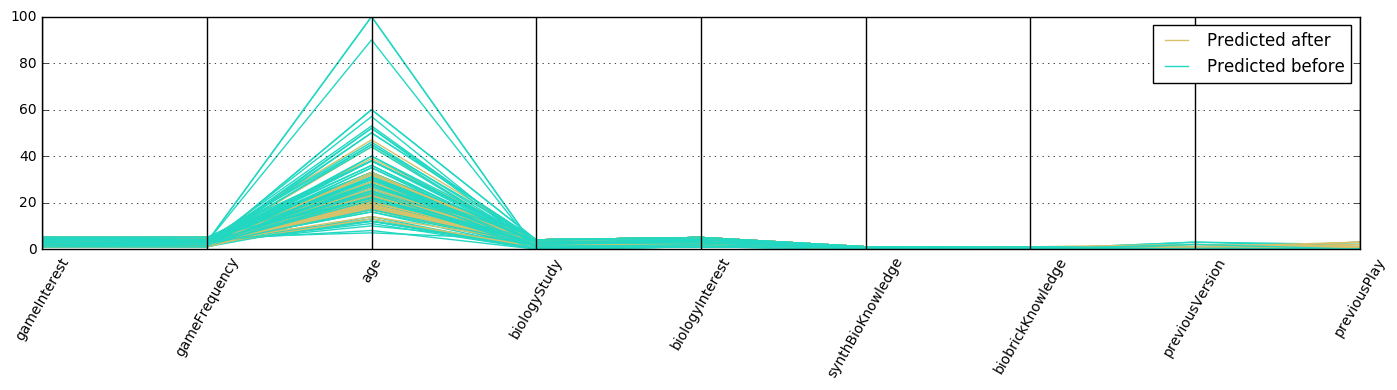

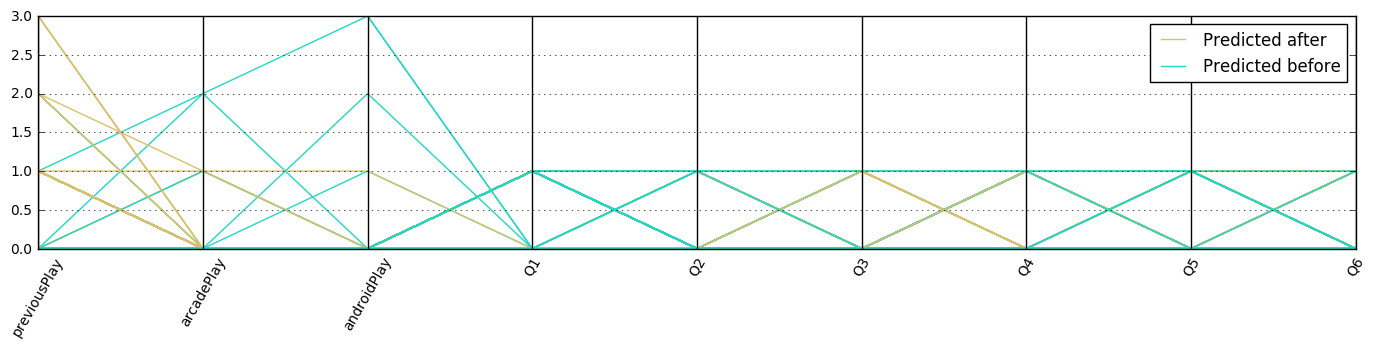

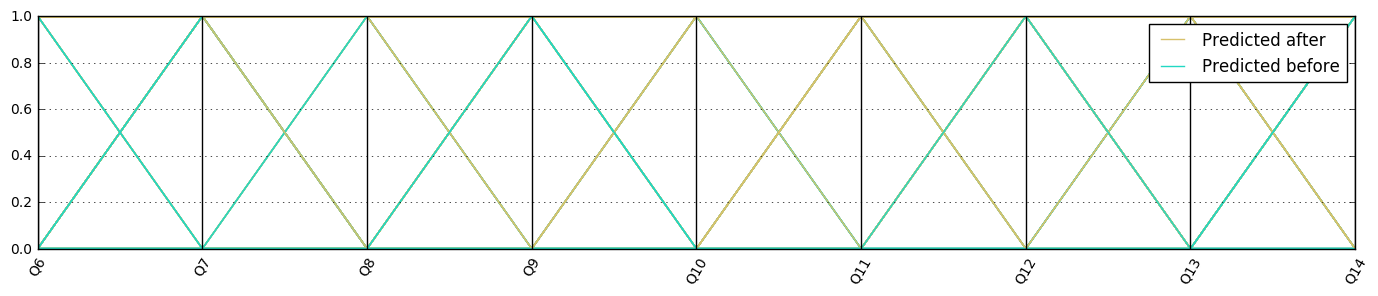

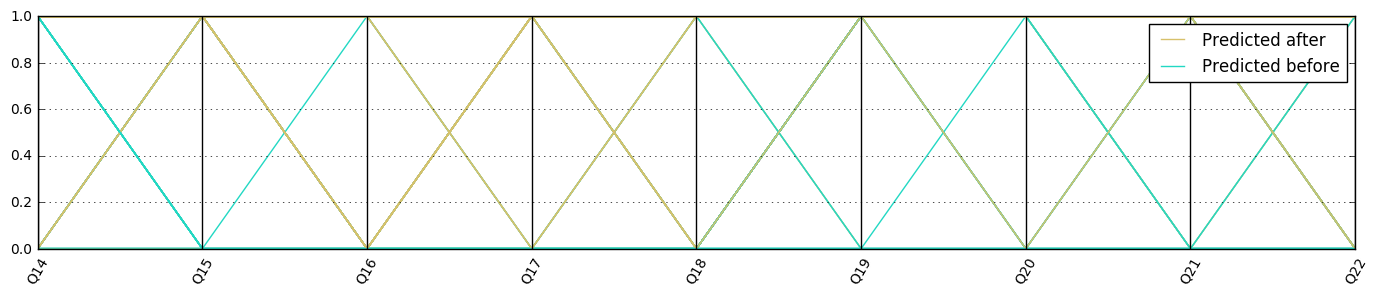

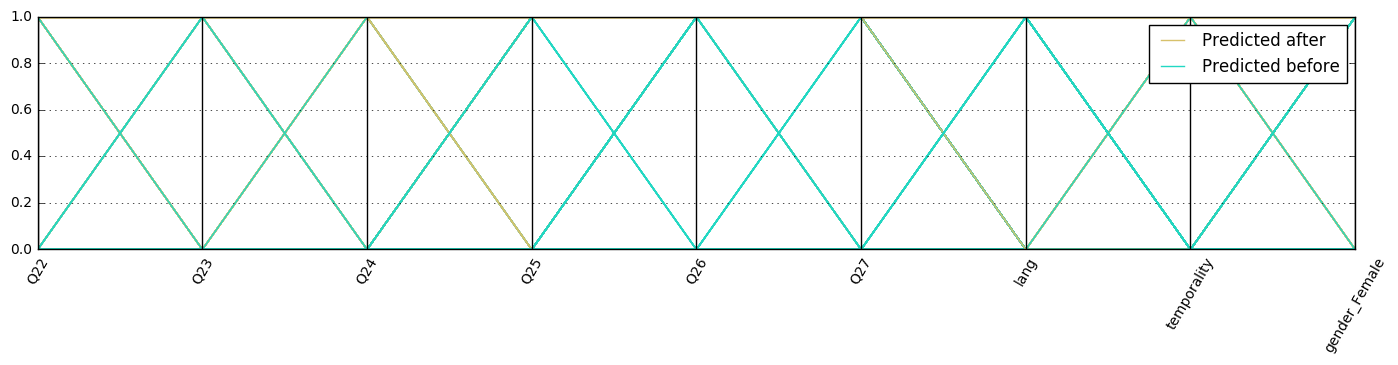

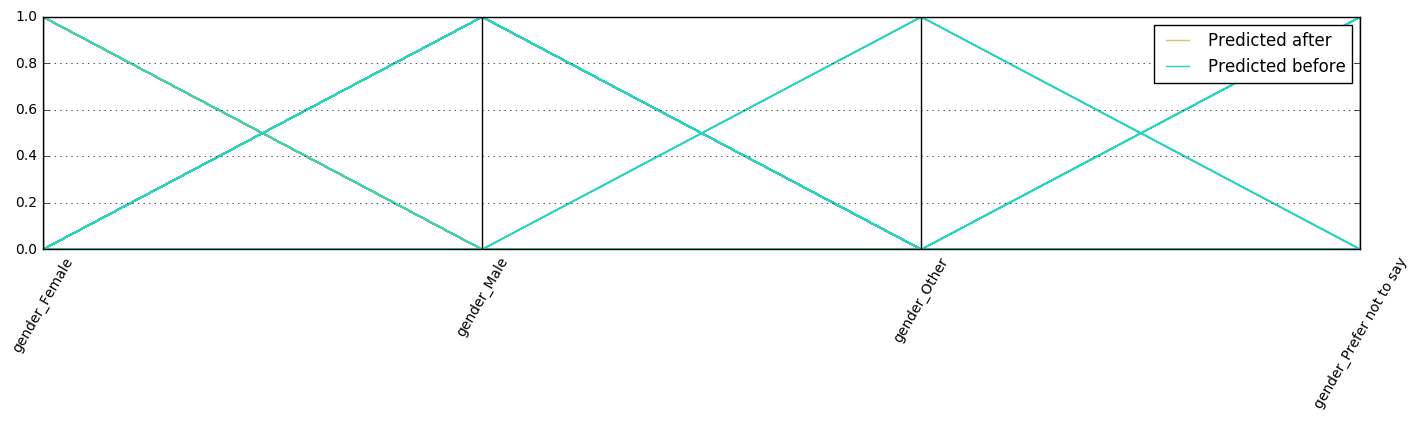

Predicted after  Predicted before
Actual after               147                44
Actual before                7                53

In [22]:
assignements = detailsKmeans(defCorrectedForms, defCorrectedResults, 2, displayParallelCoord=True, clusterLabels=["Predicted after", "Predicted before"])
assignements = pd.concat([assignements, defCorrectedForms["temporality"]], axis=1, join='inner')
defCorrectedConfusionMat = confusion_matrix(list(assignements["temporality"]), list(assignements["Index of cluster"]))
defCorrectedConfusionMat = pd.DataFrame(data = defCorrectedConfusionMat, columns=["Predicted after", "Predicted before"], index = ["Actual after", "Actual before"])
defCorrectedConfusionMat

Conclusion: Hypothesis verified. Parallel coordinates plot is not very informative because of the high proportion of binary features, use only for data exploration. Better than with scientific questions coded by answers (16/01/2018)

### If all questionnaires are used

C:\Users\Mikael\Anaconda3\envs\conda-env-python3-py\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


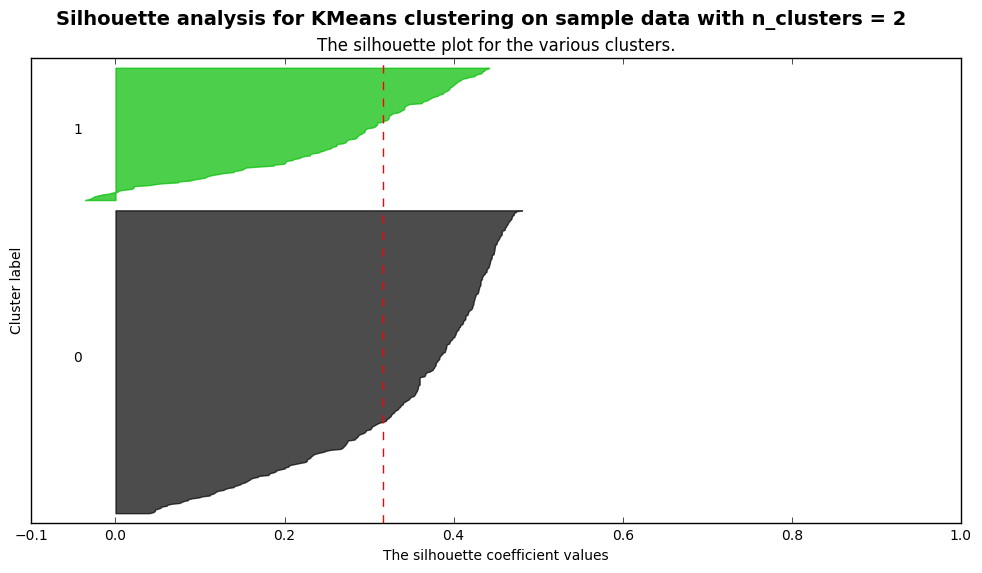

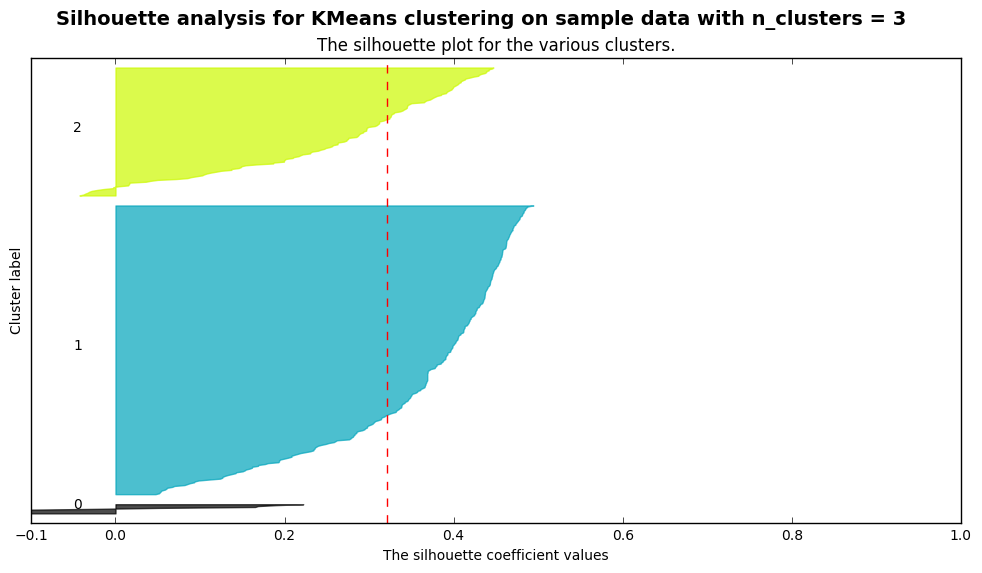

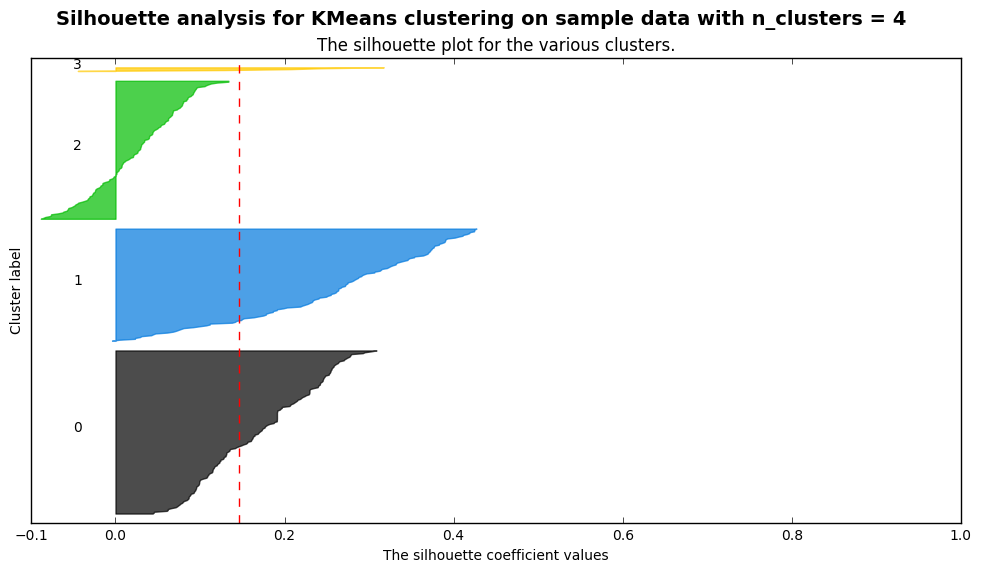

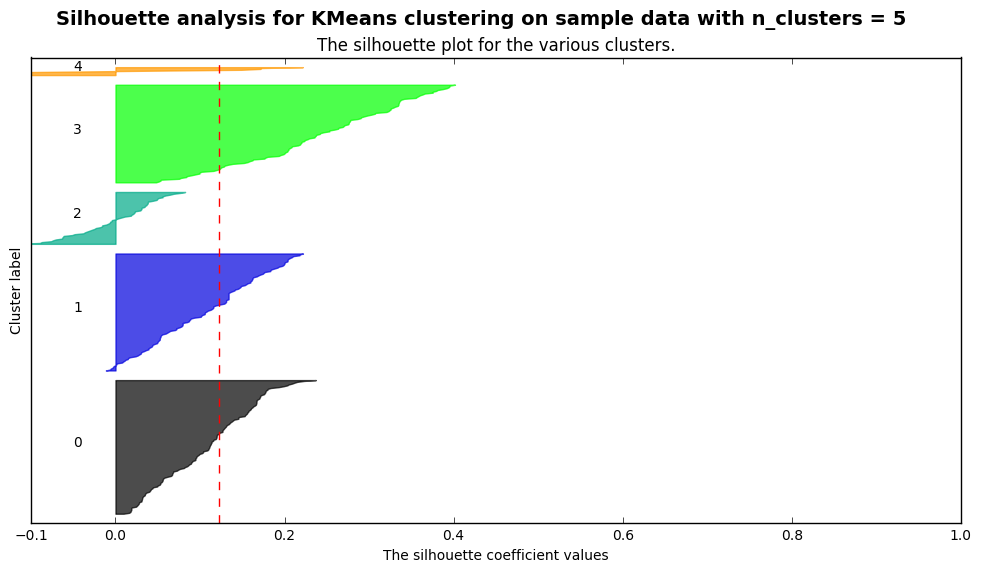

Number of clusters  Average silhouette score  \
0                   2                  0.316027   
1                   3                  0.321148   
2                   4                  0.145614   
3                   5                  0.122311   

                          Size of cluster  \
0                        {0: 326, 1: 143}   
1                 {0: 11, 1: 317, 2: 141}   
2          {0: 183, 1: 126, 2: 155, 3: 5}   
3  {0: 153, 1: 134, 2: 60, 3: 112, 4: 10}   

                                  Label assignements  
0  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
2  [1, 1, 1, 1, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, ...  
3  [2, 3, 2, 3, 0, 0, 0, 0, 1, 0, 0, 2, 2, 2, 0, ...

In [23]:
# Convert DataFrame to matrix
allCorrectedMat = allCorrectedForms.drop("temporality", axis=1).as_matrix()
# Standardise data
allCorrectedMat = preprocessing.scale(allCorrectedMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
allCorrectedResults = tryKmeans(allCorrectedMat)
# Format results as a DataFrame
allCorrectedResults = pd.DataFrame(data=allCorrectedResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
allCorrectedResults

Conclusion: The data could be clustered in two groups. Three groups could be interesting but not enough data points in third cluster to conclude. (30/11/2017)

Will split columns into 6 groups


FloatProgress(value=0.0, max=6.0)

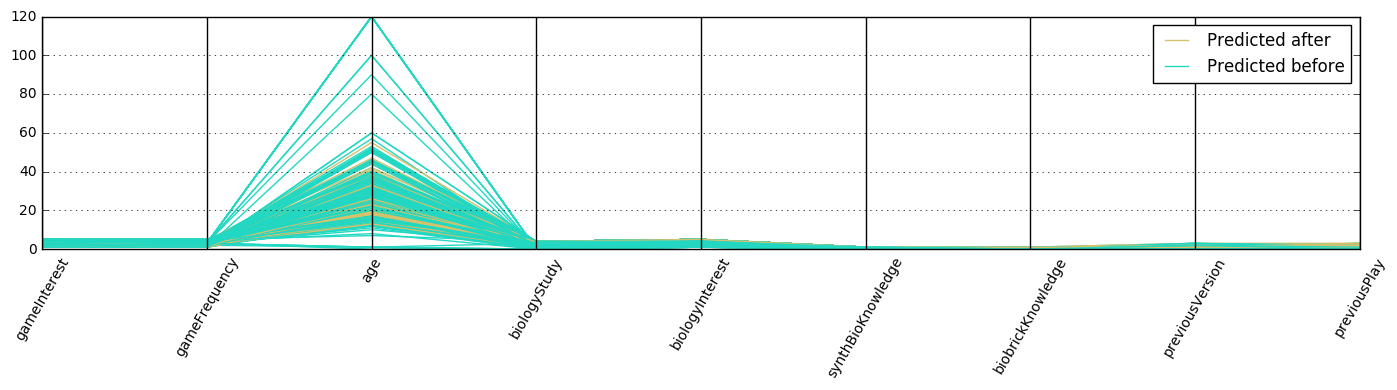

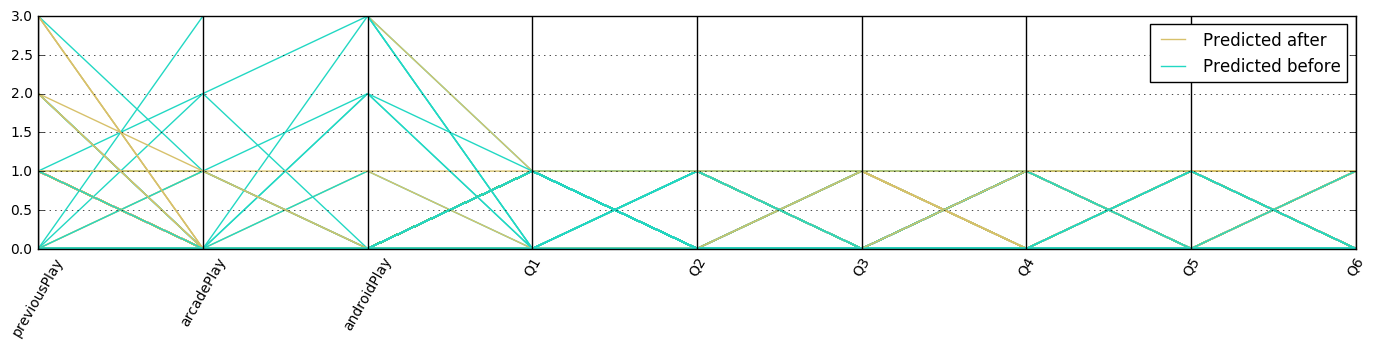

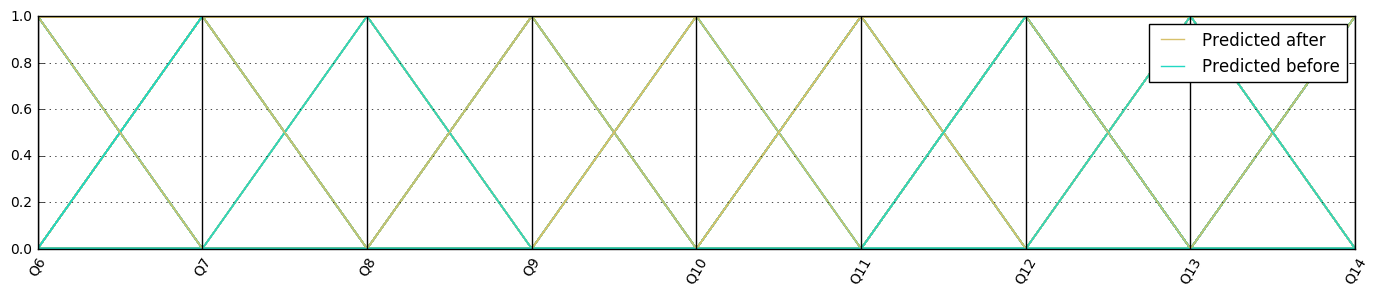

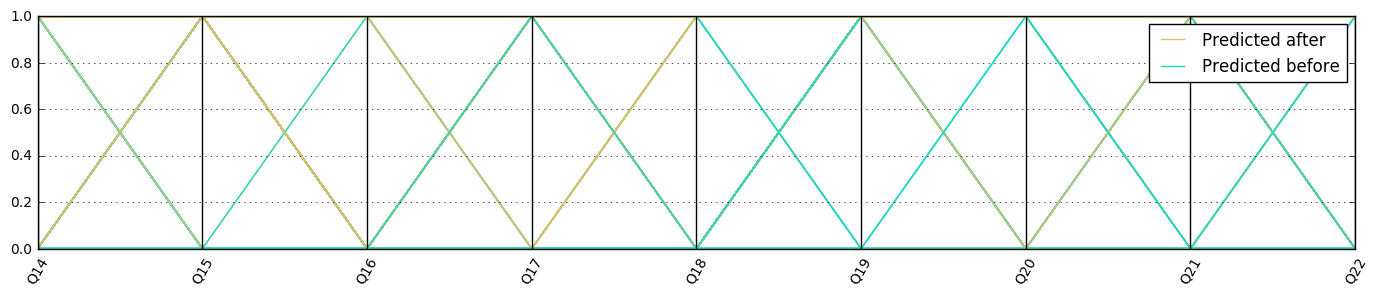

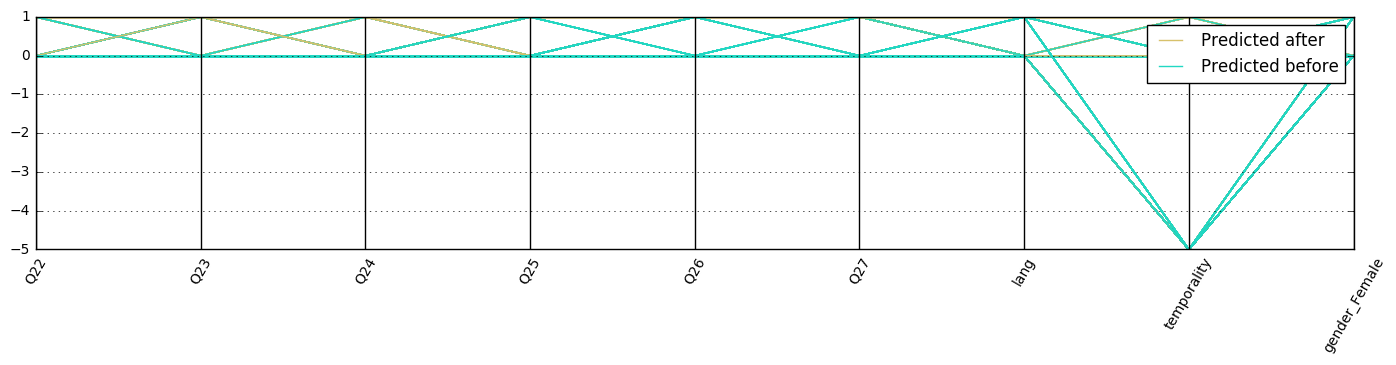

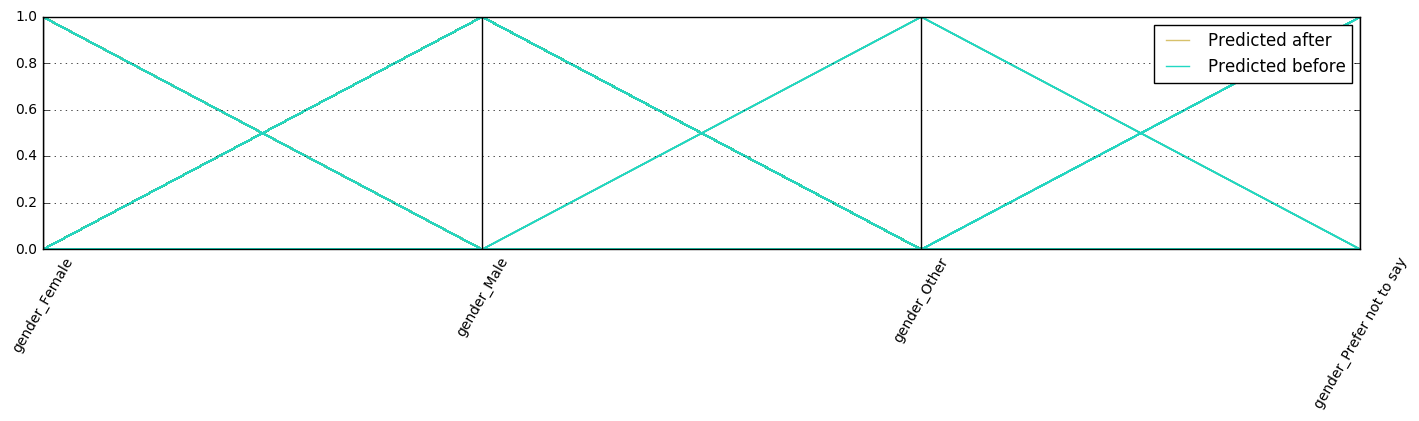

Predicted after  Predicted before
Actual undefined              173                45
Actual after                  146                45
Actual before                   7                53

In [24]:
assignements = detailsKmeans(allCorrectedForms, allCorrectedResults, 2, displayParallelCoord=True, clusterLabels=["Predicted after", "Predicted before"])
assignements = pd.concat([assignements, allCorrectedForms["temporality"]], axis=1, join='inner')
defCorrectedConfusionMat = confusion_matrix(list(assignements["temporality"]), list(assignements["Index of cluster"]))
defCorrectedConfusionMat = pd.DataFrame(data = defCorrectedConfusionMat, columns=["Predicted undefined", "Predicted after", "Predicted before"], index = ["Actual undefined", "Actual after", "Actual before"])
defCorrectedConfusionMat.drop("Predicted undefined", axis=1, inplace=True)
defCorrectedConfusionMat

Conclusion: Compared to previous test, the presence of questionnaire that were realised neither just before nor just after the play test is not detected, but it does not impact the prediction of the before and after temporalities (01/12/2017)

TODO RAPHAEL : Manually check the undefined temporalities

# Can the data be clustered according to the answers given to both the before and the after questionnaire?

## If scientific questions are coded by answers

C:\Users\Mikael\Anaconda3\envs\conda-env-python3-py\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


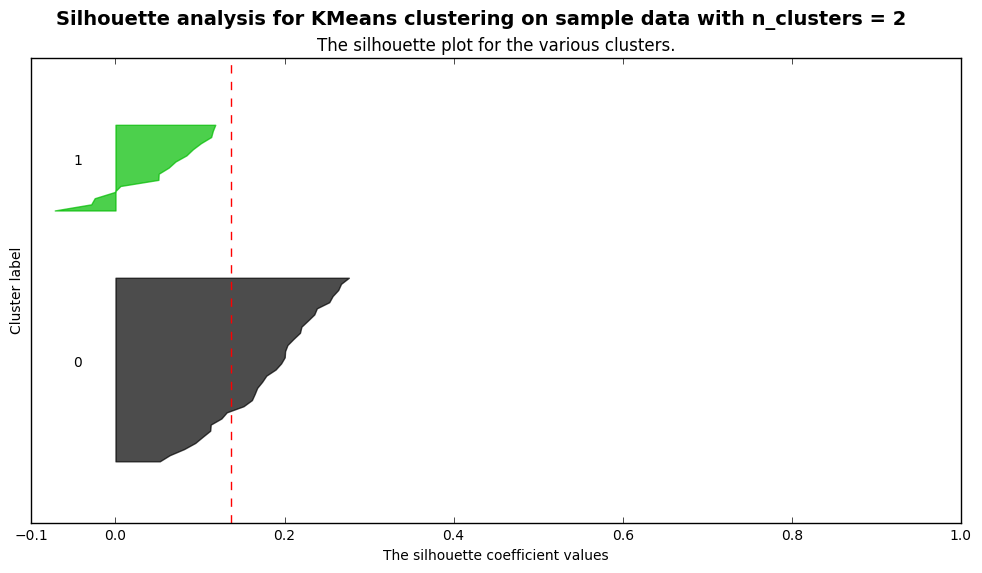

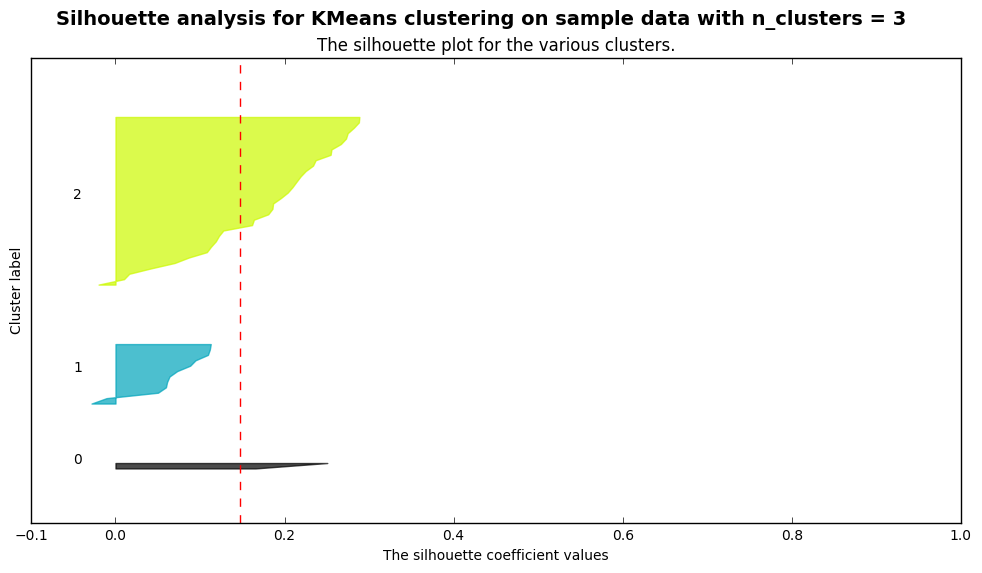

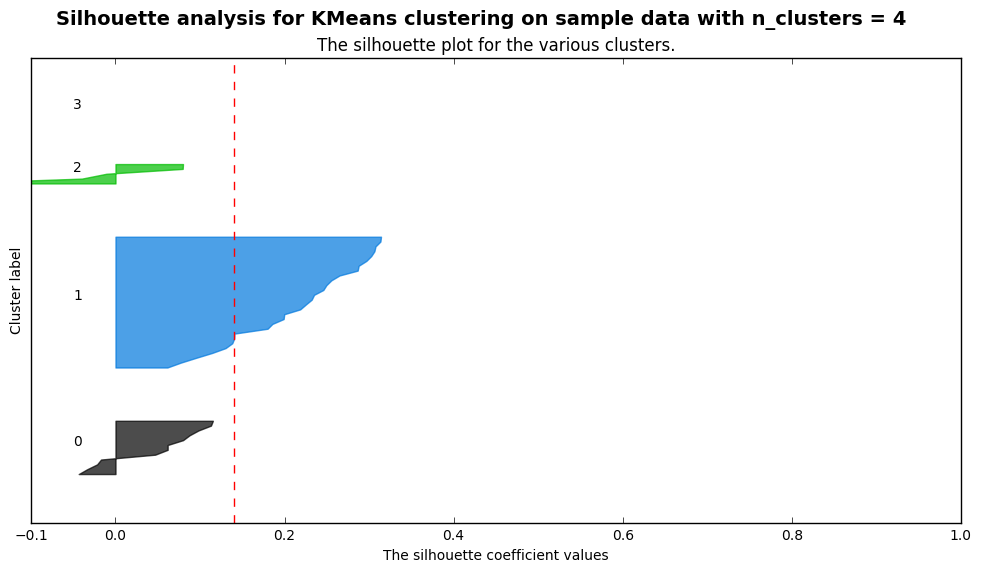

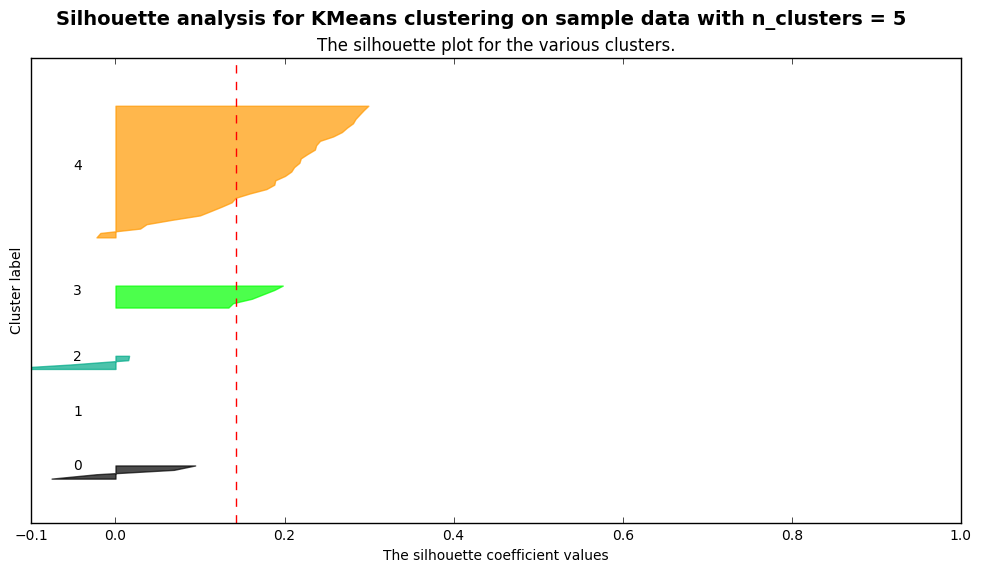

Number of clusters  Average silhouette score  \
0                   2                  0.136217   
1                   3                  0.147655   
2                   4                  0.140352   
3                   5                  0.142673   

                   Size of cluster  \
0                   {0: 31, 1: 15}   
1             {0: 2, 1: 12, 2: 32}   
2       {0: 12, 1: 28, 2: 5, 3: 1}   
3  {0: 4, 1: 1, 2: 4, 3: 6, 4: 31}   

                                  Label assignements  
0  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...  
1  [2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 1, ...  
2  [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 3, 0, ...  
3  [4, 4, 1, 4, 4, 4, 4, 4, 0, 0, 4, 4, 4, 2, 2, ...

In [25]:
# Convert DataFrame to matrix
beforeAndAfterMat = beforeAndAfterForms.as_matrix()
# Standardise the data
beforeAndAfterMat = preprocessing.scale(beforeAndAfterMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
beforeAndAfterResults = tryKmeans(beforeAndAfterMat)
# Format results as a DataFrame
beforeAndAfterResults = pd.DataFrame(data=beforeAndAfterResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
beforeAndAfterResults

Conclusion: No interesting clustering (30/11/2017)

## If scientific questions are coded by correctedness

C:\Users\Mikael\Anaconda3\envs\conda-env-python3-py\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


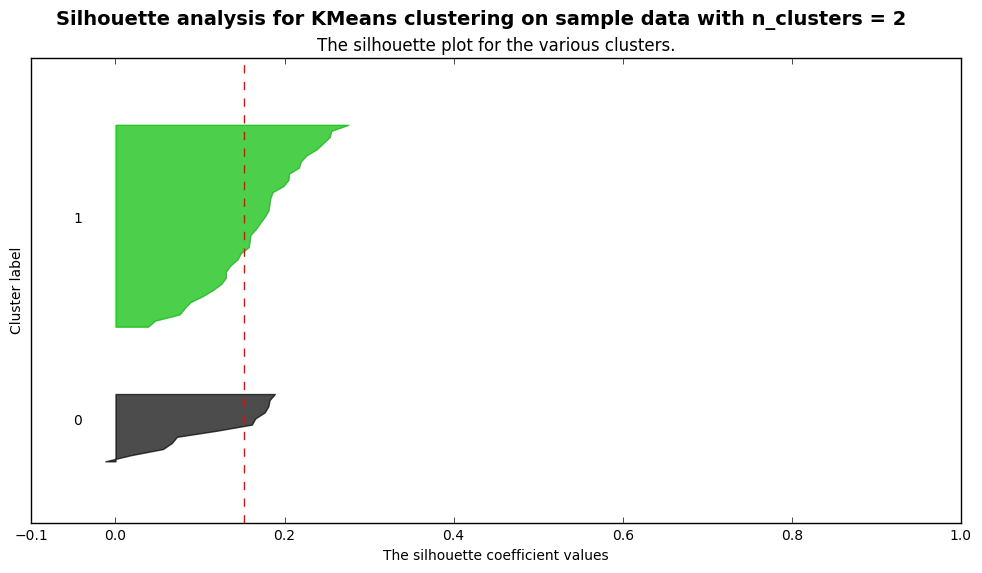

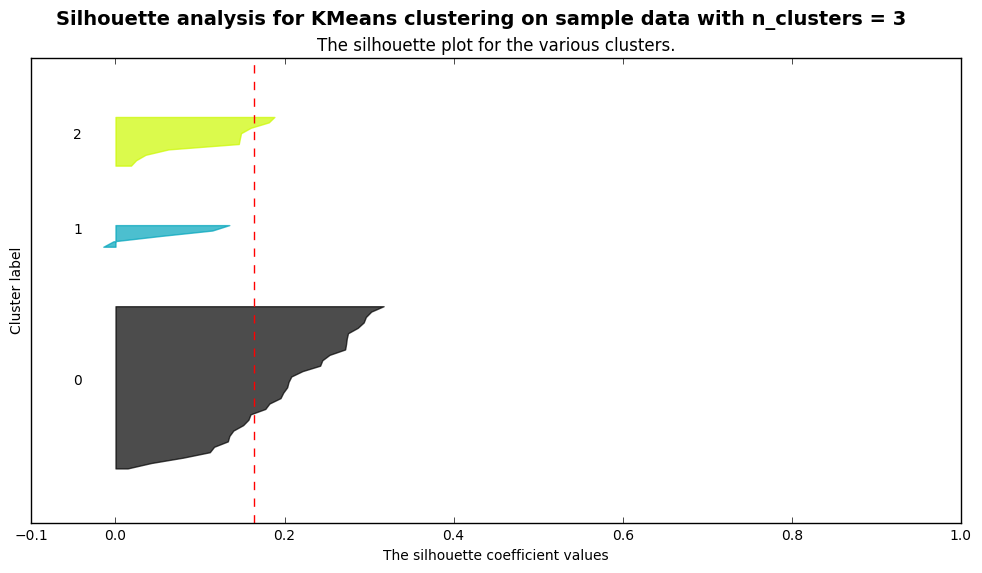

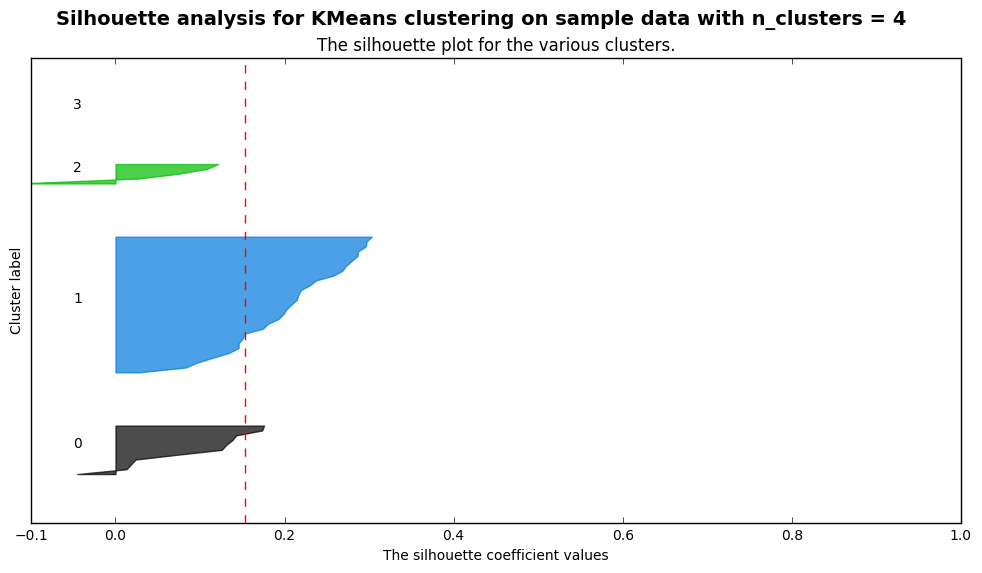

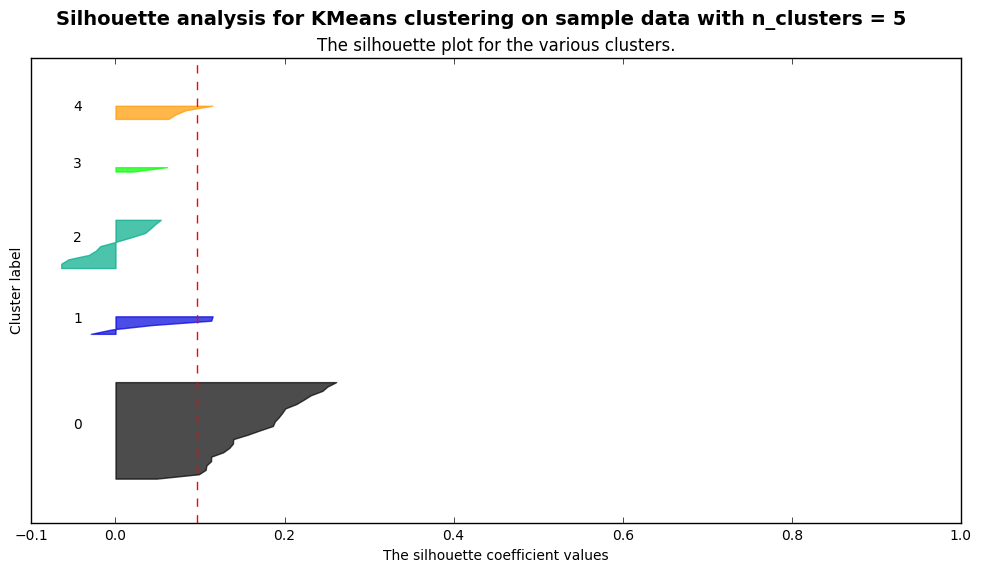

Number of clusters  Average silhouette score  \
0                   2                  0.152220   
1                   3                  0.164250   
2                   4                  0.153434   
3                   5                  0.096419   

                    Size of cluster  \
0                    {0: 12, 1: 34}   
1              {0: 31, 1: 5, 2: 10}   
2        {0: 11, 1: 29, 2: 5, 3: 1}   
3  {0: 23, 1: 5, 2: 12, 3: 2, 4: 4}   

                                  Label assignements  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...  
1  [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, ...  
2  [1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 0, ...  
3  [0, 2, 1, 0, 2, 2, 2, 0, 1, 1, 0, 0, 0, 2, 2, ...

In [26]:
# Convert DataFrame to matrix
beforeAndAfterCorrectedMat = beforeAndAfterCorrectedForms.as_matrix()
# Standardise the data
beforeAndAfterCorrectedMat = preprocessing.scale(beforeAndAfterCorrectedMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
beforeAndAfterCorrectedResults = tryKmeans(beforeAndAfterCorrectedMat)
# Format results as a DataFrame
beforeAndAfterCorrectedResults = pd.DataFrame(data=beforeAndAfterCorrectedResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
beforeAndAfterCorrectedResults

Conclusion: The data could be clustered in two groups (01/12/2017)

Will split columns into 11 groups


FloatProgress(value=0.0, max=11.0)

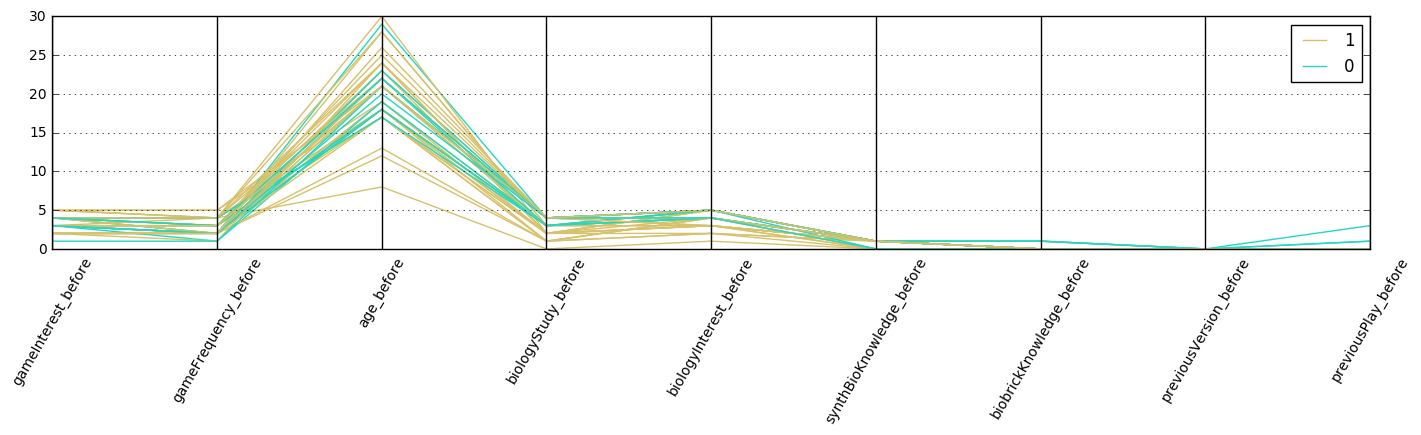

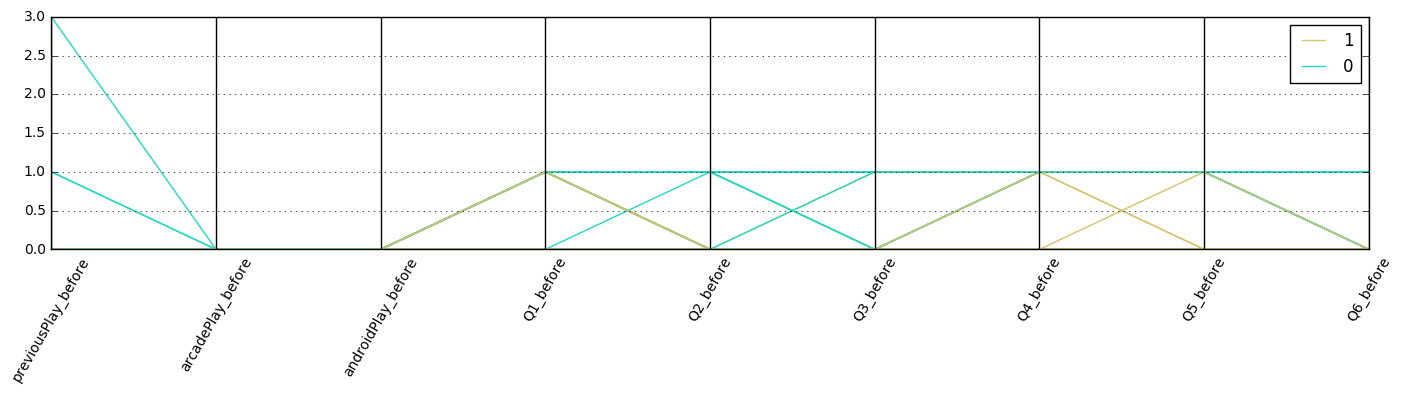

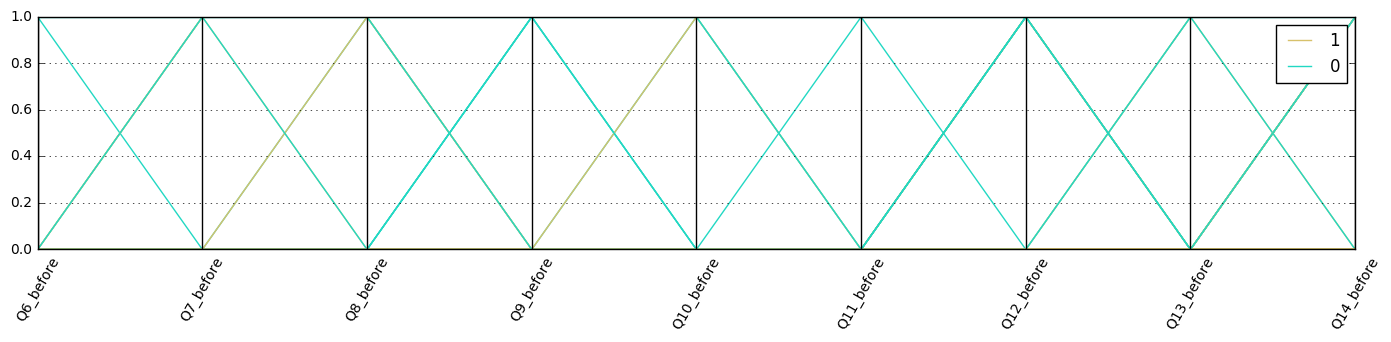

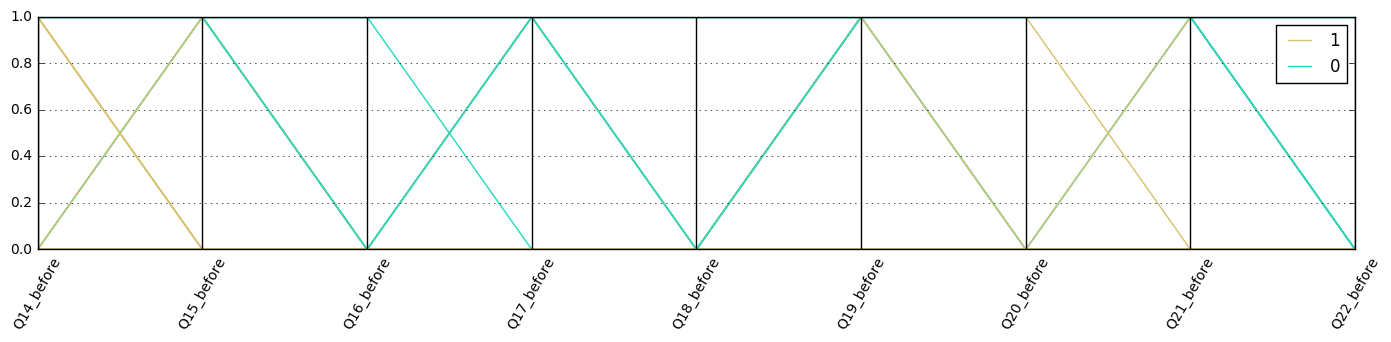

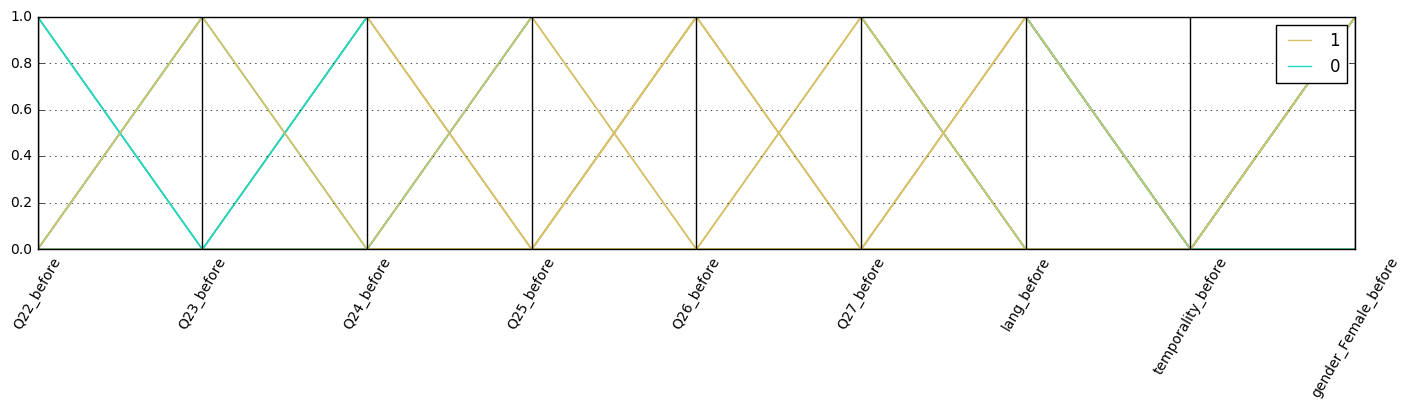

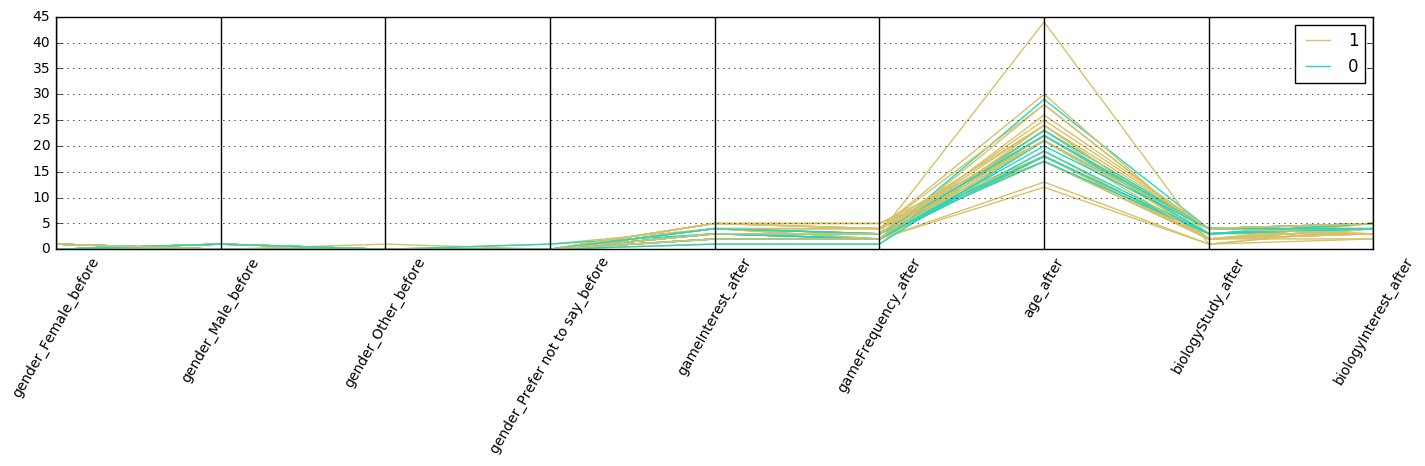

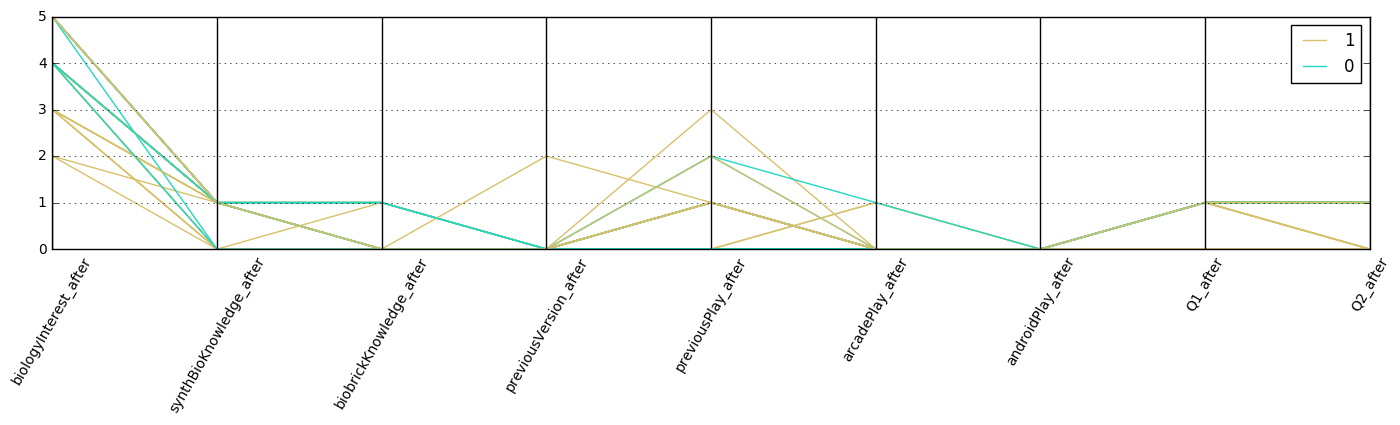

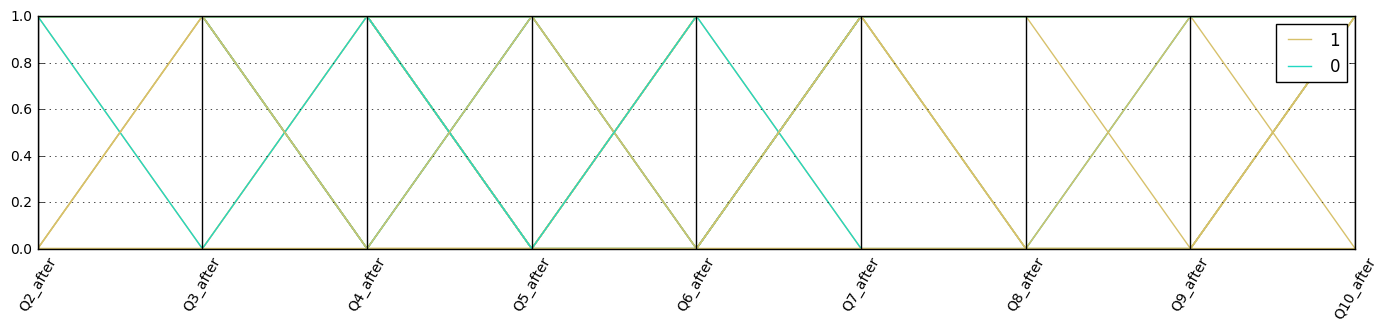

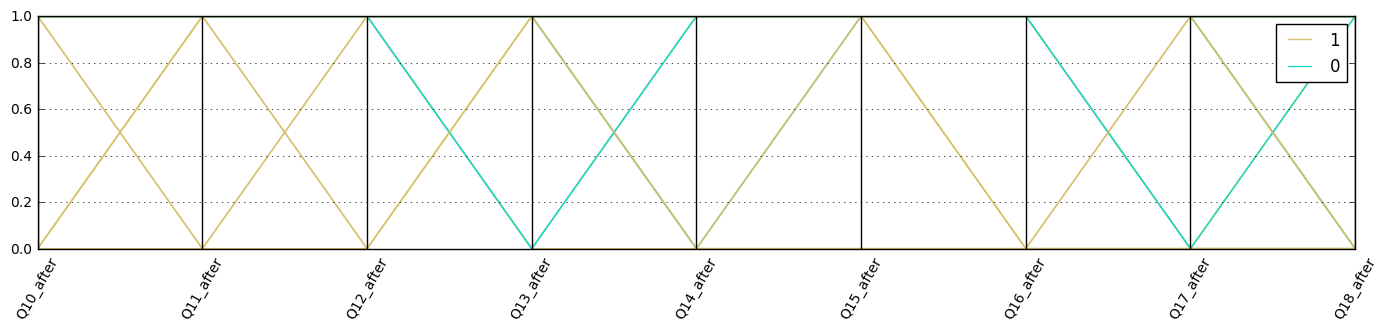

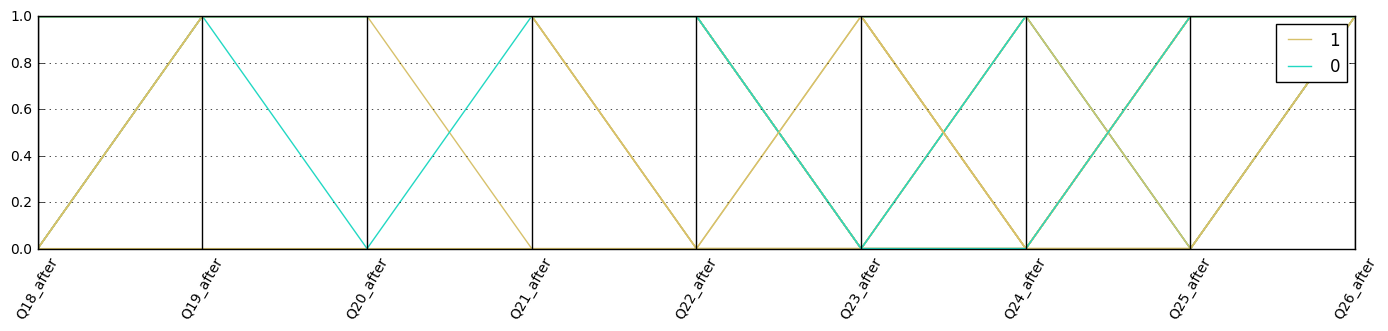

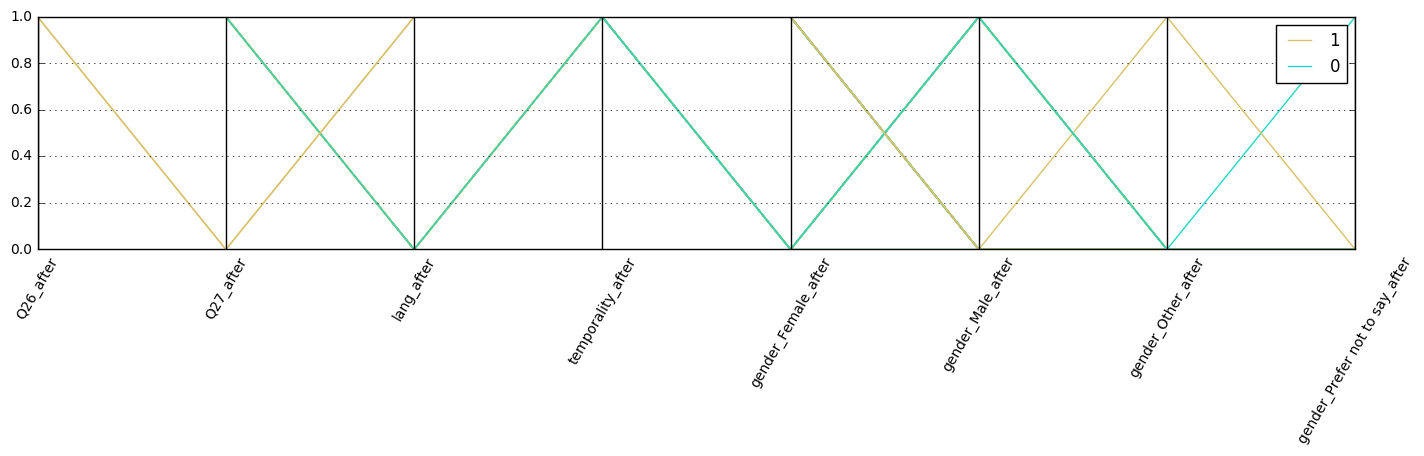

In [27]:
assignements = detailsKmeans(beforeAndAfterCorrectedForms, beforeAndAfterCorrectedResults, 2, displayParallelCoord=True)

In [28]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(beforeAndAfterCorrectedForms, beforeAndAfterCorrectedResults, 2, "previousPlay_before")
correctAnswersByCluster

Ttest_indResult(statistic=2.7565444273597568, pvalue=0.008470366177689476)


Cluster 0  Cluster 1
0   0.750000        1.0
1   0.166667        0.0
3   0.083333        0.0

In [29]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(beforeAndAfterCorrectedForms, beforeAndAfterCorrectedResults, 2, "biologyInterest_before")
correctAnswersByCluster

Ttest_indResult(statistic=2.7177948179249007, pvalue=0.0093644963264774717)


Cluster 0  Cluster 1
1   0.000000   0.029412
2   0.000000   0.088235
3   0.000000   0.235294
4   0.333333   0.352941
5   0.666667   0.294118

In [30]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(beforeAndAfterCorrectedForms, beforeAndAfterCorrectedResults, 2, "biologyStudy_before")
correctAnswersByCluster

Ttest_indResult(statistic=2.7071286513695902, pvalue=0.0096254715027542931)


Cluster 0  Cluster 1
0   0.000000   0.029412
1   0.000000   0.147059
2   0.000000   0.264706
3   0.416667   0.264706
4   0.583333   0.294118

In [31]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(beforeAndAfterCorrectedForms, beforeAndAfterCorrectedResults, 2, "biologyInterest_after")
correctAnswersByCluster

Ttest_indResult(statistic=2.4505252338614292, pvalue=0.018310300850347946)


Cluster 0  Cluster 1
2   0.000000   0.058824
3   0.000000   0.205882
4   0.416667   0.470588
5   0.583333   0.264706

TODO Raphael: Look in details at scientific questions

# Can the data be clustered according to the RedMetrics values?

## All sessions

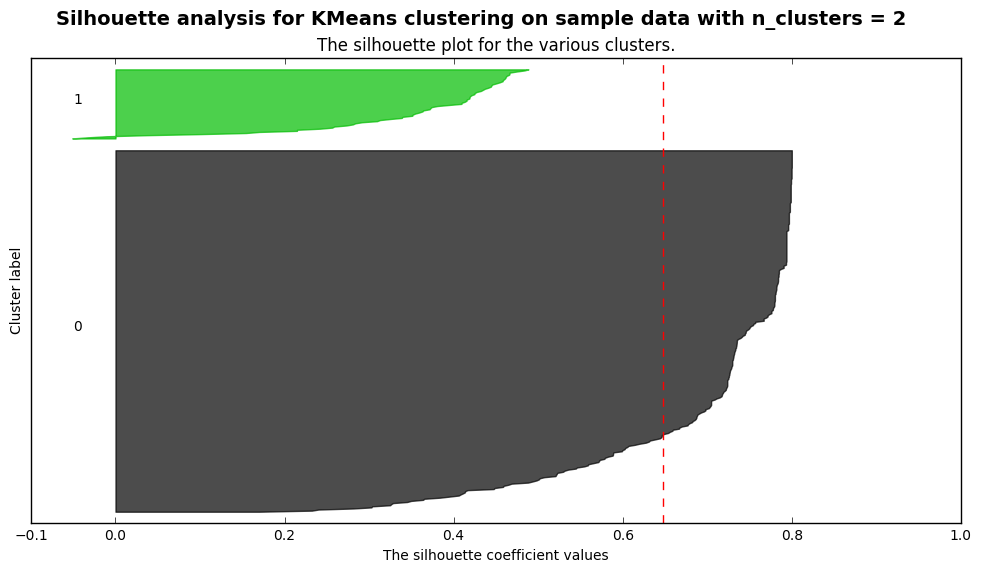

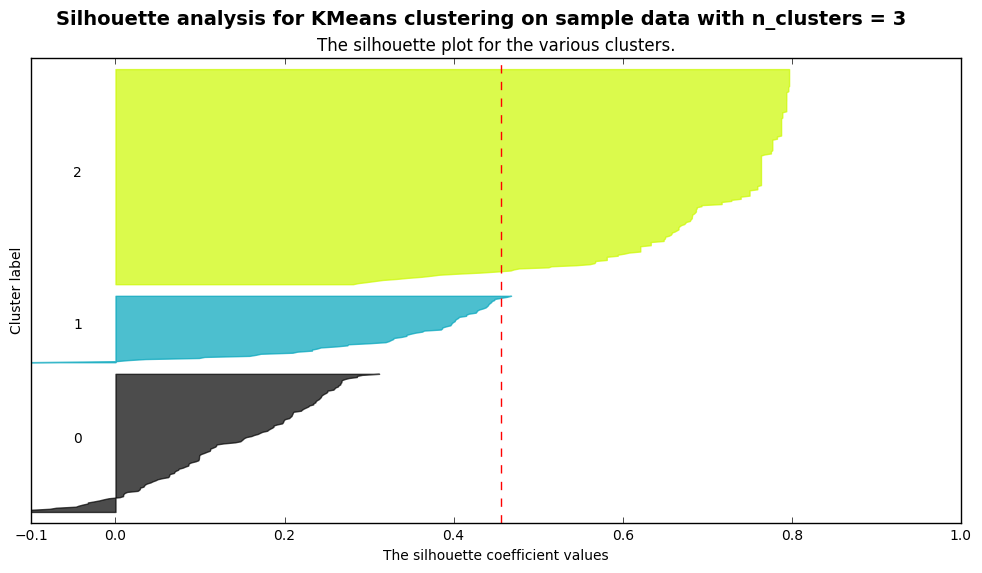

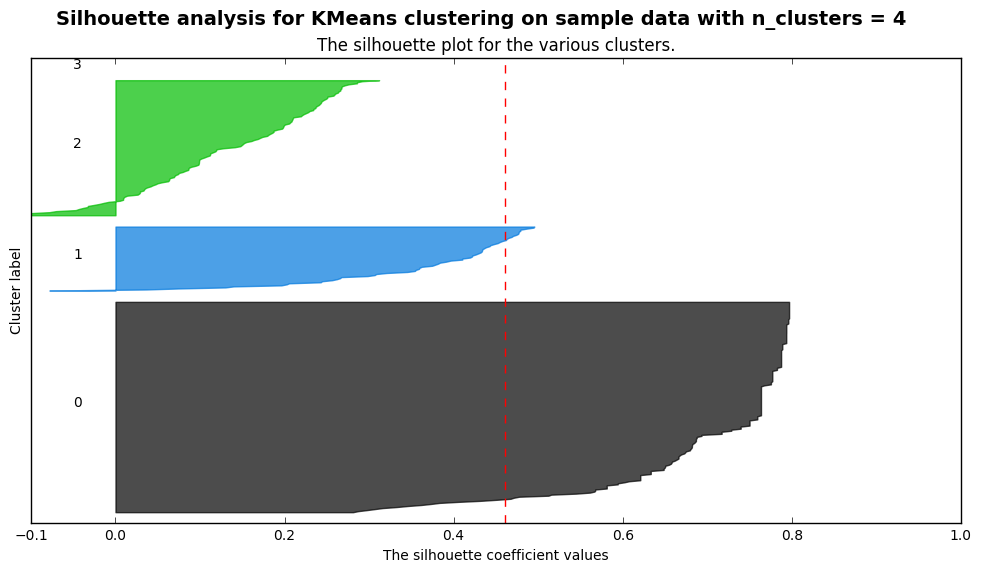

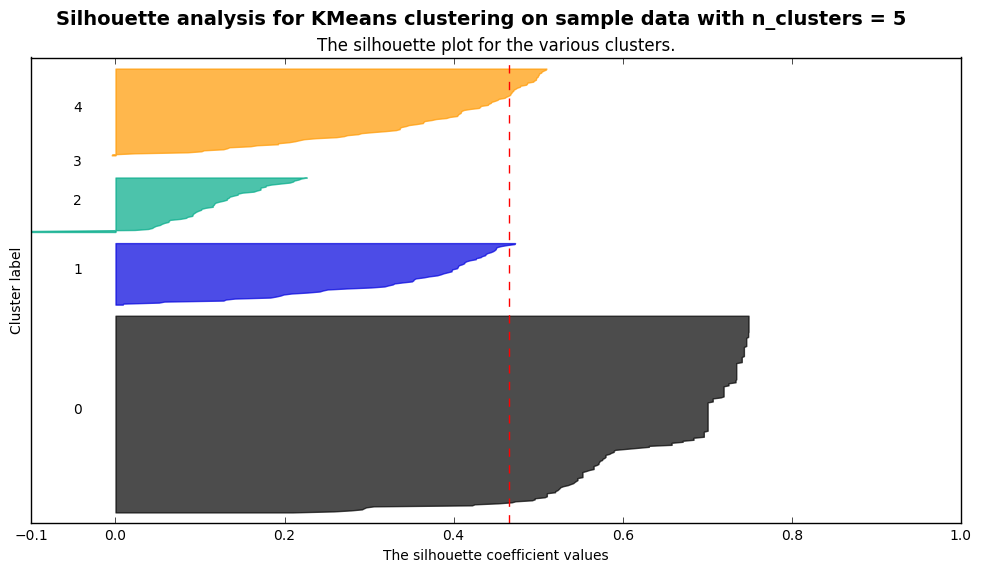

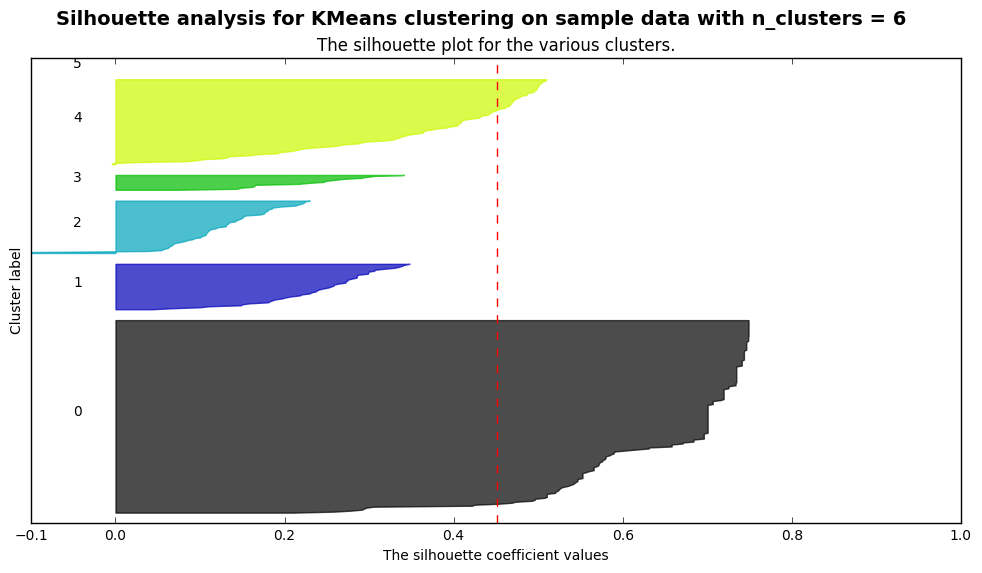

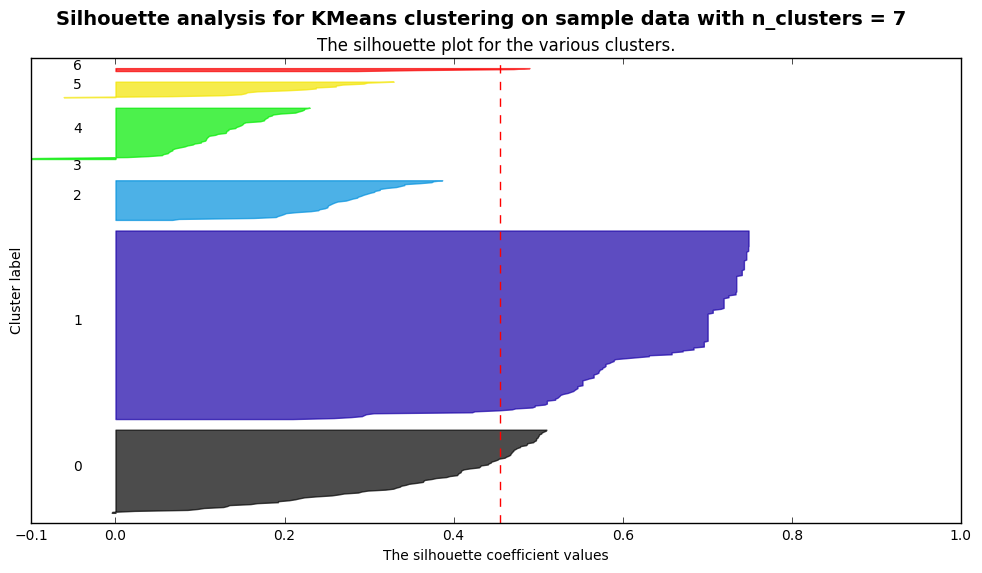

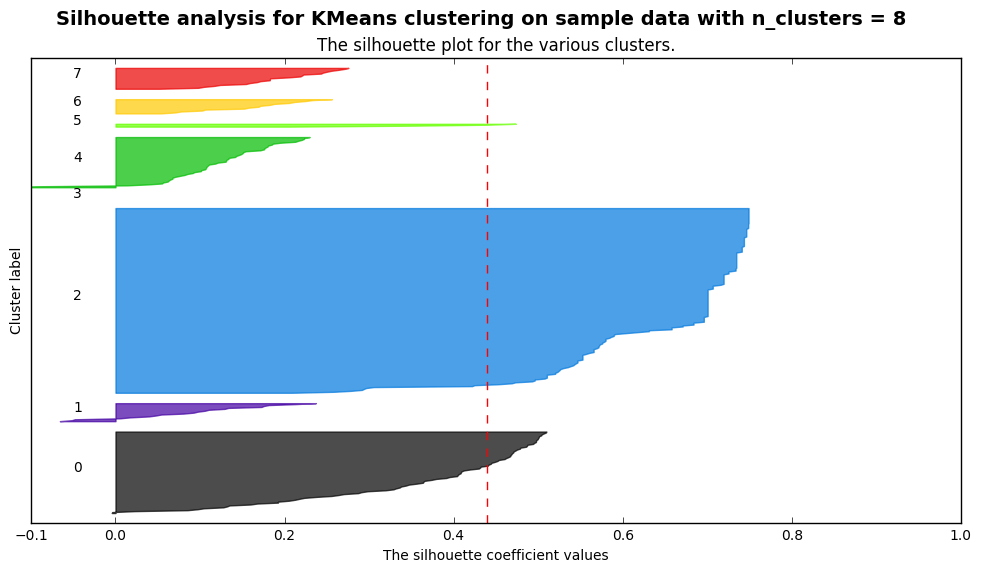

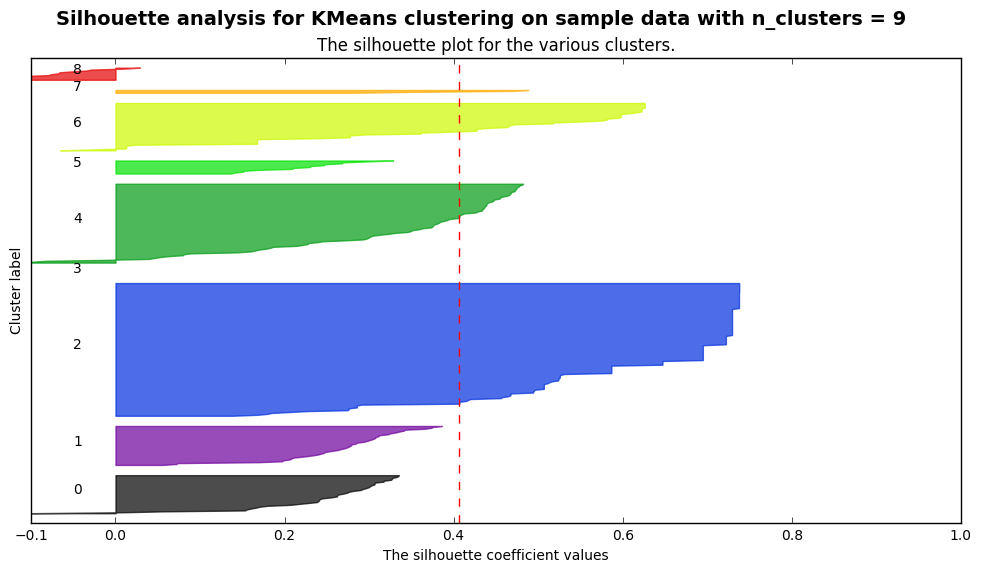

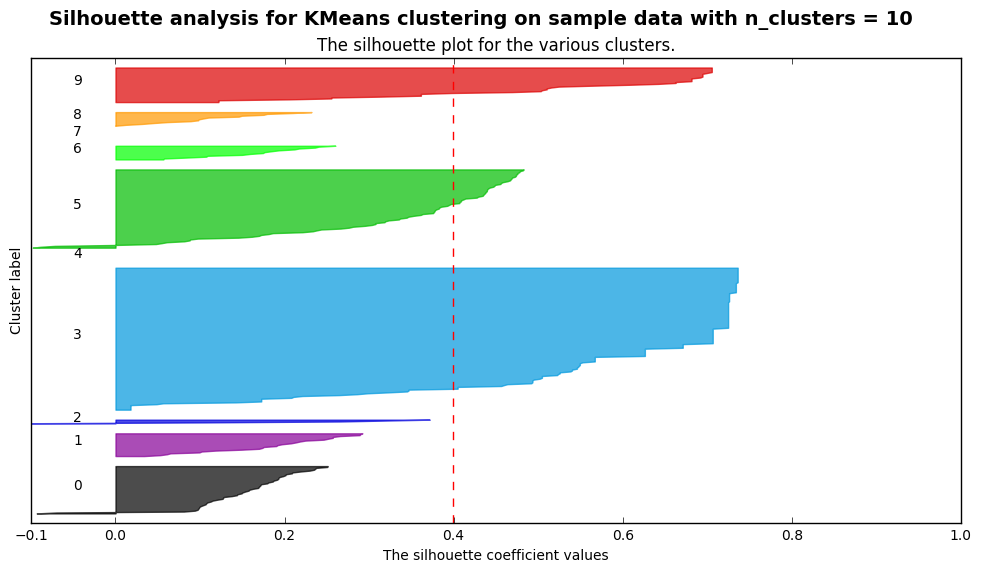

Number of clusters  Average silhouette score  \
0                   2                  0.647866   
1                   3                  0.456210   
2                   4                  0.460949   
3                   5                  0.465751   
4                   6                  0.451647   
5                   7                  0.454748   
6                   8                  0.439578   
7                   9                  0.406153   
8                  10                  0.399101   

                                     Size of cluster  \
0                                    {0: 336, 1: 65}   
1                            {0: 132, 1: 64, 2: 205}   
2                      {0: 205, 1: 63, 2: 132, 3: 1}   
3                {0: 196, 1: 62, 2: 55, 3: 1, 4: 87}   
4         {0: 196, 1: 47, 2: 54, 3: 16, 4: 87, 5: 1}   
5   {0: 87, 1: 196, 2: 42, 3: 1, 4: 54, 5: 17, 6: 4}   
6  {0: 87, 1: 20, 2: 196, 3: 1, 4: 54, 5: 4, 6: 1...   
7  {0: 42, 1: 43, 2: 144, 3: 1, 4: 86, 5: 15, 6: ...   
8  {0: 53, 1: 26, 2: 5, 3: 157, 4: 1, 5: 87, 6: 1...   

                                  Label assignements  
0  [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, ...  
1  [0, 1, 0, 0, 1, 0, 2, 1, 0, 2, 1, 1, 1, 1, 1, ...  
2  [2, 1, 2, 2, 1, 2, 0, 1, 2, 0, 1, 1, 1, 1, 1, ...  
3  [2, 1, 2, 2, 1, 2, 0, 1, 4, 0, 1, 1, 1, 1, 1, ...  
4  [2, 1, 2, 2, 3, 2, 0, 3, 4, 0, 1, 1, 3, 3, 1, ...  
5  [4, 2, 4, 4, 5, 4, 1, 5, 0, 1, 2, 2, 5, 5, 2, ...  
6  [4, 1, 4, 4, 6, 4, 2, 6, 0, 2, 7, 7, 6, 6, 1, ...  
7  [0, 1, 0, 0, 5, 8, 2, 5, 4, 2, 1, 1, 5, 5, 1, ...  
8  [0, 8, 0, 0, 6, 0, 3, 6, 5, 3, 1, 1, 6, 6, 8, ...

In [32]:
# Convert DataFrame to matrix
allDataMat = allData.iloc[:,:-1].as_matrix()
# Standardise the data
allDataMat = preprocessing.scale(allDataMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
allDataResults = tryKmeans(allDataMat, rangeNbClusters=[2, 3, 4, 5, 6, 7, 8, 9, 10])
# Format results as a DataFrame
allDataResults = pd.DataFrame(data=allDataResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
allDataResults

Conclusion: Could be clustered in two groups (17/01/2018)

Let's look at the parallel coordinates plot for 2 clusters

Will split columns into 5 groups


FloatProgress(value=0.0, max=5.0)

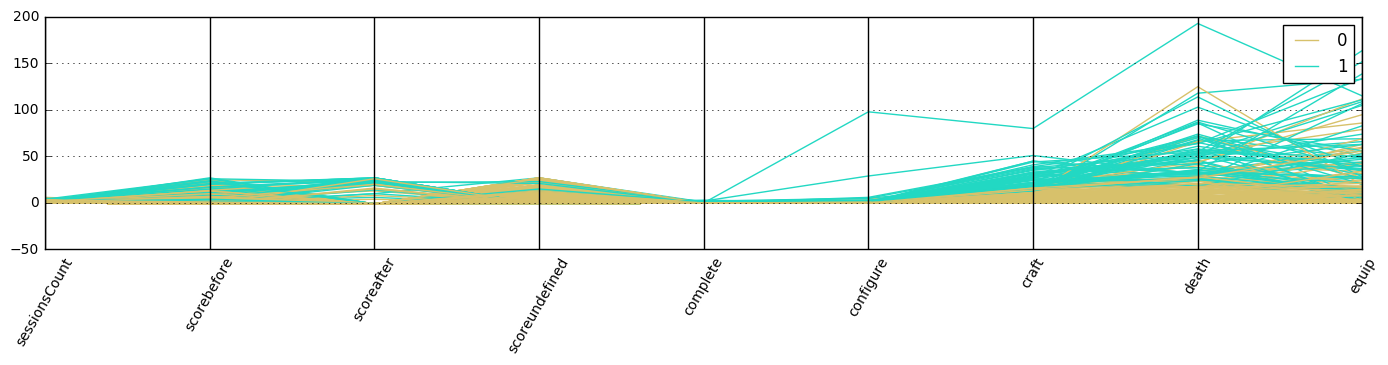

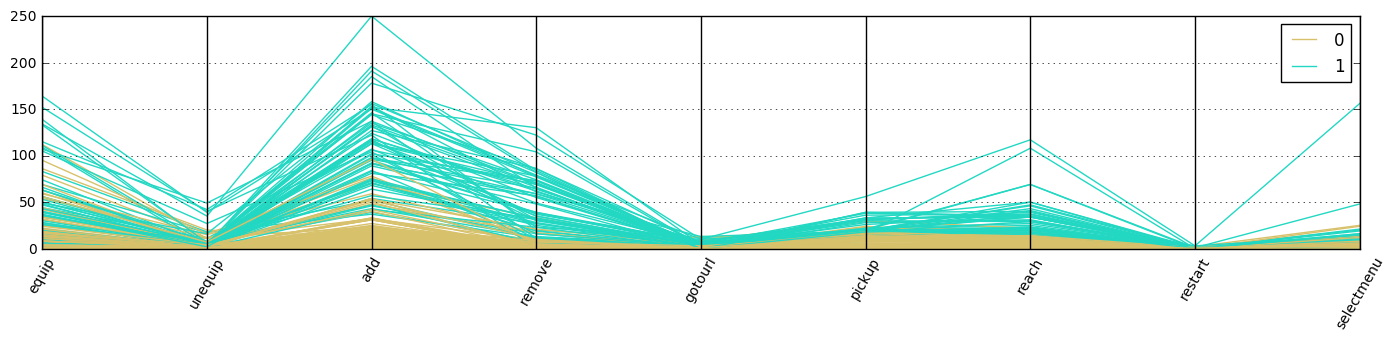

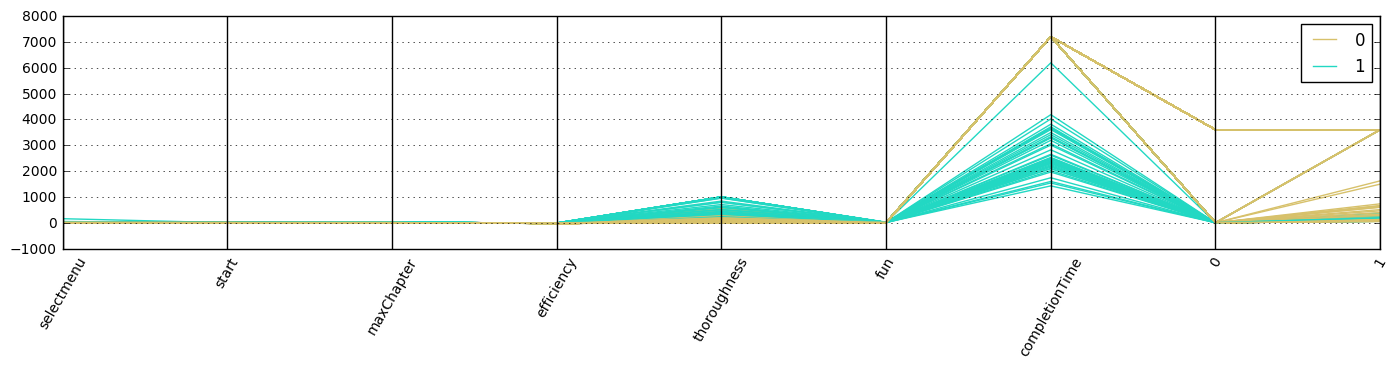

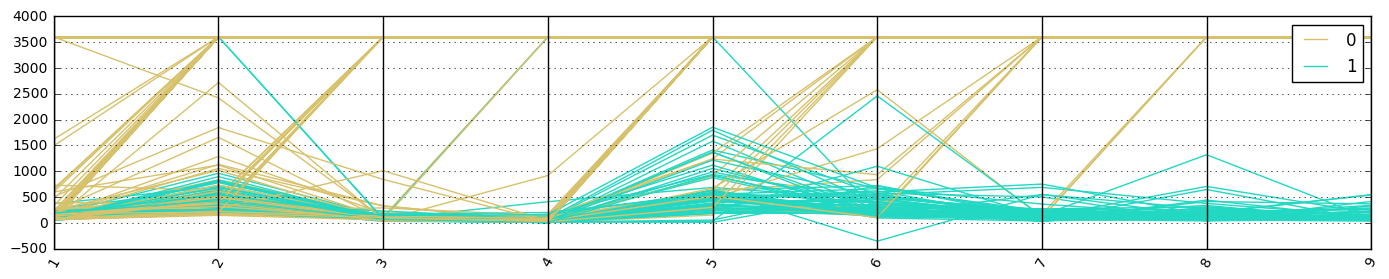

ValueError: could not convert string to float: '8d352896-a3f1-471c-8439-0f426df901c1'

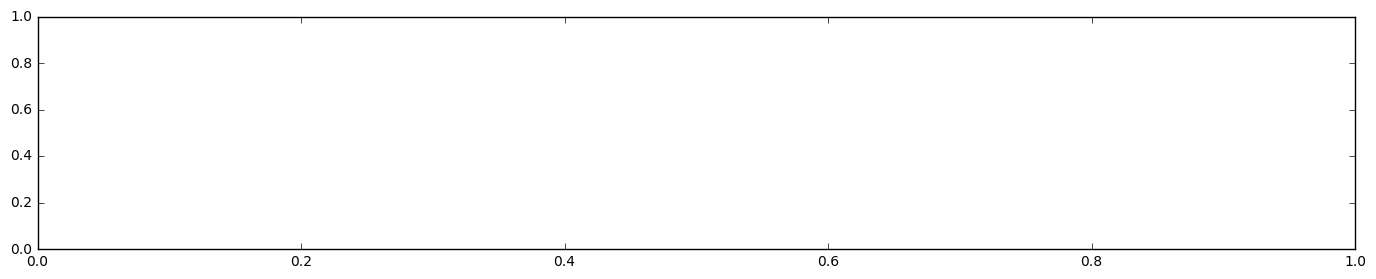

In [33]:
assignements = detailsKmeans(allData, allDataResults, 2, displayParallelCoord=True)

TODO Raphaeal : Check in details, Maybe check sub-divisions of clusters?

## Only sessions where the player has answered the questionnaire before and after playing

In [ ]:
# Convert DataFrame to matrix
fullProcessDataMat = fullProcessData.as_matrix()
# Standardise the data
fullProcessDataMat = preprocessing.scale(fullProcessDataMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
fullProcessDataResults = tryKmeans(fullProcessDataMat, rangeNbClusters=[2, 3, 4, 5, 6, 7, 8, 9, 10])
# Format results as a DataFrame
fullProcessDataResults = pd.DataFrame(data=fullProcessDataResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
fullProcessDataResults

Conclusion: The data can be clustered in uneven two groups. Not enough data? (17/01/2018)

In [ ]:
assignements = detailsKmeans(fullProcessData, fullProcessDataResults, 2, displayParallelCoord=True)

In [ ]:
# Compute frequency of different levels of scores for each group
scores_before = freqByCluster(fullProcessData, fullProcessDataResults, 2, "scorebefore")
scores_after = freqByCluster(fullProcessData, fullProcessDataResults, 2, "scoreafter")

In [ ]:
# Compare groups for behaviors
freqByCluster(fullProcessData, fullProcessDataResults, 2, "configure")
freqByCluster(fullProcessData, fullProcessDataResults, 2, "craft")
freqByCluster(fullProcessData, fullProcessDataResults, 2, "equip")
freqByCluster(fullProcessData, fullProcessDataResults, 2, "death")
freqByCluster(fullProcessData, fullProcessDataResults, 2, "add")
freqByCluster(fullProcessData, fullProcessDataResults, 2, "unequip")
freqByCluster(fullProcessData, fullProcessDataResults, 2, "remove")
freqByCluster(fullProcessData, fullProcessDataResults, 2, "pickup")
freqByCluster(fullProcessData, fullProcessDataResults, 2, "reach")

Conclusion: No difference in score between groups but difference in behaviours. Small group didn't play a lot?

# Can the data be clustered according to the RedMetrics and the answers to the after questionnaire?

## If scientific questions are coded by answers

In [ ]:
# Convert DataFrame to matrix
gameAndAfterMat = gameAndAfterData.as_matrix()
# Standardise the data
gameAndAfterMat = preprocessing.scale(gameAndAfterMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
gameAndAfterResults = tryKmeans(gameAndAfterMat)
# Format results as a DataFrame
gameAndAfterResults = pd.DataFrame(data=gameAndAfterResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])

Conclusion: No interesting clustering (19/12/2017)

## If scientific questions are coded by correctedness

In [ ]:
# Convert DataFrame to matrix
gameAndCorrectedAfterMat = gameAndCorrectedAfterData.as_matrix()
# Standardise the data
gameAndCorrectedAfterMat = preprocessing.scale(gameAndCorrectedAfterMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
gameAndCorrectedAfterResults = tryKmeans(gameAndCorrectedAfterMat)
# Format results as a DataFrame
gameAndCorrectedAfterResults = pd.DataFrame(data=gameAndCorrectedAfterResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])

Conclusion: No interesting clustering (19/12/2017)